## Puertos de USA

In [1]:
import pandas as pd
import numpy as np

In [2]:
# List of CSV files to import
csv_files = [
    '../sources/CBP_drug_seizures/nationwide-drugs-fy19-fy22.csv',
    '../sources/CBP_drug_seizures/nationwide-drugs-fy20-fy23.csv',
    '../sources/CBP_drug_seizures/nationwide-drugs-fy21-fy24.csv',
    '../sources/CBP_drug_seizures/nationwide-drugs-fy22-fy25-dec.csv'
]

# Initialize an empty list to store dataframes
drug_seizures_dataframes = []


## Analisis (Exploratorio) de Datos

### Puerto de Los Angeles y Long Beach
Alternativas: Seattle/Tacoma, Oakland/San Francisco, Savannah, Miami/Fort Lauderdale, Houston/Galveston, NY/NJ

Viendo un poco los puertos con más tráfico de barcos (y de contenedores), tiene sentido trabajar con los puertos mencionados


Importar datos de Long Beach:

In [ ]:
# Importar datos de 'Stats - TEU Archive Since 1995 - NEW.xls'
teu_data_long_beach = pd.read_excel('../sources/Stats - TEU Archive Since 1995 - NEW.xls', header=0, nrows=76)
teu_data_long_beach['Date'] = pd.to_datetime(teu_data_long_beach['Date'], format='%b %Y').dt.strftime('%Y-%m')

teu_data_long_beach.drop(1, inplace=True)
teu_data_long_beach.reset_index(drop=True, inplace=True)

Importar datos del Puerto de Los Ángeles:

In [ ]:
import requests
from bs4 import BeautifulSoup

In [ ]:
headers = ['Date', 'Loaded Imports', 'Empty Imports','Total Imports', 'Loaded Exports', 'Empty Exports', 'Total Exports', 'Total TEUs','Prior Year Change']

In [ ]:
# List of URLs to scrape
urls = [
    'https://www.portoflosangeles.org/business/statistics/container-statistics/historical-teu-statistics-2024',
    'https://www.portoflosangeles.org/business/statistics/container-statistics/historical-teu-statistics-2023',
    'https://www.portoflosangeles.org/business/statistics/container-statistics/historical-teu-statistics-2022',
    'https://www.portoflosangeles.org/business/statistics/container-statistics/historical-teu-statistics-2021',
    'https://www.portoflosangeles.org/business/statistics/container-statistics/historical-teu-statistics-2020',
    'https://www.portoflosangeles.org/business/statistics/container-statistics/historical-teu-statistics-2019',
    'https://www.portoflosangeles.org/business/statistics/container-statistics/historical-teu-statistics-2018'
]

# Initialize an empty list to store dataframes
dataframes = []

for url in urls:
    # Send a GET request to the URL
    response = requests.get(url)
    
    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find the table container
    table_container = soup.find('div', class_='table-container')
    
    # Extract the table rows
    rows = table_container.find_all('tr')
    
    # Extract the table headers
    # headers = [header.text.strip() for header in rows[0].find_all('th')]
    
    # Extract the table data
    data = []
    for row in rows[1:]:
        cols = row.find_all('td')
        data.append([col.text.strip() for col in cols])
    
    # Create a pandas dataframe
    df = pd.DataFrame(data, columns=headers)
    df.drop(columns=['Prior Year Change'], inplace=True)
    df['Date'] = df['Date'] + '_' + url.split('-')[-1]
    
    # Append the dataframe to the list
    dataframes.append(df)

# Concatenate all dataframes into a single dataframe
teu_data_los_angeles = pd.concat(dataframes, ignore_index=True)

In [ ]:
teu_data_los_angeles = teu_data_los_angeles[~teu_data_los_angeles['Date'].str.contains('Total Calendar Year|Total Fiscal Year')]
teu_data_los_angeles.reset_index(drop=True, inplace=True)
indices_to_drop = [12,25,38,51,64,77,90]
teu_data_los_angeles.drop(indices_to_drop, inplace=True)
teu_data_los_angeles.reset_index(drop=True, inplace=True)
teu_data_los_angeles['Date'] = pd.to_datetime(teu_data_los_angeles['Date'], format='%B_%Y').dt.strftime('%Y-%m')

In [ ]:
# Convert columns to float
columns_to_convert = ['Loaded Imports', 'Empty Imports', 'Total Imports', 'Loaded Exports', 'Empty Exports', 'Total Exports', 'Total TEUs']

for col in columns_to_convert:
    # Remove any commas that might be present in the numbers
    teu_data_los_angeles[col] = teu_data_los_angeles[col].astype(str).apply(
        lambda x: x.replace('.', '_').replace('_', '', x.count('_')-1).replace('_', '.') if x.count('.') > 1 else x
    )
    # Then remove any commas and convert to float
    teu_data_los_angeles[col] = teu_data_los_angeles[col].str.replace(',', '').astype(float)

teu_data_los_angeles.sort_values(by='Date', inplace=True, ascending=False)
teu_data_los_angeles.reset_index(drop=True, inplace=True)
teu_data_los_angeles.drop(list(range(75,len(teu_data_los_angeles))), inplace=True)

In [ ]:
teu_data_los_angeles.sort_values(by='Date', inplace=True)
teu_data_long_beach.sort_values(by='Date', inplace=True)

teu_data_los_angeles.reset_index(drop=True, inplace=True)
teu_data_long_beach.reset_index(drop=True, inplace=True)

combined_teu_data = pd.DataFrame({
    'Date': teu_data_los_angeles['Date'],
    'Loaded Imports': teu_data_los_angeles['Loaded Imports'] + teu_data_long_beach['Loaded Inbound'],
    'Empty Imports': teu_data_los_angeles['Empty Imports'] + teu_data_long_beach['Empty Inbound'],
    'Total Imports': teu_data_los_angeles['Total Imports'] + teu_data_long_beach['Loaded Inbound'] + teu_data_long_beach['Empty Inbound'],
    'Loaded Exports': teu_data_los_angeles['Loaded Exports'] + teu_data_long_beach['Loaded Outbound'],
    'Empty Exports': teu_data_los_angeles['Empty Exports'] + teu_data_long_beach['Empty Outbound'],
    'Total Exports': teu_data_los_angeles['Total Exports'] + teu_data_long_beach['Loaded Outbound'] + teu_data_long_beach['Empty Outbound'],
    'Total TEUs': teu_data_los_angeles['Total TEUs'] + teu_data_long_beach['Total']
})

- Revisar si los datos de TEU son en unidades o en miles de unidades u otro
- Inbound = Importaciones, Outbound = Exportaciones
- Asegurarse de que se tienen 75 registros en ambos dataframes y sumarlos
- Más adelante se podrían incluir las coordenadas (en caso de incluir otros hubs portuarios)

Incluir datos de hub_porturario + drug_seizures

In [ ]:
# Loop through each CSV file
for file in csv_files:
    # Read the CSV file into a pandas dataframe
    df = pd.read_csv(file)
    
    # Filter the dataframe for 'Los Angeles Field Office'
    df_filtered = df[df['Area of Responsibility'] == 'LOS ANGELES FIELD OFFICE']
    
    # Append the filtered dataframe to the list
    drug_seizures_dataframes.append(df_filtered)

# Concatenate all filtered dataframes into a single dataframe
drug_seizures_combined = pd.concat(drug_seizures_dataframes, ignore_index=True)

# Drop duplicates
drug_seizures_combined.drop_duplicates(inplace=True)
drug_seizures_combined = drug_seizures_combined.loc[drug_seizures_combined['Area of Responsibility'] == 'LOS ANGELES FIELD OFFICE']
drug_seizures_combined.reset_index(drop=True, inplace=True)

In [ ]:
drug_seizures_combined.drop(columns=['FY', 'Month (abbv)'], inplace=True)
drug_seizures_combined.drop(columns=['Component', 'Region', 'Land Filter', 'Area of Responsibility'], inplace=True)
drug_seizures_combined['Date'] = pd.to_datetime(drug_seizures_combined['Date']).dt.strftime('%Y-%m')

In [ ]:
subdataframe = drug_seizures_combined[['Drug Type', 'Count of Event', 'Sum Qty (lbs)']]

In [ ]:
drug_seizures_wide = pd.pivot_table(drug_seizures_combined, index='Date', columns='Drug Type', values=['Count of Event', 'Sum Qty (lbs)'], aggfunc='sum')
drug_seizures_wide.columns = ['_'.join(col).strip() for col in drug_seizures_wide.columns.values]
drug_seizures_wide.reset_index(inplace=True)
drug_seizures_wide['Sum_of_Counts'] = drug_seizures_wide.filter(like='Count of Event_').sum(axis=1)

In [ ]:
# Adjust the dates for 'October', 'November', and 'December' by anticipating one year
def adjust_fiscal_year(date_str):
    date = pd.to_datetime(date_str, format='%Y-%m')
    if date.month in [10, 11, 12]:
        date = date + pd.DateOffset(years=-1)
    return date.strftime('%Y-%m')

# Apply the adjustment to the 'Date' column in combined_teu_data
drug_seizures_wide['Date'] = drug_seizures_wide['Date'].apply(adjust_fiscal_year)
drug_seizures_wide.sort_values(by='Date', ascending=True, inplace=True)
drug_seizures_wide.reset_index(drop=True, inplace=True)

Combinar datos de cargamentos en los puertos del Área de Los Ángeles con las incautaciones de drogas:

In [ ]:
GLA_data = pd.merge(combined_teu_data, drug_seizures_wide, on='Date', how='inner')

Exportar el dataframe creado

In [ ]:
GLA_data.to_csv('../sources/GreaterLosAngeles_data.csv', index=False, sep=',')

In [ ]:
GLA_data['Computed_Value'] = abs((GLA_data['Total Imports'] + GLA_data['Total Exports']) - GLA_data['Total TEUs'])
GLA_data[['Date', 'Computed_Value']].sort_values(by='Computed_Value', ascending=False).head(5)
GLA_data.drop(columns=['Computed_Value'], inplace=True)

### Importar datos Gran Los Angeles

In [ ]:
GLA_data = pd.read_csv('../sources/GreaterLosAngeles_data.csv', sep=',')

Recuperar el dataframe original, añadir columna 'Los Angeles' y sus coordenadas (es posible considerar incluir la población)

In [ ]:
us_port_hubs = pd.read_csv('../sources/ais_noaa_gov/us_port_hubs.csv')
us_port_hubs.drop(columns=['Unnamed: 0'], inplace=True)
df_port_drugs = GLA_data.copy()

In [ ]:
# GLA_data.drop(columns=['Computed_Value'], inplace=True)
GLA_data['latitude'] = us_port_hubs.loc[3, 'coord_0']
GLA_data['longitude'] = us_port_hubs.loc[3, 'coord_1']

### Visualizacion de los datos
- Limpieza de datos.
- Transformación, Normalización de los datos.Integración.
- Missing Values.
- Outliers & Noise Identification.

#### Representacion Grafica de variables y comparacion entre variables:

En GLA_data existia un error de formato en la observación 25, por lo que, tras arreglarlo más bajo, es necesario volver a ejecutar las celdas de transformación:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Ensure 'Date' is in datetime format
GLA_data['Date'] = pd.to_datetime(GLA_data['Date'])

# Identify numeric and categorical columns (excluding 'Date')
numeric_features = GLA_data.select_dtypes(include=['float64']).columns
categorical_features = GLA_data.select_dtypes(include=['object']).columns

# Create transformers for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Exclude 'Date' from transformations
features_to_transform = [col for col in GLA_data.columns if col not in ['Date']]

# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the final pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data (excluding 'Date')
GLA_data_transformed = pipeline.fit_transform(GLA_data[features_to_transform])

# Reconstruct DataFrame
transformed_columns = list(numeric_features)
if len(categorical_features) > 0:
    transformed_columns += list(pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))

GLA_data_transformed_df = pd.DataFrame(GLA_data_transformed, columns=transformed_columns)

# Reattach 'Date' column
GLA_data_transformed_df.insert(0, 'Date', GLA_data['Date'].values)


Se ha corroborado que (Sum Imports + Sum Exports) = TEUs Total se cumple en la mayoría de los casos.
Falla para el índice 25 (noviembre-2020) que es el dato tratado. Puesto que el resultado del dataframe resultante es la suma de los datos ofrecidos tanto por el Puerto de Los Angeles como el de Long Beach, se va acudir a las fuentes originarias para observar si el error está originado allí:
- https://www.portoflosangeles.org/business/statistics/container-statistics/historical-teu-statistics-2020:
292,762.25 	423,678.75 	889.,748.15 -> Hay un error de formato en la columna TEUs.
- Para el caso de Long Beach, el formato es correcto.


In [ ]:
# Dado que ahora conocemos tanto el origen del error como el valor resultante, se va modificar el valor de 'Total TEUs' en la fila 25:
GLA_data.loc[25, 'Total TEUs'] = GLA_data['Total Imports'].iloc[25] + GLA_data['Total Exports'].iloc[25]

In [ ]:
from plotnine import ggplot, aes, geom_line, labs, theme_minimal, theme_538

# Melt the dataframe to long format for easier plotting with plotnine
GLA_data_melted = GLA_data_transformed_df.melt(id_vars=['Date'], value_vars=['Loaded Imports', 'Sum_of_Counts', 'Total Exports', 'Total Imports', 'Total TEUs'], var_name='Variable', value_name='Value')

# Create the plot
plot = (ggplot(GLA_data_melted, aes(x='Date', y='Value', color='Variable'))
    + geom_line()
    + labs(title='Time Series of Various Metrics\non Greater Los Angeles Area',
           x='Date',
           y='Value')
    + theme_538())

plot

A primera vista, se observa un más que probable outlier en 'Total TEUs'. Se van realizar distintas visualizaciones para esta variable: boxplot, diagrama scatter...

In [ ]:
from plotnine import ggplot, aes, geom_boxplot, geom_point, geom_histogram, stat_qq, stat_qq_line, labs, theme_minimal

# Boxplot for 'Total TEUs'
boxplot = (ggplot(GLA_data_transformed_df, aes(x=1, y='Total TEUs'))
           + geom_boxplot()
           + labs(title='Boxplot of Total TEUs\n for Greater Los Angeles Area', x='', y='Total TEUs')
           + theme_538())

boxplot

In [ ]:

# QQ plot for 'Total TEUs'
qq_plot = (ggplot(GLA_data_transformed_df, aes(sample='Total TEUs'))
           + stat_qq()
           + stat_qq_line()
           + labs(title='QQ Plot of Total TEUs', x='Theoretical Quantiles', y='Sample Quantiles')
           + theme_538())

qq_plot

In [ ]:
# Histogram for 'Total TEUs'
histogram = (ggplot(GLA_data_transformed_df, aes(x='Total TEUs'))
             + geom_histogram(bins=30, fill='blue', color='black')
             + labs(title='Histogram of Total TEUs', x='Total TEUs', y='Frequency')
             + theme_538())

histogram

Queda claro que ese valor es un outlier. ¿Pero qué hacer? ¿Cómo se ha llegado hasta él? No hay muchos datos y quizá eliminar toda esa fila de datos no fuera necesario. Así que voy a ver si originalmente existía tal dato y cómo se llegó a él.

In [ ]:
# Find the index of the maximum value in 'Total TEUs'
max_teus_index = GLA_data['Total TEUs'].idxmax()

# Get the 'Date' value for this index
max_teus_date = GLA_data.loc[max_teus_index, 'Date']

# Print the index and the 'Date' value
print(f"Index: {max_teus_index}, Date: {max_teus_date}")

Tras arreglar ese dato, se va a proceder a tratar los outliers en el resto de variables:

In [ ]:
GLA_data_transformed_df.to_csv('../sources/GreaterLosAngeles_data_transformed.csv', index=False, sep=',')

### Puertos de Seattle y Tacoma:

In [ ]:
# Read the Excel file and create a dataframe using the third row as the header
nwsa_teu_data = pd.read_excel('../sources/NWSA Historical Cargo Stats.xls', sheet_name='TEUs', header=2)

# Drop specific rows
rows_to_drop = [11, 19, 27, 35, 43, 51, 59, 67, 75, 83, 91] + list(range(99, len(nwsa_teu_data)))
nwsa_teu_data.drop(rows_to_drop, inplace=True)


nwsa_teu_data['Unnamed: 0'].fillna(method='ffill', inplace=True)

In [ ]:
# Melt the dataframe to long format
nwsa_teu_data_long = nwsa_teu_data.melt(id_vars=['Unnamed: 0', 'Unnamed: 1'], value_vars=[2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024], 
                                        var_name='Year', value_name='TEUs')
# Rename 'Unnamed: 0' to 'Category' and 'Unnamed: 1' to 'Subcategory'
nwsa_teu_data_long.rename(columns={'Unnamed: 0': 'Category', 'Unnamed: 1': 'Subcategory'}, inplace=True)
rows_to_remove = nwsa_teu_data_long.loc[nwsa_teu_data_long["Category"] == "Total"]

# Remove rows using the indices from rows_to_remove
nwsa_teu_data_long.drop(rows_to_remove.index, inplace=True)

# Reset the index after dropping rows
nwsa_teu_data_long.reset_index(drop=True, inplace=True)

# Merge column 'Year' with 'Category' and call it 'Date'
nwsa_teu_data_long['Date'] = pd.to_datetime(nwsa_teu_data_long['Year'].astype(str) + '-' + nwsa_teu_data_long['Category'], format='%Y-%b')

# Drop columns 'Category' and 'Year'
nwsa_teu_data_long.drop(columns=['Category', 'Year'], inplace=True)

# Transform Date type to format '%Y-%m'
nwsa_teu_data_long['Date'] = nwsa_teu_data_long['Date'].dt.strftime('%Y-%m')

# Drop rows with NaN values in the 'Subcategory' column
nwsa_teu_data_long.dropna(subset=['Subcategory'], inplace=True)

# Pivot the dataframe
nwsa_teu_data_pivot = nwsa_teu_data_long.pivot(index='Date', columns='Subcategory', values='TEUs').reset_index()


In [ ]:
# Define the columns to sum
columns_to_sum = ['Domestic - Alaska', 'Domestic - Hawaii', 'International Exports Full', 'International Imports Empty', 'International Imports Full']

# Calculate the sum of the specified columns
nwsa_teu_data_pivot['Sum_Other_Columns'] = nwsa_teu_data_pivot[columns_to_sum].sum(axis=1)

# Impute NaN values in 'International Exports Empty'
nwsa_teu_data_pivot['International Exports Empty'] = nwsa_teu_data_pivot.apply(
    lambda row: row['Total TEUs'] - row['Sum_Other_Columns'] if pd.isna(row['International Exports Empty']) else row['International Exports Empty'],
    axis=1
)

# Drop the temporary 'Sum_Other_Columns' column
nwsa_teu_data_pivot.drop(columns=['Sum_Other_Columns'], inplace=True)

Incluir datos de incautacion para Seattle:

In [ ]:
# Loop through each CSV file
for file in csv_files:
    # Read the CSV file into a pandas dataframe
    df = pd.read_csv(file)
    
    # Filter the dataframe for 'Los Angeles Field Office'
    # df_filtered = df[df['Area of Responsibility'] == 'SEATTLE FIELD OFFICE']
    
    # Append the filtered dataframe to the list
    drug_seizures_dataframes.append(df)

# Concatenate all filtered dataframes into a single dataframe
drug_seizures_combined = pd.concat(drug_seizures_dataframes, ignore_index=True)

# Drop duplicates
drug_seizures_combined.drop_duplicates(inplace=True)
drug_seizures_combined = drug_seizures_combined.loc[drug_seizures_combined['Area of Responsibility'] == 'SEATTLE FIELD OFFICE']
drug_seizures_combined.reset_index(drop=True, inplace=True)

# Ensure all values in 'FY' column are strings
drug_seizures_combined['FY'] = drug_seizures_combined['FY'].astype(str)

# Replace ' (FYTD)' with an empty string
drug_seizures_combined['FY'] = drug_seizures_combined['FY'].str.replace(' (FYTD)', '', regex=False)

drug_seizures_combined['Date'] = drug_seizures_combined['FY'] + '-' + drug_seizures_combined['Month (abbv)'].astype(str)
drug_seizures_combined['Date'] = drug_seizures_combined['Date'].str.replace(r'-(\w{3})$', lambda x: '-' + x.group(1).capitalize(), regex=True)

# Convert 'Date' column to datetime format and then to '%Y-%m'
drug_seizures_combined['Date'] = pd.to_datetime(drug_seizures_combined['Date'], format='%Y-%b').dt.strftime('%Y-%m')

# Drop the original 'FY' and 'Month (abbv)' columns if no longer needed
drug_seizures_combined.drop(columns=['FY', 'Month (abbv)', 'Component', 'Region', 'Land Filter', 'Area of Responsibility'], inplace=True)

La sustitución de 'Area of Responsibility' por las coordenadas de latitud y longitud es una suerte de tratamiento de una variable categórica

In [ ]:
# row 25: Seattle/Tacoma, WA
drug_seizures_combined['latitude'] = us_port_hubs.loc[25, 'coord_0']
drug_seizures_combined['longitude'] = us_port_hubs.loc[25, 'coord_1']

In [ ]:
# subdataframe = drug_seizures_combined[['Drug Type', 'Count of Event', 'Sum Qty (lbs)']]
drug_seizures_wide = pd.pivot_table(drug_seizures_combined, index=['Date','latitude','longitude'], columns='Drug Type', values=['Count of Event', 'Sum Qty (lbs)'], aggfunc='sum')
drug_seizures_wide.columns = ['_'.join(col).strip() for col in drug_seizures_wide.columns.values]
drug_seizures_wide.reset_index(inplace=True)
drug_seizures_wide['Sum_of_Counts'] = drug_seizures_wide.filter(like='Count of Event_').sum(axis=1)
# Adjust the dates for 'October', 'November', and 'December' by anticipating one year
def adjust_fiscal_year(date_str):
    date = pd.to_datetime(date_str, format='%Y-%m')
    if date.month in [10, 11, 12]:
        date = date + pd.DateOffset(years=-1)
    return date.strftime('%Y-%m')

# Apply the adjustment to the 'Date' column in combined_teu_data
drug_seizures_wide['Date'] = drug_seizures_wide['Date'].apply(adjust_fiscal_year)
drug_seizures_wide.sort_values(by='Date', ascending=True, inplace=True)
drug_seizures_wide.reset_index(drop=True, inplace=True)

Modificar dataframe de contenedores de Seattle:

['Date', 'Loaded Imports', 'Empty Imports', 'Total Imports',
       'Loaded Exports', 'Empty Exports', 'Total Exports', 'Total TEUs'

In [ ]:
nwsa_teu_data_pivot.rename(columns={
    'International Imports Full': 'Loaded Imports',
    'International Imports Empty': 'Empty Imports',
    'International Exports Full': 'Loaded Exports',
    'International Exports Empty': 'Empty Exports'
}, inplace=True)

# Create 'Total Imports' and 'Total Exports' columns
nwsa_teu_data_pivot['Total Imports'] = nwsa_teu_data_pivot['Loaded Imports'] + nwsa_teu_data_pivot['Empty Imports']
nwsa_teu_data_pivot['Total Exports'] = nwsa_teu_data_pivot['Loaded Exports'] + nwsa_teu_data_pivot['Empty Exports']

In [ ]:
NSWA_data = pd.merge(nwsa_teu_data_pivot, drug_seizures_wide, on='Date', how='inner')
NSWA_data.drop(columns=['Domestic - Alaska', 'Domestic - Hawaii'], inplace=True)

Acoplar el dataframe generado para Seattle con el generado para 'Gran Los Angeles'

In [ ]:
# Concatenate NSWA_data with GLA_data
combined_data = pd.concat([NSWA_data, GLA_data], ignore_index=True)
combined_data['Date'] = pd.to_datetime(combined_data['Date'], format='%Y-%m').dt.strftime('%Y-%m')

# Sort the combined dataframe by 'Date' in ascending order
combined_data.sort_values(by='Date', ascending=True, inplace=True)

# Reset the index of the sorted dataframe
combined_data.reset_index(drop=True, inplace=True)

In [ ]:
combined_data.loc[combined_data['Date'] == '2024-12']

Incluir puerto de San Diego:

Aparentemente los datos en San Diego son muy pequeños para el tráfico de contenedores.
Fuente: https://www.portofsandiego.org/maritime/cargo-and-trade

### Puerto de Oakland en la SFBA:

Nota: The Port of Oakland handles 99% of the containerized goods moving through Northern California
Fuente: https://vitalsigns.mtc.ca.gov/indicators/seaport-activity

In [ ]:
# Read the Excel file and create a dataframe
teu_data_oakland = pd.read_excel('../sources/TEUs_PortOakland_2025.xls', header=0)

# Create the 'Date' column
teu_data_oakland['Date'] = pd.concat([
    pd.to_datetime(teu_data_oakland.loc[:26, 'Year'].astype(str) + '-' + teu_data_oakland.loc[:26, 'Month'], format='%Y-%B').dt.strftime('%Y-%m'),
    pd.to_datetime(teu_data_oakland.loc[27:, 'Year'], format='%Y-%m').dt.strftime('%Y-%m')
]).reset_index(drop=True)

# Display the modified dataframe
teu_data_oakland.drop(columns=['Year', 'Month', 'Total \nFull', 'Total\nEmpty'], inplace=True)
teu_data_oakland.rename(columns={'Grand\nTotal': 'Total TEUs',
                                 'Import\nFull':'Loaded Imports',
                                 'Import\nEmpty':'Empty Imports',
                                 'Export \nFull':'Loaded Exports',
                                 'Export\nEmpty':'Empty Exports',
                                 }, inplace=True)

teu_data_oakland['Total Imports'] = teu_data_oakland['Loaded Imports'] + teu_data_oakland['Empty Imports']
teu_data_oakland['Total Exports'] = teu_data_oakland['Loaded Exports'] + teu_data_oakland['Empty Exports']

Generar set de datos de incautacion (incluir coordenadas)

In [ ]:
# Loop through each CSV file
for file in csv_files:
    # Read the CSV file into a pandas dataframe
    df = pd.read_csv(file)
    
    # Append the filtered dataframe to the list
    drug_seizures_dataframes.append(df)

# Concatenate all filtered dataframes into a single dataframe
drug_seizures_combined = pd.concat(drug_seizures_dataframes, ignore_index=True)

# Drop duplicates
drug_seizures_combined.drop_duplicates(inplace=True)
drug_seizures_combined = drug_seizures_combined.loc[drug_seizures_combined['Area of Responsibility'] == 'SAN FRANCISCO FIELD OFFICE']
drug_seizures_combined.reset_index(drop=True, inplace=True)

# Ensure all values in 'FY' column are strings
drug_seizures_combined['FY'] = drug_seizures_combined['FY'].astype(str)

# Replace ' (FYTD)' with an empty string
drug_seizures_combined['FY'] = drug_seizures_combined['FY'].str.replace(' (FYTD)', '', regex=False)

drug_seizures_combined['Date'] = drug_seizures_combined['FY'] + '-' + drug_seizures_combined['Month (abbv)'].astype(str)
drug_seizures_combined['Date'] = drug_seizures_combined['Date'].str.replace(r'-(\w{3})$', lambda x: '-' + x.group(1).capitalize(), regex=True)

# Convert 'Date' column to datetime format and then to '%Y-%m'
drug_seizures_combined['Date'] = pd.to_datetime(drug_seizures_combined['Date'], format='%Y-%b').dt.strftime('%Y-%m')

# Drop the original 'FY' and 'Month (abbv)' columns if no longer needed
drug_seizures_combined.drop(columns=['FY', 'Month (abbv)', 'Component', 'Region', 'Land Filter', 'Area of Responsibility'], inplace=True)

In [ ]:
# row 13: SFBA, CA
drug_seizures_combined['latitude'] = us_port_hubs.loc[13, 'coord_0']
drug_seizures_combined['longitude'] = us_port_hubs.loc[13, 'coord_1']

In [ ]:
# subdataframe = drug_seizures_combined[['Drug Type', 'Count of Event', 'Sum Qty (lbs)']]
drug_seizures_wide = pd.pivot_table(drug_seizures_combined, index=['Date','latitude','longitude'], columns='Drug Type', values=['Count of Event', 'Sum Qty (lbs)'], aggfunc='sum')
drug_seizures_wide.columns = ['_'.join(col).strip() for col in drug_seizures_wide.columns.values]
drug_seizures_wide.reset_index(inplace=True)
drug_seizures_wide['Sum_of_Counts'] = drug_seizures_wide.filter(like='Count of Event_').sum(axis=1)
# Adjust the dates for 'October', 'November', and 'December' by anticipating one year
def adjust_fiscal_year(date_str):
    date = pd.to_datetime(date_str, format='%Y-%m')
    if date.month in [10, 11, 12]:
        date = date + pd.DateOffset(years=-1)
    return date.strftime('%Y-%m')

# Apply the adjustment to the 'Date' column in combined_teu_data
drug_seizures_wide['Date'] = drug_seizures_wide['Date'].apply(adjust_fiscal_year)
drug_seizures_wide.sort_values(by='Date', ascending=True, inplace=True)
drug_seizures_wide.reset_index(drop=True, inplace=True)

Join de los datos de contenedores con incautaciones:

In [ ]:
SFBA_data = pd.merge(teu_data_oakland, drug_seizures_wide, on='Date', how='inner')

Acoplar datos de 'San Francisco Bay Area'

In [ ]:
# Concatenate SFBA_data with combined_data
combined_data = pd.concat([combined_data, SFBA_data], ignore_index=True)

# Sort the combined dataframe by 'Date' in ascending order
combined_data.sort_values(by='Date', ascending=True, inplace=True)

# Reset the index of the sorted dataframe
combined_data.reset_index(drop=True, inplace=True)

### Puerto de Newark/New York:
Fuente: https://www.panynj.gov/port/en/our-port/facts-and-figures.html

In [ ]:
# Read the Excel file and create a dataframe
teu_data_newark = pd.read_excel('../sources/TEUs_PortNewark_2025.xls', header=0, thousands=',')

In [ ]:
teu_data_newark['Date'] = pd.to_datetime(teu_data_newark['Unnamed: 0'].astype(str) + '-' + teu_data_newark['Unnamed: 1'], format='%Y-%B').dt.strftime('%Y-%m')
teu_data_newark.drop(columns=['Unnamed: 0', 'Unnamed: 1'], inplace=True)

teu_data_newark.rename(columns={
                                'Loads Import TEUs':'Loaded Imports',
                                'Empties Import TEUs':'Empty Imports',
                                'Loads Export TEUs':'Loaded Exports',
                                'Empties Export TEUs':'Empty Exports'
                                }, inplace=True)

teu_data_newark['Total Imports'] = teu_data_newark['Loaded Imports'] + teu_data_newark['Empty Imports']
teu_data_newark['Total Exports'] = teu_data_newark['Loaded Exports'] + teu_data_newark['Empty Exports']

Generar dataset de incautacion de drogas + coordenadas

In [ ]:
# Loop through each CSV file
for file in csv_files:
    # Read the CSV file into a pandas dataframe
    df = pd.read_csv(file)
    
    # Append the filtered dataframe to the list
    drug_seizures_dataframes.append(df)

# Concatenate all filtered dataframes into a single dataframe
drug_seizures_combined = pd.concat(drug_seizures_dataframes, ignore_index=True)

# Drop duplicates
drug_seizures_combined.drop_duplicates(inplace=True)
drug_seizures_combined = drug_seizures_combined.loc[drug_seizures_combined['Area of Responsibility'] == 'NEW YORK FIELD OFFICE']
drug_seizures_combined.reset_index(drop=True, inplace=True)

# Ensure all values in 'FY' column are strings
drug_seizures_combined['FY'] = drug_seizures_combined['FY'].astype(str)

# Replace ' (FYTD)' with an empty string
drug_seizures_combined['FY'] = drug_seizures_combined['FY'].str.replace(' (FYTD)', '', regex=False)

drug_seizures_combined['Date'] = drug_seizures_combined['FY'] + '-' + drug_seizures_combined['Month (abbv)'].astype(str)
drug_seizures_combined['Date'] = drug_seizures_combined['Date'].str.replace(r'-(\w{3})$', lambda x: '-' + x.group(1).capitalize(), regex=True)

# Convert 'Date' column to datetime format and then to '%Y-%m'
drug_seizures_combined['Date'] = pd.to_datetime(drug_seizures_combined['Date'], format='%Y-%b').dt.strftime('%Y-%m')

# Drop the original 'FY' and 'Month (abbv)' columns if no longer needed
drug_seizures_combined.drop(columns=['FY', 'Month (abbv)', 'Component', 'Region', 'Land Filter', 'Area of Responsibility'], inplace=True)

In [ ]:
# row 6: NJ/NY
drug_seizures_combined['latitude'] = us_port_hubs.loc[6, 'coord_0']
drug_seizures_combined['longitude'] = us_port_hubs.loc[6, 'coord_1']

In [ ]:
# subdataframe = drug_seizures_combined[['Drug Type', 'Count of Event', 'Sum Qty (lbs)']]
drug_seizures_wide = pd.pivot_table(drug_seizures_combined, index=['Date','latitude','longitude'], columns='Drug Type', values=['Count of Event', 'Sum Qty (lbs)'], aggfunc='sum')
drug_seizures_wide.columns = ['_'.join(col).strip() for col in drug_seizures_wide.columns.values]
drug_seizures_wide.reset_index(inplace=True)
drug_seizures_wide['Sum_of_Counts'] = drug_seizures_wide.filter(like='Count of Event_').sum(axis=1)
# Adjust the dates for 'October', 'November', and 'December' by anticipating one year
def adjust_fiscal_year(date_str):
    date = pd.to_datetime(date_str, format='%Y-%m')
    if date.month in [10, 11, 12]:
        date = date + pd.DateOffset(years=-1)
    return date.strftime('%Y-%m')

# Apply the adjustment to the 'Date' column in combined_teu_data
drug_seizures_wide['Date'] = drug_seizures_wide['Date'].apply(adjust_fiscal_year)
drug_seizures_wide.sort_values(by='Date', ascending=True, inplace=True)
drug_seizures_wide.reset_index(drop=True, inplace=True)

Hacer join entre contenedores e incautaciones en Newark:

In [ ]:
NJNY_data = pd.merge(teu_data_newark, drug_seizures_wide, on='Date', how='inner')

Acoplar los datos de Newark al resto del dataframe:

In [ ]:
# Concatenate SFBA_data with combined_data
combined_data = pd.concat([combined_data, NJNY_data], ignore_index=True)

# Sort the combined dataframe by 'Date' in ascending order
combined_data.sort_values(by='Date', ascending=True, inplace=True)

# Reset the index of the sorted dataframe
combined_data.reset_index(drop=True, inplace=True)

### Puerto de Houston:
- En primer lugar se aplicarán los datos del puerto de Houston.
- Otros: beaumont, texas city, port freeport, port arthur, galveston

In [ ]:
# Read the Excel file and create a dataframe
houston_teu_data = pd.read_excel('../sources/Container-Volume-TEU-stats-in-depth-January-2025.xls', sheet_name='Port_Houston', header=0)

In [ ]:
# Display the dataframe
houston_teu_data.drop(columns=['Loaded Total','Empty Total'], inplace=True)
houston_teu_data.rename(columns={'Loaded and Empty\nTotal': 'Total TEUs'}, inplace=True)
houston_teu_data['Total Imports'] = houston_teu_data['Loaded Imports'] + houston_teu_data['Empty Imports']
houston_teu_data['Total Exports'] = houston_teu_data['Loaded Exports'] + houston_teu_data['Empty Exports']
houston_teu_data['Date'] = pd.to_datetime(houston_teu_data['Date'], format='%b‐%y').dt.strftime('%Y-%m')

Generar dataset de incautacion de drogas + coordenadas

In [ ]:
# Loop through each CSV file
for file in csv_files:
    # Read the CSV file into a pandas dataframe
    df = pd.read_csv(file)
    
    # Append the filtered dataframe to the list
    drug_seizures_dataframes.append(df)

# Concatenate all filtered dataframes into a single dataframe
drug_seizures_combined = pd.concat(drug_seizures_dataframes, ignore_index=True)

# Drop duplicates
drug_seizures_combined.drop_duplicates(inplace=True)
drug_seizures_combined = drug_seizures_combined.loc[drug_seizures_combined['Area of Responsibility'] == 'HOUSTON FIELD OFFICE']
drug_seizures_combined.reset_index(drop=True, inplace=True)

# Ensure all values in 'FY' column are strings
drug_seizures_combined['FY'] = drug_seizures_combined['FY'].astype(str)

# Replace ' (FYTD)' with an empty string
drug_seizures_combined['FY'] = drug_seizures_combined['FY'].str.replace(' (FYTD)', '', regex=False)

drug_seizures_combined['Date'] = drug_seizures_combined['FY'] + '-' + drug_seizures_combined['Month (abbv)'].astype(str)
drug_seizures_combined['Date'] = drug_seizures_combined['Date'].str.replace(r'-(\w{3})$', lambda x: '-' + x.group(1).capitalize(), regex=True)

# Convert 'Date' column to datetime format and then to '%Y-%m'
drug_seizures_combined['Date'] = pd.to_datetime(drug_seizures_combined['Date'], format='%Y-%b').dt.strftime('%Y-%m')

# Drop the original 'FY' and 'Month (abbv)' columns if no longer needed
drug_seizures_combined.drop(columns=['FY', 'Month (abbv)', 'Component', 'Region', 'Land Filter', 'Area of Responsibility'], inplace=True)

In [ ]:
# row 2: Houston/Galveston, TX
drug_seizures_combined['latitude'] = us_port_hubs.loc[2, 'coord_0']
drug_seizures_combined['longitude'] = us_port_hubs.loc[2, 'coord_1']

In [ ]:
# subdataframe = drug_seizures_combined[['Drug Type', 'Count of Event', 'Sum Qty (lbs)']]
drug_seizures_wide = pd.pivot_table(drug_seizures_combined, index=['Date','latitude','longitude'], columns='Drug Type', values=['Count of Event', 'Sum Qty (lbs)'], aggfunc='sum')
drug_seizures_wide.columns = ['_'.join(col).strip() for col in drug_seizures_wide.columns.values]
drug_seizures_wide.reset_index(inplace=True)
drug_seizures_wide['Sum_of_Counts'] = drug_seizures_wide.filter(like='Count of Event_').sum(axis=1)
# Adjust the dates for 'October', 'November', and 'December' by anticipating one year
def adjust_fiscal_year(date_str):
    date = pd.to_datetime(date_str, format='%Y-%m')
    if date.month in [10, 11, 12]:
        date = date + pd.DateOffset(years=-1)
    return date.strftime('%Y-%m')

# Apply the adjustment to the 'Date' column in combined_teu_data
drug_seizures_wide['Date'] = drug_seizures_wide['Date'].apply(adjust_fiscal_year)
drug_seizures_wide.sort_values(by='Date', ascending=True, inplace=True)
drug_seizures_wide.reset_index(drop=True, inplace=True)

Hacer join entre contenedores e incautaciones en Houston:

In [ ]:
Houston_data = pd.merge(houston_teu_data, drug_seizures_wide, on='Date', how='inner')

Acoplar los datos de Houston al resto del dataframe:

In [ ]:
# Concatenate SFBA_data with combined_data
combined_data = pd.concat([combined_data, Houston_data], ignore_index=True)

# Sort the combined dataframe by 'Date' in ascending order
combined_data.sort_values(by='Date', ascending=True, inplace=True)

# Reset the index of the sorted dataframe
combined_data.reset_index(drop=True, inplace=True)

### Puerto de Miami/Fort Lauderdale:


Para construir el dataset:
- https://www.porteverglades.net/
- https://assets.simpleviewinc.com/simpleview/image/upload/v1/clients/porteverglades/January_Monthly_Loaded_TEUs_02_13_2025_9e6f70c1-032a-4bbc-8f69-2d027dcfa394.pdf
- https://assets.simpleviewinc.com/simpleview/image/upload/v1/clients/porteverglades/FY2023_September_TEUS_Loaded_by_Month_7065b619-cddd-4b97-a02c-8c247c743ac0.pdf
- https://assets.simpleviewinc.com/simpleview/image/upload/v1/clients/porteverglades/August_TEUS_Loaded_by_Month_Fiscal_2020_Calander_2020_9439e3f7-7154-4030-a9b8-9ec592a57fde.pdf

- https://assets.simpleviewinc.com/simpleview/image/upload/v1/clients/porteverglades/Preliminary_Waterborne_Commerce_Chart_2024__1a6b16e6-94b2-46ac-89e7-d7080779f346.pdf


Datos de Port Everglades, FL (Puerto de Fort Lauderdale)

In [ ]:
# Read the Excel file and create a dataframe
teu_data_everglades = pd.read_excel('../sources/TEUs_PortEverglades_2025.xls', header=0)

In [ ]:
# Display rows with NaN values in teu_data_everglades
teu_data_everglades[teu_data_everglades.isna().any(axis=1)]

Se observa que faltan los últimos meses del año fiscal 2021. Sin embargo, se tienen los datos totales para cada año fiscal. Estos missing values se van a tratar de inferir a partir del contexto.

In [ ]:
# Read the Excel file and specify the header row
file_path = '../sources/Preliminary_Waterborne_Commerce_Chart_2024__1a6b16e6-94b2-46ac-89e7-d7080779f346.xls'
df = pd.read_excel(file_path, header=1, usecols='A:G')

# Extract rows 23 and 24 (note that pandas uses 0-based indexing, so we need to adjust the row numbers)
extracted_rows = df.iloc[20:22]

# Display the extracted rows
extracted_rows = extracted_rows.T

# Reset the index and set the first row as the header
extracted_rows.columns = extracted_rows.iloc[0]
extracted_rows = extracted_rows[1:]

extracted_rows = extracted_rows[::-1]

Para asegurarse de que los datos anuales son, prácticamente, coincidentes con la suma de los mensuales, se va a proceder a su cálculo

In [ ]:
# Group the dataframe by every 12 rows and sum the 'Loaded Exports' and 'Loaded Imports' columns
grouped_sums = teu_data_everglades.groupby(teu_data_everglades.index // 12)[['Loaded Exports', 'Loaded Imports']].sum()
grouped_sums['TEUs Loaded'] = grouped_sums['Loaded Exports'] + grouped_sums['Loaded Imports']

In [ ]:
# Create a new dataframe with 'grouped_sums['TEUs Loaded']' and 'extracted_rows['TEUs Loaded']'
comparison_df = pd.DataFrame({
    'Grouped TEUs Loaded': grouped_sums['TEUs Loaded'].values[:6],
    'Extracted TEUs Loaded': extracted_rows['TEUs Loaded'].astype(float).values
})

# Add a new column that is the difference between both columns
comparison_df['Difference'] = comparison_df['Grouped TEUs Loaded'] - comparison_df['Extracted TEUs Loaded']

Comparar los datos mensuales con los datos anuales:

Para el año 2021, faltan 3 meses (NAs) pero se tienen los datos de 'Total Loaded' y 'Total TEUs'

In [ ]:
teu_data_everglades.iloc[24:36].to_csv('../sources/TEUs_PortEverglades_2023_FY.csv', index=False, sep=',')
everglades_2021 = pd.read_csv('../sources/TEUs_PortEverglades_2023_FY.csv', sep=',')

In [ ]:
# Compute proportions
prop_imports = everglades_2021['Loaded Imports'].sum(skipna=True) / (everglades_2021['Loaded Imports'].sum(skipna=True) + everglades_2021['Loaded Exports'].sum(skipna=True))
prop_exports = 1 - prop_imports

# Compute missing values
missing_total = 186169
impute_value_imports = round((missing_total * prop_imports) / everglades_2021['Loaded Imports'].isna().sum())
impute_value_exports = round((missing_total * prop_exports) / everglades_2021['Loaded Exports'].isna().sum())

# Impute missing values
everglades_2021.loc[everglades_2021['Loaded Imports'].isna(), 'Loaded Imports'] = impute_value_imports
everglades_2021.loc[everglades_2021['Loaded Exports'].isna(), 'Loaded Exports'] = impute_value_exports

Imputar ahora el resto de valores:

In [ ]:
extracted_rows['TEUs Empty'] = extracted_rows['TEUs Total'] - extracted_rows['TEUs Loaded']
emptys_2021 = everglades_2021['Empty Imports'].sum(skipna=True) + everglades_2021['Empty Exports'].sum(skipna=True)
extracted_rows.loc[2021]['TEUs Empty'] - emptys_2021

In [ ]:
# Compute proportions
prop_imports = everglades_2021['Empty Imports'].sum(skipna=True) / (everglades_2021['Empty Imports'].sum(skipna=True) + everglades_2021['Empty Exports'].sum(skipna=True))
prop_exports = 1 - prop_imports

# Compute missing values
missing_total = extracted_rows.loc[2021]['TEUs Empty'] - emptys_2021
impute_value_imports = round((missing_total * prop_imports) / everglades_2021['Empty Imports'].isna().sum())
impute_value_exports = round((missing_total * prop_exports) / everglades_2021['Empty Exports'].isna().sum())

# Impute missing values
everglades_2021.loc[everglades_2021['Empty Imports'].isna(), 'Empty Imports'] = impute_value_imports
everglades_2021.loc[everglades_2021['Empty Exports'].isna(), 'Empty Exports'] = impute_value_exports

# Update 'Total Imports', 'Total Exports', and 'Total TEUs' for rows 9 to 11 in 'everglades_2021'
everglades_2021.loc[9:11, 'Total Imports'] = everglades_2021.loc[9:11, 'Empty Imports'] + everglades_2021.loc[9:11, 'Loaded Imports']
everglades_2021.loc[9:11, 'Total Exports'] = everglades_2021.loc[9:11, 'Empty Exports'] + everglades_2021.loc[9:11, 'Loaded Exports']
everglades_2021.loc[9:11, 'Total TEUs'] = everglades_2021.loc[9:11, 'Total Imports'] + everglades_2021.loc[9:11, 'Total Exports']

# Imputar valores a las filas con NAs del dataframe de teu_data_everglades:
teu_data_everglades[33:36] = everglades_2021[9:12]

Una vez cubiertos los missing values toca revisar que las columnas coinciden con lo esperado:

In [ ]:
teu_data_everglades.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

Generar dataset de incautacion de drogas + coordenadas para el puerto de Fort Lauderdale/Everglades:

In [ ]:
# Loop through each CSV file
for file in csv_files:
    # Read the CSV file into a pandas dataframe
    df = pd.read_csv(file)
    
    # Append the filtered dataframe to the list
    drug_seizures_dataframes.append(df)

# Concatenate all filtered dataframes into a single dataframe
drug_seizures_combined = pd.concat(drug_seizures_dataframes, ignore_index=True)

# Drop duplicates
drug_seizures_combined.drop_duplicates(inplace=True)
drug_seizures_combined = drug_seizures_combined.loc[drug_seizures_combined['Area of Responsibility'] == 'MIAMI FIELD OFFICE']
drug_seizures_combined.reset_index(drop=True, inplace=True)

# Ensure all values in 'FY' column are strings
drug_seizures_combined['FY'] = drug_seizures_combined['FY'].astype(str)

# Replace ' (FYTD)' with an empty string
drug_seizures_combined['FY'] = drug_seizures_combined['FY'].str.replace(' (FYTD)', '', regex=False)

drug_seizures_combined['Date'] = drug_seizures_combined['FY'] + '-' + drug_seizures_combined['Month (abbv)'].astype(str)
drug_seizures_combined['Date'] = drug_seizures_combined['Date'].str.replace(r'-(\w{3})$', lambda x: '-' + x.group(1).capitalize(), regex=True)

# Convert 'Date' column to datetime format and then to '%Y-%m'
drug_seizures_combined['Date'] = pd.to_datetime(drug_seizures_combined['Date'], format='%Y-%b').dt.strftime('%Y-%m')

# Drop the original 'FY' and 'Month (abbv)' columns if no longer needed
drug_seizures_combined.drop(columns=['FY', 'Month (abbv)', 'Component', 'Region', 'Land Filter', 'Area of Responsibility'], inplace=True)

In [ ]:
# row 9: Miami-Fort Lauderdale, FL
drug_seizures_combined['latitude'] = us_port_hubs.loc[9, 'coord_0']
drug_seizures_combined['longitude'] = us_port_hubs.loc[9, 'coord_1']

In [ ]:
# subdataframe = drug_seizures_combined[['Drug Type', 'Count of Event', 'Sum Qty (lbs)']]
drug_seizures_wide = pd.pivot_table(drug_seizures_combined, index=['Date','latitude','longitude'], columns='Drug Type', values=['Count of Event', 'Sum Qty (lbs)'], aggfunc='sum')
drug_seizures_wide.columns = ['_'.join(col).strip() for col in drug_seizures_wide.columns.values]
drug_seizures_wide.reset_index(inplace=True)
drug_seizures_wide['Sum_of_Counts'] = drug_seizures_wide.filter(like='Count of Event_').sum(axis=1)
# Adjust the dates for 'October', 'November', and 'December' by anticipating one year
def adjust_fiscal_year(date_str):
    date = pd.to_datetime(date_str, format='%Y-%m')
    if date.month in [10, 11, 12]:
        date = date + pd.DateOffset(years=-1)
    return date.strftime('%Y-%m')

# Apply the adjustment to the 'Date' column in combined_teu_data
drug_seizures_wide['Date'] = drug_seizures_wide['Date'].apply(adjust_fiscal_year)
drug_seizures_wide.sort_values(by='Date', ascending=True, inplace=True)
drug_seizures_wide.reset_index(drop=True, inplace=True)

Hacer join entre contenedores e incautaciones en Houston:

In [ ]:
Miami_data = pd.merge(teu_data_everglades, drug_seizures_wide, on='Date', how='inner')

In [ ]:
# Concatenate Miami_data with combined_data
combined_data = pd.concat([combined_data, Miami_data], ignore_index=True)

# Sort the combined dataframe by 'Date' in ascending order
combined_data.sort_values(by='Date', ascending=True, inplace=True)

# Reset the index of the sorted dataframe
combined_data.reset_index(drop=True, inplace=True)

### Resumen y otros puertos posibles
- San Diego
- Nueva Orleans
- Tampa *
- Savannah **
- Boston *
- Chicago
- Corpus Christi 

In [ ]:
combined_data.to_csv('../sources/six_ports_USA_drugs.csv', index=False, sep=',')

¿Incluir la variación de población en Áreas Metropolitanas?

## Visualizacion Grafica

In [3]:
# Si hace falta: cargar csv
combined_data = pd.read_csv('../sources/six_ports_USA_drugs.csv', sep=',')

Representación de series temporales para distintas variables:

### Estandarización de los datos:

In [4]:
# Define a dictionary to map (latitude, longitude) tuples to hub names
hub_mapping = {
    (47.449354639175255, -122.42877860824744): 'Seattle/Tacoma',
    (40.6909464495114, -74.15705749185668): 'Newark/New York',
    (37.90095694063927, -122.20986401826484): 'Oakland',
    (26.14492877245509, -79.93771224550898): 'Miami/Fort Lauderdale',
    (33.804338012958965, -118.37905453563714): 'Los Angeles/Long Beach',
    (29.602093408239703, -94.66715344569288): 'Houston'
}

# Create the 'Hub Portuario' column by mapping the (latitude, longitude) tuples
combined_data['Hub Portuario'] = combined_data.apply(lambda row: hub_mapping.get((row['latitude'], row['longitude']), 'Unknown'), axis=1)

In [5]:
# Multiply x1000 values in specified columns for 'Newark/New York'
columns_to_multiply = ['Empty Exports', 'Loaded Exports', 'Empty Imports', 'Loaded Imports', 'Total TEUs', 'Total Imports', 'Total Exports']
combined_data.loc[combined_data['Hub Portuario'] == 'Newark/New York', columns_to_multiply] *= 1000

In [6]:
# Calculate the variance for each column, skipping the 'Date' and 'Hub Portuario' columns
variance = combined_data.drop(columns=['Date', 'Hub Portuario']).var()

# Filter columns with variance greater than 0
columns_with_variance = variance[variance > 0].index

# Group by 'Hub Portuario' and aggregate using 'sum'
grouped_data = combined_data[columns_with_variance].groupby(combined_data['Hub Portuario']).mean()

In [121]:
63/75

0.84

In [7]:
grouped_data[['Empty Exports', 'Loaded Exports', 'Empty Imports', 'Loaded Imports',
             'Total TEUs', 'Total Imports', 'Total Exports']].round(2)

,Empty Exports,Loaded Exports,Empty Imports,Loaded Imports,Total TEUs,Total Imports,Total Exports
Hub Portuario,,,,,,,
Houston,38788.96,106542.52,14452.99,134517.65,294302.12,148970.64,145331.48
Los Angeles/Long Beach,512568.19,234094.68,16862.09,767373.65,1530898.20,784235.73,746664.20
Miami/Fort Lauderdale,11565.47,33495.96,13314.77,28689.53,87065.73,42004.31,45061.43
Newark/New York,224572.39,112544.15,23875.20,352946.81,685236.49,376822.01,337116.53
Oakland,31231.20,69514.77,14846.36,80984.21,196576.53,95830.56,100745.97
Seattle/Tacoma,51787.55,59000.06,8315.78,107928.39,287111.29,116244.17,110787.61


In [8]:
grouped_data[['Count of Event_Cocaine', 'Count of Event_Ecstasy',
       'Count of Event_Fentanyl', 'Count of Event_Heroin',
       'Count of Event_Ketamine', 'Count of Event_Khat (Catha Edulis)',
       'Count of Event_Lsd', 'Count of Event_Marijuana',
       'Count of Event_Methamphetamine', 'Count of Event_Other Drugs**',
       'Sum Qty (lbs)_Cocaine', 'Sum Qty (lbs)_Ecstasy',
       'Sum Qty (lbs)_Fentanyl', 'Sum Qty (lbs)_Heroin',
       'Sum Qty (lbs)_Ketamine', 'Sum Qty (lbs)_Khat (Catha Edulis)',
       'Sum Qty (lbs)_Lsd', 'Sum Qty (lbs)_Marijuana',
       'Sum Qty (lbs)_Methamphetamine', 'Sum Qty (lbs)_Other Drugs**',
       'Sum_of_Counts']].round(2)

,Count of Event_Cocaine,Count of Event_Ecstasy,Count of Event_Fentanyl,Count of Event_Heroin,Count of Event_Ketamine,Count of Event_Khat (Catha Edulis),Count of Event_Lsd,Count of Event_Marijuana,Count of Event_Methamphetamine,Count of Event_Other Drugs**,...,Sum Qty (lbs)_Ecstasy,Sum Qty (lbs)_Fentanyl,Sum Qty (lbs)_Heroin,Sum Qty (lbs)_Ketamine,Sum Qty (lbs)_Khat (Catha Edulis),Sum Qty (lbs)_Lsd,Sum Qty (lbs)_Marijuana,Sum Qty (lbs)_Methamphetamine,Sum Qty (lbs)_Other Drugs**,Sum_of_Counts
Hub Portuario,,,,,,,,,,,,,,,,,,,,,
Houston,2.98,4.29,3.00,1.38,4.72,1.89,2.16,68.47,3.26,55.27,...,1.71,60.63,4.14,26.05,1865.67,0.01,263.92,108.01,216.24,134.19
Los Angeles/Long Beach,10.07,14.69,1.86,2.17,11.67,2.31,6.19,160.93,24.24,279.15,...,10.91,0.37,0.80,288.81,2078.74,0.27,1308.53,515.51,3628.61,504.99
Miami/Fort Lauderdale,49.24,21.21,5.38,1.70,16.85,2.94,19.53,115.00,5.39,1008.00,...,10.69,5.07,1.14,94.10,1506.03,0.25,351.58,17.19,1399.43,1237.28
Newark/New York,43.92,297.08,5.52,93.37,46.60,8.59,176.66,129.27,53.97,1557.47,...,72.65,2.42,6.83,283.20,7524.46,0.58,623.48,27.21,2262.61,2398.60
Oakland,9.27,19.62,9.35,1.60,3.83,5.17,10.45,87.47,32.61,120.32,...,12.04,0.09,0.29,28.39,654.26,27.03,291.18,212.43,501.68,276.40
Seattle/Tacoma,5.93,4.98,2.11,1.83,2.65,1.86,9.47,146.16,4.22,60.33,...,11.58,0.53,0.54,5.79,5842.55,0.59,574.09,0.58,26.96,227.20


### Ratio Variables e Imputaciones

In [9]:
# List of drug types
drug_types = ['Cocaine', 'Ecstasy', 'Fentanyl', 'Heroin', 'Ketamine', 'Khat (Catha Edulis)', 'Lsd', 'Marijuana', 'Methamphetamine', 'Other Drugs**']

# Loop through each drug type and create the new variable
for drug in drug_types:
    sum_qty_col = f'Sum Qty (lbs)_{drug}'
    count_event_col = f'Count of Event_{drug}'
    new_col = f'Ratio_{drug}'
    
    # Calculate the ratio and create the new column
    combined_data[new_col] = combined_data[sum_qty_col] / combined_data[count_event_col]

# Display the updated dataframe
combined_data.head()

,Date,Empty Exports,Loaded Exports,Empty Imports,Loaded Imports,Total TEUs,Total Imports,Total Exports,latitude,longitude,...,Ratio_Cocaine,Ratio_Ecstasy,Ratio_Fentanyl,Ratio_Heroin,Ratio_Ketamine,Ratio_Khat (Catha Edulis),Ratio_Lsd,Ratio_Marijuana,Ratio_Methamphetamine,Ratio_Other Drugs**
0,2018-10,60010.25,74085.50,10454.00,134470.50,333994.55,144924.50,134095.75,47.449355,-122.428779,...,0.010325,0.003380,NaN,0.031159,NaN,NaN,0.008758,0.113976,0.004833,0.130519
1,2018-10,187027.00,130782.00,1297.00,339602.00,658708.00,340899.00,317809.00,40.690946,-74.157057,...,3.723623,0.307446,0.233249,5.464157,3.993012,296.962667,0.014802,0.046242,0.108027,16.142819
2,2018-10,42467.25,78852.55,22335.75,82396.85,226052.40,104732.60,121319.80,37.900957,-122.209864,...,2.310445,0.206794,NaN,0.015432,2.068744,NaN,NaN,1.566709,3.284289,8.283458
3,2018-10,7040.00,39467.00,14133.00,29024.00,89664.00,43157.00,46507.00,26.144929,-79.937712,...,2.354294,0.446682,0.001764,NaN,0.706655,NaN,0.008470,2.259675,19.841604,25.671532
4,2018-10,490137.00,293660.90,24256.30,849907.55,1657961.75,874163.85,783797.90,33.804338,-118.379055,...,0.944671,0.092649,NaN,NaN,0.010803,NaN,0.033400,1.114274,9.325693,1.356643


### Pipeline y estandarización de los datos:
Estandarización de los datos. Missing Value imputados a cero.

In [ ]:
#
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.compose import ColumnTransformer


In [11]:
# Reorder columns
columns_order = ['Date'] + [col for col in combined_data.columns if col not in ['Date', 'Hub Portuario']] + ['Hub Portuario']
combined_data = combined_data[columns_order]

In [12]:
numeric_columns = combined_data.select_dtypes(include=['float64']).columns
date = combined_data['Date']

# Define the pipeline
# Define the transformers for numeric and categorical columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('ordinal_encoder', OrdinalEncoder())
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, ['Hub Portuario'])
    ]
)

# Define the final pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Apply the pipeline to the numeric columns
standardized_data = combined_data.copy()
standardized_data = pipeline.fit_transform(standardized_data)


In [13]:
# Convert the processed data back into a pandas DataFrame
standardized_data = pd.DataFrame(standardized_data, columns=numeric_columns.tolist() + ['Hub Portuario'])

# Add the 'Date' column back to the processed DataFrame
standardized_data['Date'] = date.values

# Reorder the columns to match the original DataFrame structure
standardized_data = standardized_data[['Date'] + numeric_columns.tolist() + ['Hub Portuario']]

# Display the first few rows of the processed DataFrame
standardized_data.head()

,Date,Empty Exports,Loaded Exports,Empty Imports,Loaded Imports,Total TEUs,Total Imports,Total Exports,latitude,longitude,...,Ratio_Ecstasy,Ratio_Fentanyl,Ratio_Heroin,Ratio_Ketamine,Ratio_Khat (Catha Edulis),Ratio_Lsd,Ratio_Marijuana,Ratio_Methamphetamine,Ratio_Other Drugs**,Hub Portuario
0,2018-10,-0.459712,-0.428471,-0.087006,-0.426569,-0.358620,-0.432675,-0.462670,1.629994,-1.021196,...,-0.117660,-0.080882,-0.109058,-0.098756,-0.249226,-0.169394,-0.378352,-0.263318,-0.141122,5.0
1,2018-10,0.226634,0.425511,-0.252168,0.362197,0.289985,0.299816,0.286070,0.673502,1.387485,...,-0.072954,-0.067249,1.545080,-0.052201,-0.043216,-0.162152,-0.382631,-0.259260,0.275706,3.0
2,2018-10,-0.554507,-0.356668,0.127301,-0.626801,-0.574232,-0.582899,-0.514739,0.278645,-1.010273,...,-0.087753,-0.080882,-0.113846,-0.074636,-0.249226,-0.179889,-0.286576,-0.134348,0.071113,4.0
3,2018-10,-0.745941,-0.949906,-0.020650,-0.832029,-0.846663,-0.813050,-0.819646,-1.385143,1.099040,...,-0.052483,-0.080779,-0.118545,-0.090517,-0.249226,-0.169740,-0.242799,0.516799,0.523756,2.0
4,2018-10,1.864514,2.878847,0.161941,2.324411,2.285965,2.292992,2.185251,-0.301135,-0.819121,...,-0.104535,-0.080882,-0.118545,-0.098630,-0.249226,-0.139868,-0.315159,0.103241,-0.109204,1.0


In [14]:
# Extract the 'Hub Portuario' column before transformation
hub_portuario_before = combined_data['Hub Portuario']

# Extract the 'Hub Portuario' column after transformation
hub_portuario_after = standardized_data['Hub Portuario']

# Create a dictionary relating 'Hub Portuario' before and after transformation
hub_portuario_dict = dict(zip(hub_portuario_before, hub_portuario_after))

In [17]:
from plotnine import ggplot, aes, geom_point, labs, theme_538, scale_color_manual

# Define the mapping for 'Hub Portuario'
hub_portuario_mapping = {
    1.0: 'Los Angeles/Long Beach',
    2.0: 'Miami/Fort Lauderdale',
    3.0: 'Newark/New York',
    4.0: 'Oakland',
    5.0: 'Seattle/Tacoma',
    0.0: 'Houston'
}

# Map the 'Hub Portuario' values to their names
standardized_data['Hub Portuario_name'] = standardized_data['Hub Portuario'].map(hub_portuario_mapping)


In [19]:
combined_data.head()

,Date,Empty Exports,Loaded Exports,Empty Imports,Loaded Imports,Total TEUs,Total Imports,Total Exports,latitude,longitude,...,Ratio_Ecstasy,Ratio_Fentanyl,Ratio_Heroin,Ratio_Ketamine,Ratio_Khat (Catha Edulis),Ratio_Lsd,Ratio_Marijuana,Ratio_Methamphetamine,Ratio_Other Drugs**,Hub Portuario
0,2018-10,60010.25,74085.50,10454.00,134470.50,333994.55,144924.50,134095.75,47.449355,-122.428779,...,0.003380,NaN,0.031159,NaN,NaN,0.008758,0.113976,0.004833,0.130519,Seattle/Tacoma
1,2018-10,187027.00,130782.00,1297.00,339602.00,658708.00,340899.00,317809.00,40.690946,-74.157057,...,0.307446,0.233249,5.464157,3.993012,296.962667,0.014802,0.046242,0.108027,16.142819,Newark/New York
2,2018-10,42467.25,78852.55,22335.75,82396.85,226052.40,104732.60,121319.80,37.900957,-122.209864,...,0.206794,NaN,0.015432,2.068744,NaN,NaN,1.566709,3.284289,8.283458,Oakland
3,2018-10,7040.00,39467.00,14133.00,29024.00,89664.00,43157.00,46507.00,26.144929,-79.937712,...,0.446682,0.001764,NaN,0.706655,NaN,0.008470,2.259675,19.841604,25.671532,Miami/Fort Lauderdale
4,2018-10,490137.00,293660.90,24256.30,849907.55,1657961.75,874163.85,783797.90,33.804338,-118.379055,...,0.092649,NaN,NaN,0.010803,NaN,0.033400,1.114274,9.325693,1.356643,Los Angeles/Long Beach


In [20]:
standardized_data.head()

,Date,Empty Exports,Loaded Exports,Empty Imports,Loaded Imports,Total TEUs,Total Imports,Total Exports,latitude,longitude,...,Ratio_Fentanyl,Ratio_Heroin,Ratio_Ketamine,Ratio_Khat (Catha Edulis),Ratio_Lsd,Ratio_Marijuana,Ratio_Methamphetamine,Ratio_Other Drugs**,Hub Portuario,Hub Portuario_name
0,2018-10,-0.459712,-0.428471,-0.087006,-0.426569,-0.358620,-0.432675,-0.462670,1.629994,-1.021196,...,-0.080882,-0.109058,-0.098756,-0.249226,-0.169394,-0.378352,-0.263318,-0.141122,5.0,Seattle/Tacoma
1,2018-10,0.226634,0.425511,-0.252168,0.362197,0.289985,0.299816,0.286070,0.673502,1.387485,...,-0.067249,1.545080,-0.052201,-0.043216,-0.162152,-0.382631,-0.259260,0.275706,3.0,Newark/New York
2,2018-10,-0.554507,-0.356668,0.127301,-0.626801,-0.574232,-0.582899,-0.514739,0.278645,-1.010273,...,-0.080882,-0.113846,-0.074636,-0.249226,-0.179889,-0.286576,-0.134348,0.071113,4.0,Oakland
3,2018-10,-0.745941,-0.949906,-0.020650,-0.832029,-0.846663,-0.813050,-0.819646,-1.385143,1.099040,...,-0.080779,-0.118545,-0.090517,-0.249226,-0.169740,-0.242799,0.516799,0.523756,2.0,Miami/Fort Lauderdale
4,2018-10,1.864514,2.878847,0.161941,2.324411,2.285965,2.292992,2.185251,-0.301135,-0.819121,...,-0.080882,-0.118545,-0.098630,-0.249226,-0.139868,-0.315159,0.103241,-0.109204,1.0,Los Angeles/Long Beach


### Alternativa Imputaciones:

In [ ]:
# Extract 'Ratio_' columns from combined_data
ratio_columns = [col for col in combined_data.columns if col.startswith('Ratio_')]
ratio_data = combined_data[['Hub Portuario'] + ratio_columns]

In [ ]:
# Initialize the SimpleImputer and StandardScaler
imputer = SimpleImputer(strategy='constant', fill_value=0)
scaler = StandardScaler()

# Create a copy of standardized_data to add the new columns
standardized_data_with_ratios = standardized_data.copy()

# Define the ratio columns
ratio_columns = [col for col in standardized_data.columns if col.startswith('Ratio_')]

# Process each 'Hub Portuario' separately
for hub in ratio_data['Hub Portuario'].unique():
    # Filter the data for the current hub
    hub_data = standardized_data_with_ratios[standardized_data_with_ratios['Hub Portuario'] == hub]
    
    # Impute NaN values with the mean for the current hub
    imputed_data = imputer.fit_transform(hub_data[ratio_columns])
    
    # Scale the imputed data
    scaled_data = scaler.fit_transform(imputed_data)
    
    # Add the scaled columns to the standardized_data_with_ratios dataframe
    for i, col in enumerate(ratio_columns):
        standardized_data_with_ratios.loc[hub_data.index, col] = scaled_data[:, i]

In [ ]:
# Display the updated dataframe
standardized_data_with_ratios

In [16]:
combined_data.columns

Index(['Date', 'Empty Exports', 'Loaded Exports', 'Empty Imports',
       'Loaded Imports', 'Total TEUs', 'Total Imports', 'Total Exports',
       'latitude', 'longitude', 'Count of Event_Cocaine',
       'Count of Event_Ecstasy', 'Count of Event_Fentanyl',
       'Count of Event_Heroin', 'Count of Event_Ketamine',
       'Count of Event_Khat (Catha Edulis)', 'Count of Event_Lsd',
       'Count of Event_Marijuana', 'Count of Event_Methamphetamine',
       'Count of Event_Other Drugs**', 'Sum Qty (lbs)_Cocaine',
       'Sum Qty (lbs)_Ecstasy', 'Sum Qty (lbs)_Fentanyl',
       'Sum Qty (lbs)_Heroin', 'Sum Qty (lbs)_Ketamine',
       'Sum Qty (lbs)_Khat (Catha Edulis)', 'Sum Qty (lbs)_Lsd',
       'Sum Qty (lbs)_Marijuana', 'Sum Qty (lbs)_Methamphetamine',
       'Sum Qty (lbs)_Other Drugs**', 'Sum_of_Counts', 'Ratio_Cocaine',
       'Ratio_Ecstasy', 'Ratio_Fentanyl', 'Ratio_Heroin', 'Ratio_Ketamine',
       'Ratio_Khat (Catha Edulis)', 'Ratio_Lsd', 'Ratio_Marijuana',
       'Ratio_Metham

### Visualizaciones:
- Comparar series temporales
- Comparar volumen según posición geográfica
- Una serie temporal por el target
- Comparar tipos de target
- Análisis de variables por puerto

In [ ]:
from plotnine import ggplot, aes, geom_line, labs, theme_minimal, theme_538, scale_x_datetime, element_text, theme

# Create the plot
plot = (ggplot(combined_data, aes(x='Date', y='Total TEUs', group='Hub Portuario', color='Hub Portuario'))
    + geom_line()
    + labs(title='Total TEUs Over Time by Location',
           x='Date',
           y='Total TEUs')
    + theme_538()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    )

plot

Exploracion de los hubs más pequeños por separado:

In [ ]:
# Filter the dataframe to exclude 'Los Angeles/Long Beach'
filtered_data = combined_data[combined_data['Hub Portuario'] != 'Los Angeles/Long Beach']

# Create the plot
plot_filtered = (ggplot(filtered_data, aes(x='Date', y='Total TEUs', group='Hub Portuario', color='Hub Portuario'))
    + geom_line()
    + labs(title='Total TEUs Over Time by Location (Excluding Los Angeles/Long Beach)',
           x='Date',
           y='Total TEUs')
    + theme_538()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    )

plot_filtered

Faltó estandarizar e imputar NaN values:

In [ ]:
from plotnine import ggplot, aes, geom_line, facet_grid, labs, theme_minimal, theme_538
# Filter the dataframe to include all hubs
filtered_combined_data = standardized_data

# Convert the 'Date' column to datetime format
filtered_combined_data['Date'] = pd.to_datetime(filtered_combined_data['Date'], format='%Y-%m')

# Create the plot with facet_grid
facet_plot = (ggplot(filtered_combined_data, aes(x='Date'))
    + geom_line(aes(y='Total Imports', color='"Total Imports"'))
    + geom_line(aes(y='Sum_of_Counts', color='"Sum of Counts"'))
    + facet_grid('Hub Portuario ~ .')
    + labs(title='Total Imports and Sum of Counts\nOver Time by Selected Hub Portuario',
           x='Date',
           y='Value')
    + theme_538()
    )

facet_plot

In [ ]:
from plotnine import ggplot, aes, geom_line, labs, theme_minimal, theme_538
import pandas as pd

# Filter the dataframe for 'Seattle/Tacoma'
seattle_data = standardized_data[standardized_data['Hub Portuario'] == 5]

# Define the variables to plot
variables_to_plot = ['Total TEUs', 'Total Imports', 'Sum_of_Counts']

# Melt the dataframe to long format
seattle_data_melted = seattle_data.melt(id_vars=['Date'], value_vars=variables_to_plot, var_name='Variable', value_name='Value')

# Create the plot
plot = (ggplot(seattle_data_melted, aes(x='Date', y='Value', color='Variable', group='Variable'))
    + geom_line()
    + labs(title='Various Metrics Over Time for Seattle/Tacoma',
           x='Date',
           y='Value')
    + theme_538())

plot

In [ ]:
from plotnine import ggplot, aes, geom_line, labs, theme_minimal, theme_538
import pandas as pd

# Filter the dataframe for 'Seattle/Tacoma'
seattle_data = standardized_data[standardized_data['Hub Portuario'] == 2]

# Define the variables to plot
variables_to_plot = ['Total TEUs', 'Total Exports', 'Total Imports', 'Loaded Imports', 'Loaded Exports', 'Sum_of_Counts']

# Melt the dataframe to long format
seattle_data_melted = seattle_data.melt(id_vars=['Date'], value_vars=variables_to_plot, var_name='Variable', value_name='Value')

# Create the plot
plot = (ggplot(seattle_data_melted, aes(x='Date', y='Value', color='Variable', group='Variable'))
    + geom_line()
    + labs(title='Various Metrics Over Time for Miami/Fort Lauderdale',
           x='Date',
           y='Value')
    + theme_538())

plot

Algunas suposiciones:
- Numero de incautaciones absolutas para distintas drogas para un mismo puerto: Miami y Seattle

In [ ]:
from plotnine import ggplot, aes, geom_line, labs, theme_minimal, theme_538, theme, element_text, scale_x_datetime

# Filter the dataframe for 'Miami/Fort Lauderdale'
miami_data = combined_data[combined_data['Hub Portuario'] == 'Miami/Fort Lauderdale']

# Define the variables to plot
variables_to_plot = [
    'Count of Event_Cocaine', 'Count of Event_Ecstasy', 'Count of Event_Fentanyl',
    'Count of Event_Heroin', 'Count of Event_Ketamine', 'Count of Event_Khat (Catha Edulis)',
    'Count of Event_Lsd', 'Count of Event_Marijuana', 'Count of Event_Methamphetamine',
    'Count of Event_Other Drugs**'
]

# Melt the dataframe to long format
miami_data_melted = miami_data.melt(id_vars=['Date'], value_vars=variables_to_plot, var_name='Variable', value_name='Value')

# Create the plot
plot = (ggplot(miami_data_melted, aes(x='Date', y='Value', color='Variable', group='Variable'))
    + geom_line()
    + labs(title='Drug Event Counts Over Time\n for Miami/Fort Lauderdale',
           x='Date',
           y='Count of Events')
    + theme_538()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

plot

In [ ]:
# Filter the dataframe for 'Seattle/Tacoma'
miami_data = combined_data[combined_data['Hub Portuario'] == 'Seattle/Tacoma']

# Define the variables to plot
variables_to_plot = [
    'Count of Event_Cocaine', 'Count of Event_Ecstasy', 'Count of Event_Fentanyl',
    'Count of Event_Heroin', 'Count of Event_Ketamine', 'Count of Event_Khat (Catha Edulis)',
    'Count of Event_Lsd', 'Count of Event_Marijuana', 'Count of Event_Methamphetamine',
    'Count of Event_Other Drugs**'
]

# Melt the dataframe to long format
miami_data_melted = miami_data.melt(id_vars=['Date'], value_vars=variables_to_plot, var_name='Variable', value_name='Value')

# Create the plot
plot = (ggplot(miami_data_melted, aes(x='Date', y='Value', color='Variable', group='Variable'))
    + geom_line()
    + labs(title='Drug Event Counts\n Over Time for Seattle/Tacoma',
           x='Date',
           y='Count of Events')
    + theme_538()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

plot

In [ ]:
# Filter the dataframe for 'Los Angeles/Long Beach'
GLA_data = combined_data[combined_data['Hub Portuario'] == 'Los Angeles/Long Beach']

# Define the variables to plot
variables_to_plot = [
    'Count of Event_Cocaine', 'Count of Event_Ecstasy', 'Count of Event_Fentanyl',
    'Count of Event_Heroin', 'Count of Event_Ketamine', 'Count of Event_Khat (Catha Edulis)',
    'Count of Event_Lsd', 'Count of Event_Marijuana', 'Count of Event_Methamphetamine',
    'Count of Event_Other Drugs**'
]

# Melt the dataframe to long format
GLA_data_melted = GLA_data.melt(id_vars=['Date'], value_vars=variables_to_plot, var_name='Variable', value_name='Value')

# Create the plot
plot = (ggplot(GLA_data_melted, aes(x='Date', y='Value', color='Variable', group='Variable'))
    + geom_line()
    + labs(title='Drug Event Counts \nOver Time for Los Angeles/Long Beach',
           x='Date',
           y='Count of Events')
    + theme_538()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    )

plot

In [ ]:
# Filter the dataframe for 'Los Angeles/Long Beach'
GLA_data = combined_data[combined_data['Hub Portuario'] == 'Newark/New York']

# Define the variables to plot
variables_to_plot = [
    'Count of Event_Cocaine', 'Count of Event_Ecstasy', 'Count of Event_Fentanyl',
    'Count of Event_Heroin', 'Count of Event_Ketamine', 'Count of Event_Khat (Catha Edulis)',
    'Count of Event_Lsd', 'Count of Event_Marijuana', 'Count of Event_Methamphetamine',
    'Count of Event_Other Drugs**'
]

# Melt the dataframe to long format
GLA_data_melted = GLA_data.melt(id_vars=['Date'], value_vars=variables_to_plot, var_name='Variable', value_name='Value')

# Create the plot
plot = (ggplot(GLA_data_melted, aes(x='Date', y='Value', color='Variable', group='Variable'))
    + geom_line()
    + labs(title='Drug Event Counts \nOver Time for Newark/New York',
           x='Date',
           y='Count of Events')
    + theme_538()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    )

plot

Estimación de incautación (por separado, según puerto) de: Cocaína, Extasis, Fentanilo, Heroina, Meth, Cannabis

In [ ]:

# Create the plot
plot = (ggplot(combined_data, aes(x='Date', y='Count of Event_Cocaine', group='Hub Portuario', color='Hub Portuario'))
    + geom_line()
    + labs(title='Count of Event Cocaine Over Time by Hub Portuario',
           x='Date',
           y='Count of Event Cocaine')
    + theme_538()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    )

plot

In [ ]:
# Create the plot
plot = (ggplot(combined_data, aes(x='Date', y='Count of Event_Ecstasy', group='Hub Portuario', color='Hub Portuario'))
    + geom_line()
    + labs(title='Count of Event Ecstasy Over Time by Hub Portuario',
           x='Date',
           y='Count of Event Ecstasy')
    + theme_538()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    )

plot

In [ ]:
plot = (ggplot(combined_data, aes(x='Date', y='Count of Event_Fentanyl', group='Hub Portuario', color='Hub Portuario'))
    + geom_line()
    + labs(title='Count of Event Fentanyl Over Time by Hub Portuario',
           x='Date',
           y='Count of Event Fentanyl')
    + theme_538()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    )

plot

In [ ]:
plot = (ggplot(combined_data, aes(x='Date', y='Count of Event_Heroin', group='Hub Portuario', color='Hub Portuario'))
    + geom_line()
    + labs(title='Count of Event Heroin Over Time by Hub Portuario',
           x='Date',
           y='Count of Event Heroin')
    + theme_538()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    )

plot

In [ ]:
plot = (ggplot(combined_data, aes(x='Date', y='Count of Event_Marijuana', group='Hub Portuario', color='Hub Portuario'))
    + geom_line()
    + labs(title='Count of Event Marijuana Over Time by Hub Portuario',
           x='Date',
           y='Count of Event Marijuana')
    + theme_538()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    )

plot

En algunos estados (California, Nevada) la marihuana está legalizada. Así que no sé hasta qué punto es útil esta variable.

In [ ]:
plot = (ggplot(combined_data, aes(x='Date', y='Count of Event_Methamphetamine', group='Hub Portuario', color='Hub Portuario'))
    + geom_line()
    + labs(title='Count of Event Methamphetamine \nOver Time by Hub Portuario',
           x='Date',
           y='Count of Event Methamphetamine')
    + theme_538()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    )

plot

In [ ]:
plot = (ggplot(combined_data, aes(x='Date', y='Count of Event_Other Drugs**', group='Hub Portuario', color='Hub Portuario'))
    + geom_line()
    + labs(title='Count of Event Other Drugs \nOver Time by Hub Portuario',
           x='Date',
           y='Count of Event Other Drugs')
    + theme_538()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    )

plot


Parece que Miami y NY son los puertos con más entrada de estupefacientes. Se va a continuar el análisis para estos puertos, enfrentando las variables con más información con las variables de contenedores:

In [ ]:
# Filter the dataframe for 'Miami/Fort Lauderdale'
miami_data = standardized_data[standardized_data['Hub Portuario'] == 2.0]

# Define the variables to plot
variables_to_plot = ['Count of Event_Cocaine', 'Total Imports', 'Loaded Imports', 'Empty Imports']

# Melt the dataframe to long format
miami_data_melted = miami_data.melt(id_vars=['Date'], value_vars=variables_to_plot, var_name='Variable', value_name='Value')

# Create the plot
plot = (ggplot(miami_data_melted, aes(x='Date', y='Value', color='Variable', group='Variable'))
    + geom_line()
    + labs(title='Various Metrics on Event Cocaine\nOver Time for Miami/Fort Lauderdale',
           x='Date',
           y='Value')
    + theme_538())

plot

In [ ]:
# Filter the dataframe for 'Miami/Fort Lauderdale'
miami_data = standardized_data[standardized_data['Hub Portuario'] == 2.0]

# Define the variables to plot
variables_to_plot = ['Count of Event_Other Drugs**', 'Total Imports', 'Loaded Imports', 'Empty Imports']

# Melt the dataframe to long format
miami_data_melted = miami_data.melt(id_vars=['Date'], value_vars=variables_to_plot, var_name='Variable', value_name='Value')

# Create the plot
plot = (ggplot(miami_data_melted, aes(x='Date', y='Value', color='Variable', group='Variable'))
    + geom_line()
    + labs(title='Various Metrics on Event_Other Drugs \n Over Time for Miami/Fort Lauderdale',
           x='Date',
           y='Value')
    + theme_538())

plot

In [ ]:
# Filter the dataframe for 'Miami/Fort Lauderdale'
miami_data = standardized_data[standardized_data['Hub Portuario'] == 2.0]

# Define the variables to plot
variables_to_plot = ['Count of Event_Fentanyl', 'Total Imports', 'Loaded Imports', 'Empty Imports']

# Melt the dataframe to long format
miami_data_melted = miami_data.melt(id_vars=['Date'], value_vars=variables_to_plot, var_name='Variable', value_name='Value')

# Create the plot
plot = (ggplot(miami_data_melted, aes(x='Date', y='Value', color='Variable', group='Variable'))
    + geom_line()
    + labs(title='Various Metrics on Event Fentanyl\nOver Time for Miami/Fort Lauderdale',
           x='Date',
           y='Value')
    + theme_538())

plot


Con StandardScaler() no parece que se vea bien. Probar con MinMax entre una variable de 'droga' y otras de 'contenedores'

Igual hay que revisar con "Loaded Imports or Total Imports"

In [ ]:
import matplotlib.pyplot as plt

# Summarize the data by 'Hub Portuario'
summary_data = combined_data.groupby('Hub Portuario').agg({
    'Loaded Imports': 'sum',
    'Empty Imports': 'sum'
}).reset_index()

# Iterate over each 'Hub Portuario' and create a pie chart
for hub in summary_data['Hub Portuario']:
    hub_data = summary_data[summary_data['Hub Portuario'] == hub]
    hub_data_melted = hub_data.melt(id_vars=['Hub Portuario'], value_vars=['Loaded Imports', 'Empty Imports'], var_name='Import Type', value_name='Value')
    
    # Create the pie chart
    fig, ax = plt.subplots(figsize=(7, 5))
    hub_data_melted.groupby('Import Type').sum().plot(kind='pie', y='Value', ax=ax, autopct='%1.1f%%', startangle=90, legend=False)
    ax.set_ylabel('')
    ax.set_title(f'Loaded Imports and Empty Imports for {hub}')
    plt.show()


In [ ]:
# Assuming 'us_port_hubs' contains 'Hub Portuario', 'latitude', and 'longitude' columns
summary_data = summary_data.merge(combined_data[['Hub Portuario', 'latitude', 'longitude']], on='Hub Portuario', how='left').drop_duplicates().reset_index(drop=True)
# summary_data.drop(['latitude_x','longitude_x', 'latitude_y', 'longitude_y'], axis=1, inplace=True)

In [ ]:
summary_data

In [ ]:
# https://stackoverflow.com/questions/56277645/pie-charts-and-geopandas-map

# https://community.plotly.com/t/plotting-pie-charts-on-a-map/1779

Parece que hay algunos puertos con bastante entrada de contenedores vacíos.
De todos modos, igual hay que probar con exportaciones.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from plotnine import ggplot, aes, geom_line, labs, theme_minimal, theme_538

# Filter the dataframe for 'Miami/Fort Lauderdale'
miami_data = combined_data[combined_data['Hub Portuario'] == 'Miami/Fort Lauderdale']

# Define the variables to scale and plot
variables_to_plot = [
    'Loaded Imports', #'Empty Imports', #'Total TEUs', 'Total Imports', 'Total Exports', # 'Empty Exports', 'Loaded Exports', 
    'Count of Event_Cocaine', #'Sum Qty (lbs)_Cocaine'
]

# Apply MinMaxScaler to the specified columns
scaler = MinMaxScaler()
miami_data_scaled = miami_data.copy()
miami_data_scaled[variables_to_plot] = scaler.fit_transform(miami_data[variables_to_plot])

# Melt the dataframe to long format
miami_data_melted = miami_data_scaled.melt(id_vars=['Date'], value_vars=variables_to_plot, var_name='Variable', value_name='Value')

# Create the plot
plot = (ggplot(miami_data_melted, aes(x='Date', y='Value', color='Variable', group='Variable'))
    + geom_line()
    + labs(title='Scaled Metrics Over Time for Miami/Fort Lauderdale',
           x='Date',
           y='Scaled Value')
    + theme_538()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    )

plot

In [ ]:
# Filter the dataframe for 'Miami/Fort Lauderdale'
NY_data = combined_data[combined_data['Hub Portuario'] == 'Newark/New York']

# Define the variables to scale and plot
variables_to_plot = [
    'Loaded Imports', #'Empty Imports', #'Total TEUs', 'Total Imports', 'Total Exports', # 'Empty Exports', 'Loaded Exports', 
    'Count of Event_Cocaine', #'Sum Qty (lbs)_Cocaine'
]

# Apply MinMaxScaler to the specified columns
scaler = MinMaxScaler()
NY_data_scaled = NY_data.copy()
NY_data_scaled[variables_to_plot] = scaler.fit_transform(NY_data[variables_to_plot])

# Melt the dataframe to long format
NY_data_melted = NY_data_scaled.melt(id_vars=['Date'], value_vars=variables_to_plot, var_name='Variable', value_name='Value')

# Create the plot
plot = (ggplot(NY_data_melted, aes(x='Date', y='Value', color='Variable', group='Variable'))
    + geom_line()
    + labs(title='Scaled Metrics Over Time for Newark/New York',
           x='Date',
           y='Scaled Value')
    + theme_538()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1)))

plot

Probar con otra variable de droga:

In [ ]:
# Filter the dataframe for 'Miami/Fort Lauderdale'
miami_data = combined_data[combined_data['Hub Portuario'] == 'Miami/Fort Lauderdale']

# Define the variables to scale and plot
variables_to_plot = [
    'Loaded Imports', #'Empty Imports', #'Total TEUs', 'Total Imports', 'Total Exports', # 'Empty Exports', 'Loaded Exports', 
    'Count of Event_Marijuana', #'Sum Qty (lbs)_Cocaine'
]

# Apply MinMaxScaler to the specified columns
scaler = MinMaxScaler()
miami_data_scaled = miami_data.copy()
miami_data_scaled[variables_to_plot] = scaler.fit_transform(miami_data[variables_to_plot])

# Melt the dataframe to long format
miami_data_melted = miami_data_scaled.melt(id_vars=['Date'], value_vars=variables_to_plot, var_name='Variable', value_name='Value')

# Create the plot
plot = (ggplot(miami_data_melted, aes(x='Date', y='Value', color='Variable', group='Variable'))
    + geom_line()
    + labs(title='Scaled Metrics Over Time for Miami/Fort Lauderdale',
           x='Date',
           y='Scaled Value')
    + theme_538()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1)))

plot

In [ ]:
# Filter the dataframe for 'Miami/Fort Lauderdale'
miami_data = combined_data[combined_data['Hub Portuario'] == 'Miami/Fort Lauderdale']

# Define the variables to scale and plot
variables_to_plot = [
    'Loaded Imports', #'Empty Imports', #'Total TEUs', 'Total Imports', 'Total Exports', # 'Empty Exports', 'Loaded Exports', 
    'Count of Event_Other Drugs**', #'Sum Qty (lbs)_Cocaine'
]

# Apply MinMaxScaler to the specified columns
scaler = MinMaxScaler()
miami_data_scaled = miami_data.copy()
miami_data_scaled[variables_to_plot] = scaler.fit_transform(miami_data[variables_to_plot])

# Melt the dataframe to long format
miami_data_melted = miami_data_scaled.melt(id_vars=['Date'], value_vars=variables_to_plot, var_name='Variable', value_name='Value')

# Create the plot
plot = (ggplot(miami_data_melted, aes(x='Date', y='Value', color='Variable', group='Variable'))
    + geom_line()
    + labs(title='Scaled Metrics Over Time\nfor Miami/Fort Lauderdale',
           x='Date',
           y='Scaled Value')
    + theme_538()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1)))

plot

In [ ]:
# Filter the dataframe for 'Miami/Fort Lauderdale'
miami_data = standardized_data[standardized_data['Hub Portuario'] == 2.0]

# Define the variables to plot
variables_to_plot = [
    'Loaded Imports', 'Empty Imports', 'Total TEUs', 'Total Imports', #'Total Exports', 'Empty Exports','Loaded Exports',
    'Sum Qty (lbs)_Cocaine'
]

# Melt the dataframe to long format
miami_data_melted = miami_data.melt(id_vars=['Date'], value_vars=variables_to_plot, var_name='Variable', value_name='Value')

# Create the plot
plot = (ggplot(miami_data_melted, aes(x='Date', y='Value', color='Variable', group='Variable'))
    + geom_line()
    + labs(title='Various Metrics on Cocaine Over Time\nfor Miami/Fort Lauderdale',
           x='Date',
           y='Value')
    + theme_538())

plot

Tratar ese outlier de 'Sum Cocaine'!

In [ ]:
# Filter the dataframe for 'Miami/Fort Lauderdale'
miami_data = standardized_data[standardized_data['Hub Portuario'] == 2.0]

# Define the variables to plot
variables_to_plot = [
    'Loaded Imports', 'Empty Imports', 'Total TEUs', 'Total Imports', #'Total Exports', 'Empty Exports','Loaded Exports',
    'Sum Qty (lbs)_Marijuana'
]

# Melt the dataframe to long format
miami_data_melted = miami_data.melt(id_vars=['Date'], value_vars=variables_to_plot, var_name='Variable', value_name='Value')

# Create the plot
plot = (ggplot(miami_data_melted, aes(x='Date', y='Value', color='Variable', group='Variable'))
    + geom_line()
    + labs(title='Various Metrics on Marijuana Over Time\nfor Miami/Fort Lauderdale',
           x='Date',
           y='Value')
    + theme_538())

plot

In [ ]:
# Filter the dataframe for 'Miami/Fort Lauderdale'
miami_data = standardized_data[standardized_data['Hub Portuario'] == 2.0]

# Define the variables to plot
variables_to_plot = [
    'Loaded Imports', 'Empty Imports', 'Total TEUs', 'Total Imports', #'Total Exports', 'Empty Exports','Loaded Exports',
    'Sum Qty (lbs)_Other Drugs**'
]

# Melt the dataframe to long format
miami_data_melted = miami_data.melt(id_vars=['Date'], value_vars=variables_to_plot, var_name='Variable', value_name='Value')

# Create the plot
plot = (ggplot(miami_data_melted, aes(x='Date', y='Value', color='Variable', group='Variable'))
    + geom_line()
    + labs(title='Various Metrics on Other Drugs Over Time\nfor Miami/Fort Lauderdale',
           x='Date',
           y='Value')
    + theme_538())

plot

Realizar estudio para puerto de Nueva York y Los Angeles

In [ ]:
# Filter the dataframe for 'Miami/Fort Lauderdale'
miami_data = combined_data[combined_data['Hub Portuario'] == 'Oakland']

# Define the variables to scale and plot
variables_to_plot = [
    'Loaded Imports', #'Empty Imports', #'Total TEUs', 'Total Imports', 'Total Exports', # 'Empty Exports', 'Loaded Exports', 
    'Count of Event_Other Drugs**', #'Sum Qty (lbs)_Cocaine'
]

# Apply MinMaxScaler to the specified columns
scaler = MinMaxScaler()
miami_data_scaled = miami_data.copy()
miami_data_scaled[variables_to_plot] = scaler.fit_transform(miami_data[variables_to_plot])

# Melt the dataframe to long format
miami_data_melted = miami_data_scaled.melt(id_vars=['Date'], value_vars=variables_to_plot, var_name='Variable', value_name='Value')

# Create the plot
plot = (ggplot(miami_data_melted, aes(x='Date', y='Value', color='Variable', group='Variable'))
    + geom_line()
    + labs(title='Scaled Metrics Over Time for Oakland',
           x='Date',
           y='Scaled Value')
    + theme_538()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1)))

plot

### Histogramas
- Para variables

In [ ]:
import matplotlib.pyplot as plt

# Filter the dataframe for 'Miami/Fort Lauderdale'
miami_data = standardized_data[standardized_data['Hub Portuario'] == 2.0]

# Plot the histogram for 'Sum_of_Counts'
plt.figure(figsize=(10, 6))
plt.hist(miami_data['Sum_of_Counts'], bins=30, edgecolor='black')
plt.title('Histogram of Sum_of_Counts for Miami/Fort Lauderdale')
plt.xlabel('Sum_of_Counts')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Filter the dataframe for 'Miami/Fort Lauderdale'
ny_data = standardized_data[standardized_data['Hub Portuario'] == 3.0]

# Plot the histogram for 'Sum_of_Counts'
plt.figure(figsize=(10, 6))
plt.hist(ny_data['Sum_of_Counts'], bins=30, edgecolor='black')
plt.title('Histogram of Sum_of_Counts for Newark/New York')
plt.xlabel('Sum_of_Counts')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Filter the dataframe for 'Miami/Fort Lauderdale'
LA_data = standardized_data[standardized_data['Hub Portuario'] == 1.0]

# Plot the histogram for 'Sum_of_Counts'
plt.figure(figsize=(10, 6))
plt.hist(LA_data['Sum_of_Counts'], bins=30, edgecolor='black')
plt.title('Histogram of Sum_of_Counts for Greater Los Angeles')
plt.xlabel('Sum_of_Counts')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
ny_data = standardized_data[standardized_data['Hub Portuario'] == 2.0]

# Plot the histogram for 'Sum_of_Counts'
plt.figure(figsize=(10, 6))
plt.hist(miami_data['Total TEUs'], bins=30, edgecolor='black')
plt.title('Histogram of Total TEUs for Miami/Fort Lauderdale')
plt.xlabel('Sum_of_Counts')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
NY_data = standardized_data[standardized_data['Hub Portuario'] == 3.0]

# Plot the histogram for 'Sum_of_Counts'
plt.figure(figsize=(10, 6))
plt.hist(NY_data['Total TEUs'], bins=30, edgecolor='black')
plt.title('Histogram of Total TEUs for Newark/New York')
plt.xlabel('Sum_of_Counts')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
LA_data = standardized_data[standardized_data['Hub Portuario'] == 1.0]

# Plot the histogram for 'Sum_of_Counts'
plt.figure(figsize=(10, 6))
plt.hist(LA_data['Total TEUs'], bins=30, edgecolor='black')
plt.title('Histogram of Total TEUs for Greater Los Angeles')
plt.xlabel('Sum_of_Counts')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Hallar relacion entre variables 'Count of Event' con 'Sum Qty '

In [ ]:
standardized_data.head()

In [ ]:
# Define the variables to plot
plot = (ggplot(standardized_data, aes(x='Count of Event_Cocaine', y='Sum Qty (lbs)_Cocaine', color='Hub Portuario_name'))
    + geom_point()
    + labs(title='Count of Event vs Sum Qty (lbs)\nof Cocaine by Hub Portuario',
           x='Count of Event Cocaine',
           y='Sum Qty (lbs) Cocaine')
    + theme_538()
    + scale_color_manual(values=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
    )
plot


In [ ]:
# Create the plot
plot = (ggplot(standardized_data, aes(x='Count of Event_Heroin', y='Sum Qty (lbs)_Heroin', color='Hub Portuario_name'))
    + geom_point()
    + labs(title='Count of Event vs Sum Qty (lbs)\nof Heroin by Hub Portuario',
           x='Count of Event Heroin',
           y='Sum Qty (lbs) Heroin')
    + theme_538()
    )

plot

In [ ]:
# Filter the dataframe for 'Count of Event_Cocaine' and 'Sum Qty (lbs)_Cocaine' variables
# Create the plot
plot = (ggplot(standardized_data, aes(x='Count of Event_Marijuana', y='Sum Qty (lbs)_Marijuana', color='Hub Portuario_name'))
    + geom_point()
    + labs(title='Count of Event vs Sum Qty (lbs)\nof Marijuana by Hub Portuario',
           x='Count of Event Marijuana',
           y='Sum Qty (lbs) Marijuana')
    + theme_538()
    )

plot

In [ ]:
# Filter the dataframe for 'Count of Event_Cocaine' and 'Sum Qty (lbs)_Cocaine' variables
# Create the plot
plot = (ggplot(standardized_data, aes(x='Count of Event_Other Drugs**', y='Sum Qty (lbs)_Other Drugs**', color='Hub Portuario_name'))
    + geom_point()
    + labs(title='Count of Event vs Sum Qty (lbs)\nof Other Drugs** by Hub Portuario',
           x='Count of Event Other Drugs**',
           y='Sum Qty (lbs) Other Drugs**')
    + theme_538()
    )

plot

Revisar datos anteriores por puertos: Miami, Los Angeles, New York, Seattle y Oakland

In [ ]:
from plotnine import ggplot, aes, geom_point, labs, theme_538

# Filter the dataframe for 'Miami/Fort Lauderdale'
miami_data = standardized_data[standardized_data['Hub Portuario_name'] == 'Newark/New York']

# Create the plot
plot = (ggplot(miami_data, aes(x='Count of Event_Heroin', y='Sum Qty (lbs)_Heroin'))
    + geom_point()
    + labs(title='Count of Event vs Sum Qty (lbs) of Heroin\nfor Newark/New York',
           x='Count of Event Heroin',
           y='Sum Qty (lbs) Heroin')
    + theme_538()
    )

plot

StandardScaler para las columnas de ratio:

Manejar información con 'Ratio_' variables:

In [ ]:
from plotnine import ggplot, aes, geom_point, labs, theme_538

# Create the plot
plot = (ggplot(standardized_data, aes(x='Total Imports', y='Ratio_Cocaine', color='Hub Portuario'))
    + geom_point()
    + labs(title='Ratio of Cocaine to Total Imports by Hub Portuario',
           x='Total Imports',
           y='Normalized Ratio of Cocaine')
    + theme_538()
    )

plot

In [ ]:
# Create the plot
plot = (ggplot(standardized_data, aes(x='Total Imports', y='Ratio_Marijuana', color='Hub Portuario'))
    + geom_point()
    + labs(title='Ratio of Marijuana to Total Imports by Hub Portuario',
           x='Total Imports',
           y='Normalized Ratio of Marijuana')
    + theme_538()
    )

plot

Representacion de ratios con contenedores como series temporales:

In [ ]:
# Filter the dataframe for 'Miami/Fort Lauderdale'
miami_data = standardized_data[standardized_data['Hub Portuario'] == 2]

# Define the variables to plot
variables_to_plot = ['Ratio_Marijuana', 'Total Imports']

# Melt the dataframe to long format
miami_data_melted = miami_data.melt(id_vars=['Date'], value_vars=variables_to_plot, var_name='Variable', value_name='Value')

# Create the plot
plot = (ggplot(miami_data_melted, aes(x='Date', y='Value', color='Variable', group='Variable'))
    + geom_line()
    + labs(title='Ratio of Marijuana and Total Imports\nOver Time for Miami/Fort Lauderdale',
           x='Date',
           y='Value')
    + theme_538()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1)))

plot

In [ ]:
# Filter the dataframe for 'Miami/Fort Lauderdale'
miami_data = combined_data[combined_data['Hub Portuario'] == 'Miami/Fort Lauderdale']

# Define the variables to scale and plot
variables_to_plot = ['Ratio_Marijuana', 'Total Imports']

# Apply MinMaxScaler to the specified columns
scaler = MinMaxScaler()
miami_data_scaled = miami_data.copy()
miami_data_scaled[variables_to_plot] = scaler.fit_transform(miami_data[variables_to_plot])

# Melt the dataframe to long format
miami_data_melted = miami_data_scaled.melt(id_vars=['Date'], value_vars=variables_to_plot, var_name='Variable', value_name='Value')

# Create the plot
plot = (ggplot(miami_data_melted, aes(x='Date', y='Value', color='Variable', group='Variable'))
    + geom_line()
    + labs(title='Scaled Metrics Over Time for Miami/Fort Lauderdale',
           x='Date',
           y='Scaled Value')
    + theme_538()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1)))

plot

In [ ]:
# Filter the dataframe for 'Miami/Fort Lauderdale'
miami_data = combined_data[combined_data['Hub Portuario'] == 'Miami/Fort Lauderdale']

# Define the variables to scale and plot
variables_to_plot = ['Ratio_Ecstasy', 'Total Imports']

# Apply MinMaxScaler to the specified columns
scaler = MinMaxScaler()
miami_data_scaled = miami_data.copy()
miami_data_scaled[variables_to_plot] = scaler.fit_transform(miami_data[variables_to_plot])

# Melt the dataframe to long format
miami_data_melted = miami_data_scaled.melt(id_vars=['Date'], value_vars=variables_to_plot, var_name='Variable', value_name='Value')

# Create the plot
plot = (ggplot(miami_data_melted, aes(x='Date', y='Value', color='Variable', group='Variable'))
    + geom_line()
    + labs(title='Scaled Metrics Over Time for Miami/Fort Lauderdale',
           x='Date',
           y='Scaled Value')
    + theme_538()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1)))

plot

In [ ]:
# Filter the dataframe for 'Miami/Fort Lauderdale'
miami_data = combined_data[combined_data['Hub Portuario'] == 'Miami/Fort Lauderdale']

# Define the variables to scale and plot
variables_to_plot = ['Ratio_Other Drugs**', 'Total Imports']

# Apply MinMaxScaler to the specified columns
scaler = MinMaxScaler()
miami_data_scaled = miami_data.copy()
miami_data_scaled[variables_to_plot] = scaler.fit_transform(miami_data[variables_to_plot])

# Melt the dataframe to long format
miami_data_melted = miami_data_scaled.melt(id_vars=['Date'], value_vars=variables_to_plot, var_name='Variable', value_name='Value')

# Create the plot
plot = (ggplot(miami_data_melted, aes(x='Date', y='Value', color='Variable', group='Variable'))
    + geom_line()
    + labs(title='Scaled Metrics Over Time for Miami/Fort Lauderdale',
           x='Date',
           y='Scaled Value')
    + theme_538()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1)))

plot

Estudio por Droga para cada Puerto. Datos escalados:

In [ ]:
plot = (ggplot(standardized_data, aes(x='Date', y='Count of Event_Other Drugs**', group='Hub Portuario', color='Hub Portuario'))
    + geom_line()
    + labs(title='Count of Event Other Drugs \nOver Time by Hub Portuario',
           x='Date',
           y='Normalized Count of Event Other Drugs')
    + theme_538()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    )

plot

In [ ]:
plot = (ggplot(standardized_data, aes(x='Date', y='Count of Event_Cocaine', group='Hub Portuario', color='Hub Portuario'))
    + geom_line()
    + labs(title='Count of Event Cocaine \nOver Time by Hub Portuario',
           x='Date',
           y='Normalized Count of Event Cocaine')
    + theme_538()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    )

plot

In [ ]:
plot = (ggplot(standardized_data, aes(x='Date', y='Count of Event_Marijuana', group='Hub Portuario', color='Hub Portuario'))
    + geom_line()
    + labs(title='Count of Event Marijuana \nOver Time by Hub Portuario',
           x='Date',
           y='Normalized Count of Event Marijuana')
    + theme_538()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    )

plot

In [ ]:
plot = (ggplot(combined_data, aes(x='Date', y='Sum Qty (lbs)_Marijuana', group='Hub Portuario', color='Hub Portuario'))
    + geom_line()
    + labs(title='Sum Qty (lbs) Marijuana \nOver Time by Hub Portuario',
           x='Date',
           y='Sum Qty (lbs) Marijuana')
    + theme_538()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    )

plot

In [ ]:
plot = (ggplot(combined_data, aes(x='Date', y='Sum Qty (lbs)_Cocaine', group='Hub Portuario', color='Hub Portuario'))
    + geom_line()
    + labs(title='Sum Qty (lbs) Cocaine \nOver Time by Hub Portuario',
           x='Date',
           y='Sum Qty (lbs) Cocaine')
    + theme_538()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    )

plot

In [ ]:
plot = (ggplot(combined_data, aes(x='Date', y='Sum Qty (lbs)_Other Drugs**', group='Hub Portuario', color='Hub Portuario'))
    + geom_line()
    + labs(title='Sum Qty (lbs) Other Drugs** \nOver Time by Hub Portuario',
           x='Date',
           y='Sum Qty (lbs) Other Drugs**')
    + theme_538()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    )

plot

Serie temporal para ratios:

In [ ]:
plot = (ggplot(standardized_data, aes(x='Date', y='Ratio_Cocaine', group='Hub Portuario', color='Hub Portuario_name'))
    + geom_line()
    + labs(title='Standardized Ratio_Cocaine \nOver Time by Hub Portuario',
           x='Date',
           y='Normalized Ratio_Cocaine')
    + theme_538()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    )

plot

In [ ]:
plot = (ggplot(standardized_data, aes(x='Date', y='Ratio_Marijuana', group='Hub Portuario', color='Hub Portuario_name'))
    + geom_line()
    + labs(title='Standardized Ratio_Marijuana \nOver Time by Hub Portuario',
           x='Date',
           y='Normalized Ratio_Marijuana')
    + theme_538()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    )

plot

In [ ]:
plot = (ggplot(standardized_data, aes(x='Date', y='Ratio_Other Drugs**', group='Hub Portuario', color='Hub Portuario_name'))
    + geom_line()
    + labs(title='Standardized Ratio_Other Drugs \nOver Time by Hub Portuario',
           x='Date',
           y='Normalized Ratio_Other Drugs')
    + theme_538()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    )

plot

Dado un puerto, numero de eventos por droga:

Hallar matriz de correlaciones (entre datos de contenedores y datos de incautaciones)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of unique hub portuarios
hub_portuarios = standardized_data['Hub Portuario'].unique()

# Columns to evaluate
container_columns = ['Empty Exports', 'Loaded Exports', 'Empty Imports', 'Loaded Imports',
                     'Total TEUs', 'Total Imports', 'Total Exports']
event_columns = ['Count of Event_Cocaine', 'Count of Event_Ecstasy', 'Count of Event_Fentanyl', 
                 'Count of Event_Heroin', 'Count of Event_Ketamine', 'Count of Event_Khat (Catha Edulis)', 
                 'Count of Event_Lsd', 'Count of Event_Marijuana', 'Count of Event_Methamphetamine', 
                 'Count of Event_Other Drugs**', 'Sum Qty (lbs)_Cocaine', 'Sum Qty (lbs)_Ecstasy', 
                 'Sum Qty (lbs)_Fentanyl', 'Sum Qty (lbs)_Heroin', 'Sum Qty (lbs)_Ketamine', 
                 'Sum Qty (lbs)_Khat (Catha Edulis)', 'Sum Qty (lbs)_Lsd', 'Sum Qty (lbs)_Marijuana', 
                 'Sum Qty (lbs)_Methamphetamine', 'Sum Qty (lbs)_Other Drugs**', 'Sum_of_Counts', 
                 'Ratio_Cocaine', 'Ratio_Ecstasy', 'Ratio_Fentanyl', 'Ratio_Heroin', 'Ratio_Ketamine', 
                 'Ratio_Khat (Catha Edulis)', 'Ratio_Lsd', 'Ratio_Marijuana', 'Ratio_Methamphetamine', 
                 'Ratio_Other Drugs**']

# Plot correlogram for each hub portuario
for hub in hub_portuarios:
    hub_data = standardized_data[standardized_data['Hub Portuario'] == hub]
    
    # Select only the relevant columns
    hub_data_selected = hub_data[container_columns + event_columns]
    
    # Create the correlation matrix
    corr_matrix = abs(hub_data_selected.corr())
    
    # Plot the heatmap
    plt.figure(figsize=(10, 5))
    ax = sns.heatmap(corr_matrix.iloc[:7, 7:], annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
    
    # Add vertical lines to split sections
    ax.axvline(x=10, color='black', linewidth=2)  # Split 'Count of Event_Other Drugs**' from 'Sum Qty (lbs)_Cocaine'
    ax.axvline(x=21, color='black', linewidth=2)  # Split 'Sum_of_Counts' from 'Ratio_Cocaine'
    
    plt.title(f'Correlation Matrix for {hub_portuario_mapping[hub]}')
    plt.show()

Probar relaciones con 'latitud' y 'longitud'

In [ ]:
import plotly.express as px

# Create the bubble map
fig = px.scatter_geo(combined_data,
                     lat='latitude',
                     lon='longitude',
                     size='Sum_of_Counts',
                     hover_name='Hub Portuario',
                     title='Bubble Map of Sum of Counts by Location',
                     projection='natural earth')

# Center the map to 'United States'
fig.update_geos(center=dict(lat=37.0902, lon=-95.7129), scope="north america")

# Show the plot
fig.show()

In [ ]:
import plotly.express as px

# Fill NaN values in 'Count of Event_Cocaine' with 0
combined_data['Count of Event_Cocaine'] = combined_data['Count of Event_Cocaine'].fillna(0)

# Create the bubble map
fig = px.scatter_geo(combined_data,
                     lat='latitude',
                     lon='longitude',
                     size='Count of Event_Cocaine',
                     hover_name='Hub Portuario',
                     title='Bubble Map of Cocaine Seizures by Location',
                     projection='natural earth')

# Center the map to 'United States'
fig.update_geos(center=dict(lat=37.0902, lon=-95.7129), scope="north america")

# Show the plot
fig.show()

In [ ]:
# Fill NaN values in 'Count of Event_Cocaine' with 0
combined_data['Count of Event_Marijuana'] = combined_data['Count of Event_Marijuana'].fillna(0)

# Create the bubble map
fig = px.scatter_geo(combined_data,
                     lat='latitude',
                     lon='longitude',
                     size='Count of Event_Marijuana',
                     hover_name='Hub Portuario',
                     title='Bubble Map of Marijuana Seizures by Location',
                     projection='natural earth')

# Center the map to 'United States'
fig.update_geos(center=dict(lat=37.0902, lon=-95.7129), scope="north america")

# Show the plot
fig.show()

In [ ]:
# Fill NaN values in 'Count of Event_Cocaine' with 0
combined_data['Count of Event_Other Drugs**'] = combined_data['Count of Event_Other Drugs**'].fillna(0)

# Create the bubble map
fig = px.scatter_geo(combined_data,
                     lat='latitude',
                     lon='longitude',
                     size='Count of Event_Other Drugs**',
                     hover_name='Hub Portuario',
                     title='Bubble Map of Other Drugs** Seizures by Location',
                     projection='natural earth')

# Center the map to 'United States'
fig.update_geos(center=dict(lat=37.0902, lon=-95.7129), scope="north america")

# Show the plot
fig.show()

In [ ]:
# Fill NaN values in 'Count of Event_Cocaine' with 0
combined_data['Count of Event_Marijuana'] = combined_data['Count of Event_Marijuana'].fillna(0)

# Create the bubble map
fig = px.scatter_geo(combined_data,
                     lat='latitude',
                     lon='longitude',
                     size=combined_data.groupby('Hub Portuario')['Count of Event_Marijuana'].transform('sum'),
                     hover_name='Hub Portuario',
                     title='Bubble Map of Sum of Marijuana Seizures by Location',
                     projection='natural earth')

# Center the map to 'United States'
fig.update_geos(center=dict(lat=37.0902, lon=-95.7129), scope="north america")

# Show the plot
fig.show()

In [ ]:
# Fill NaN values in 'Count of Event_Cocaine' with 0
combined_data['Count of Event_Cocaine'] = combined_data['Count of Event_Cocaine'].fillna(0)

# Create the bubble map
fig = px.scatter_geo(combined_data,
                     lat='latitude',
                     lon='longitude',
                     size=combined_data.groupby('Hub Portuario')['Count of Event_Cocaine'].transform('sum'),
                     hover_name='Hub Portuario',
                     title='Bubble Map of Sum of Cocaine Seizures by Location',
                     projection='natural earth')

# Center the map to 'United States'
fig.update_geos(center=dict(lat=37.0902, lon=-95.7129), scope="north america")

# Show the plot
fig.show()

In [ ]:
# Fill NaN values in 'Count of Event_Cocaine' with 0
combined_data['Count of Event_Other Drugs**'] = combined_data['Count of Event_Other Drugs**'].fillna(0)

# Create the bubble map
fig = px.scatter_geo(combined_data,
                     lat='latitude',
                     lon='longitude',
                     size=combined_data.groupby('Hub Portuario')['Count of Event_Other Drugs**'].transform('sum'),
                     hover_name='Hub Portuario',
                     title='Bubble Map of Sum of Other Drugs** Seizures by Location',
                     projection='natural earth')

# Center the map to 'United States'
fig.update_geos(center=dict(lat=37.0902, lon=-95.7129), scope="north america")

# Show the plot
fig.show()

In [ ]:
# Fill NaN values in 'Count of Event_Cocaine' with 0
combined_data['Total TEUs'] = combined_data['Total TEUs'].fillna(0)

# Create the bubble map
fig = px.scatter_geo(combined_data,
                     lat='latitude',
                     lon='longitude',
                     size=combined_data.groupby('Hub Portuario')['Total TEUs'].transform('sum'),
                     hover_name='Hub Portuario',
                     title='Bubble Map of Sum of Total TEUs by Location',
                     projection='natural earth')

# Center the map to 'United States'
fig.update_geos(center=dict(lat=37.0902, lon=-95.7129), scope="north america")

# Show the plot
fig.show()

In [ ]:
# Fill NaN values in 'Count of Event_Cocaine' with 0
combined_data['Total Imports'] = combined_data['Total Imports'].fillna(0)

# Create the bubble map
fig = px.scatter_geo(combined_data,
                     lat='latitude',
                     lon='longitude',
                     size=combined_data.groupby('Hub Portuario')['Total Imports'].transform('sum'),
                     hover_name='Hub Portuario',
                     title='Bubble Map of Sum of Total Imports by Location',
                     projection='natural earth')

# Center the map to 'United States'
fig.update_geos(center=dict(lat=37.0902, lon=-95.7129), scope="north america")

# Show the plot
fig.show()

In [ ]:
# Fill NaN values in 'Count of Event_Cocaine' with 0
combined_data['Loaded Imports'] = combined_data['Loaded Imports'].fillna(0)

# Create the bubble map
fig = px.scatter_geo(combined_data,
                     lat='latitude',
                     lon='longitude',
                     size=combined_data.groupby('Hub Portuario')['Loaded Imports'].transform('sum'),
                     hover_name='Hub Portuario',
                     title='Bubble Map of Sum of Loaded Imports by Location',
                     projection='natural earth')

# Center the map to 'United States'
fig.update_geos(center=dict(lat=37.0902, lon=-95.7129), scope="north america")

# Show the plot
fig.show()

In [ ]:
import plotly.express as px

# Calculate the max value of 'Ratio_Cocaine' for each 'Hub Portuario'
max_ratio_cocaine = combined_data.groupby('Hub Portuario')['Ratio_Cocaine'].max().reset_index()

# Merge the max_ratio_cocaine with the combined_data to get the latitude and longitude
bubble_data = pd.merge(max_ratio_cocaine, combined_data[['Hub Portuario', 'latitude', 'longitude']].drop_duplicates(), on='Hub Portuario')

# Create the bubble map
fig = px.scatter_geo(bubble_data,
                     lat='latitude',
                     lon='longitude',
                     size='Ratio_Cocaine',
                     hover_name='Hub Portuario',
                     title='Bubble Map of Max Ratio_Cocaine by Location',
                     projection='natural earth')

# Center the map to 'United States'
fig.update_geos(center=dict(lat=37.0902, lon=-95.7129), scope="north america")

# Show the plot
fig.show()

In [ ]:
# Calculate the max value of 'Ratio_' for each 'Hub Portuario'
ratio_columns = [col for col in combined_data.columns if col.startswith('Ratio_')]
max_ratios = combined_data.groupby('Hub Portuario')[ratio_columns].max().reset_index()

# Melt the dataframe to long format for plotting
max_ratios_melted = max_ratios.melt(id_vars=['Hub Portuario'], value_vars=ratio_columns, var_name='Ratio', value_name='Value')

# Merge the max_ratios_melted with the combined_data to get the latitude and longitude
bubble_data = pd.merge(max_ratios_melted, combined_data[['Hub Portuario', 'latitude', 'longitude']].drop_duplicates(), on='Hub Portuario')

# Create the bubble map
fig = px.scatter_geo(bubble_data,
                     lat='latitude',
                     lon='longitude',
                     size='Value',
                     color='Ratio',
                     hover_name='Hub Portuario',
                     title='Bubble Map of Max Ratios by Location',
                     projection='natural earth')

# Center the map to 'United States'
fig.update_geos(center=dict(lat=37.0902, lon=-95.7129), scope="north america")

# Show the plot
fig.show()

In [ ]:
# Calculate the max value of 'Ratio_' for each 'Hub Portuario'
ratio_columns = ['Ratio_Marijuana', 'Ratio_Cocaine', 'Ratio_Other Drugs**']
max_ratios = combined_data.groupby('Hub Portuario')[ratio_columns].max().reset_index()

# Melt the dataframe to long format for plotting
max_ratios_melted = max_ratios.melt(id_vars=['Hub Portuario'], value_vars=ratio_columns, var_name='Ratio', value_name='Value')

# Merge the max_ratios_melted with the combined_data to get the latitude and longitude
bubble_data = pd.merge(max_ratios_melted, combined_data[['Hub Portuario', 'latitude', 'longitude']].drop_duplicates(), on='Hub Portuario')

# Create the bubble map
fig = px.scatter_geo(bubble_data,
                     lat='latitude',
                     lon='longitude',
                     size='Value',
                     color='Ratio',
                     hover_name='Hub Portuario',
                     title='Bubble Map of Max Ratios by Location',
                     projection='natural earth')

# Center the map to 'United States'
fig.update_geos(center=dict(lat=37.0902, lon=-95.7129), scope="north america")

# Show the plot
fig.show()

In [ ]:
# Calculate the max value of 'Ratio_' for each 'Hub Portuario'
ratio_columns = ['Count of Event_Marijuana', 'Count of Event_Cocaine', 'Count of Event_Other Drugs**']
max_ratios = combined_data.groupby('Hub Portuario')[ratio_columns].sum().reset_index()

# Melt the dataframe to long format for plotting
max_ratios_melted = max_ratios.melt(id_vars=['Hub Portuario'], value_vars=ratio_columns, var_name='Ratio', value_name='Value')

# Merge the max_ratios_melted with the combined_data to get the latitude and longitude
bubble_data = pd.merge(max_ratios_melted, combined_data[['Hub Portuario', 'latitude', 'longitude']].drop_duplicates(), on='Hub Portuario')

# Create the bubble map
fig = px.scatter_geo(bubble_data,
                     lat='latitude',
                     lon='longitude',
                     size='Value',
                     color='Ratio',
                     hover_name='Hub Portuario',
                     title='Bubble Map of Sum Count of Event by Location',
                     projection='natural earth')

# Center the map to 'United States'
fig.update_geos(center=dict(lat=37.0902, lon=-95.7129), scope="north america")

# Show the plot
fig.show()

### Operaciones diferenciables

Probar con derivadas e integrales de las variables * (Cuanto varían o cuanto acumulan)

## Outliers

### Visualización Previa al Tratamiento de Outliers:

/home/gonzalopc/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.


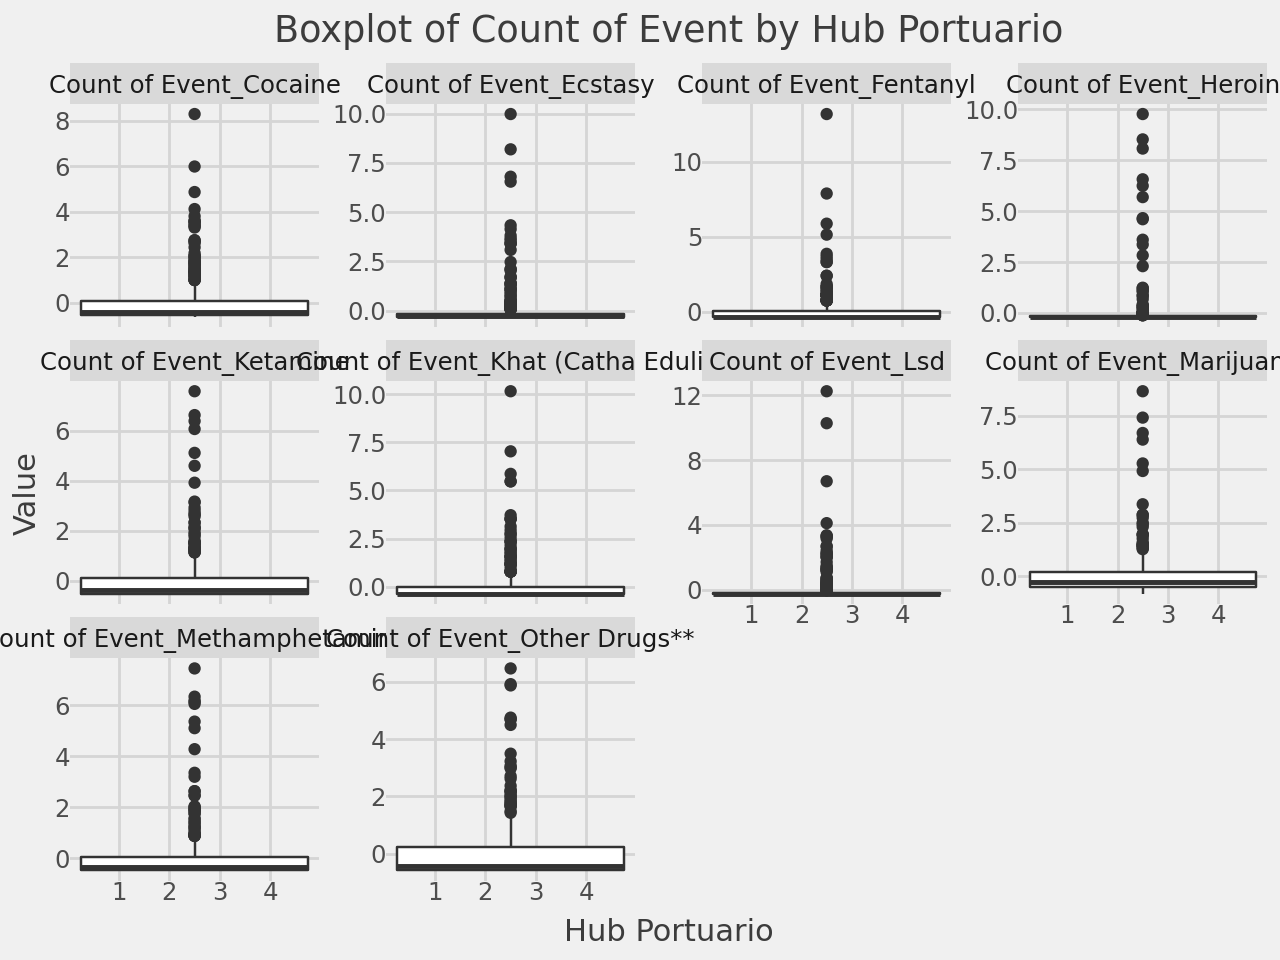

In [21]:
from plotnine import ggplot, aes, geom_boxplot, facet_wrap, labs, theme_538

# Filter the columns to include only 'Sum Qty_*' and 'Count of Event_*'
columns_to_plot = [col for col in standardized_data.columns if col.startswith('Count of Event')]

# Melt the dataframe to long format
standardized_data_melted = standardized_data.melt(id_vars=['Hub Portuario'], value_vars=columns_to_plot, var_name='Variable', value_name='Value')

# Create the boxplot
boxplot = (ggplot(standardized_data_melted, aes(x='Hub Portuario', y='Value'))
    + geom_boxplot()
    + facet_wrap('~ Variable', scales='free_y')
    + labs(title='Boxplot of Count of Event by Hub Portuario',
           x='Hub Portuario',
           y='Value')
    + theme_538()
)

boxplot

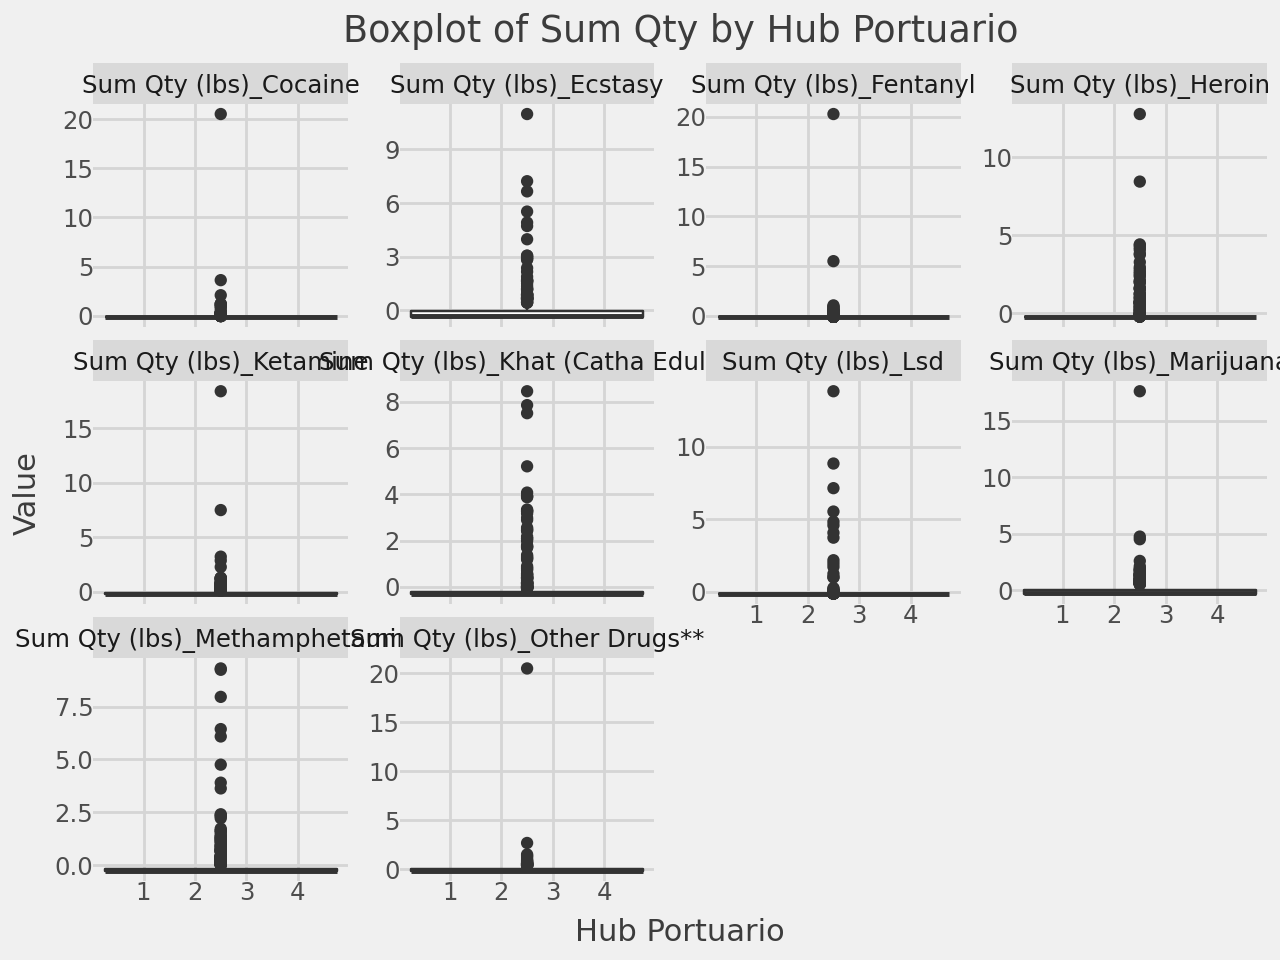

In [22]:
# Filter the columns to include only 'Sum Qty_*' and 'Count of Event_*'
columns_to_plot = [col for col in standardized_data.columns if col.startswith('Sum Qty')]

# Melt the dataframe to long format
standardized_data_melted = standardized_data.melt(id_vars=['Hub Portuario'], value_vars=columns_to_plot, var_name='Variable', value_name='Value')

# Create the boxplot
boxplot = (ggplot(standardized_data_melted, aes(x='Hub Portuario', y='Value'))
    + geom_boxplot()
    + facet_wrap('~ Variable', scales='free_y')
    + labs(title='Boxplot of Sum Qty by Hub Portuario',
           x='Hub Portuario',
           y='Value')
    + theme_538()
)

boxplot

In [29]:
standardized_data['Hub Portuario_name'].unique()

array(['Seattle/Tacoma', 'Newark/New York', 'Oakland',
       'Miami/Fort Lauderdale', 'Los Angeles/Long Beach', 'Houston'],
      dtype=object)

Visualizar con QQ-Plot

QQ-Plots para Newark (sin filtrar):

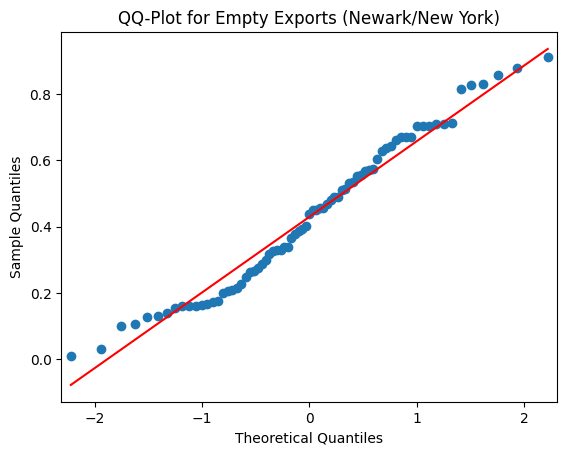

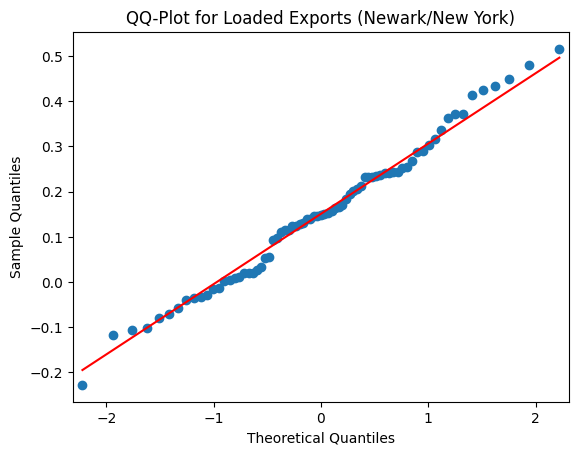

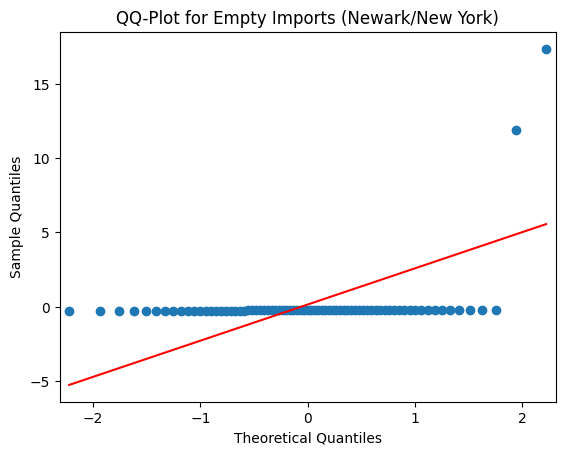

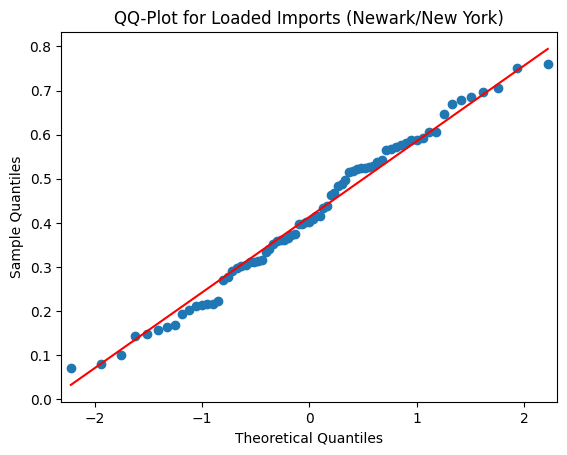

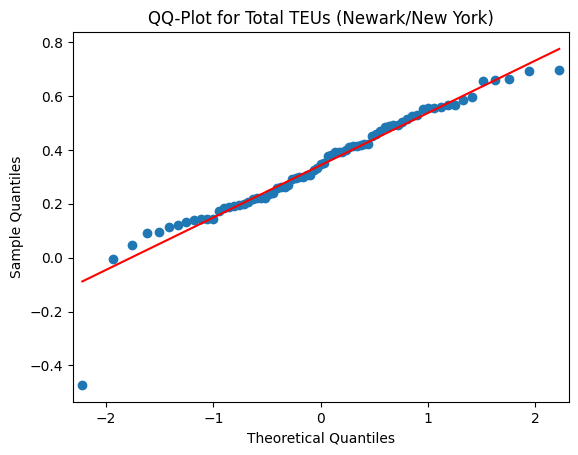

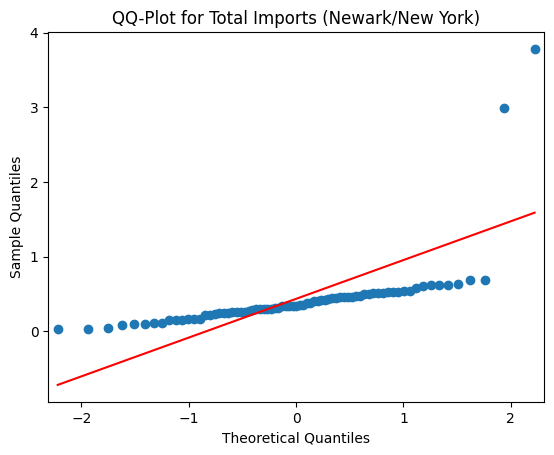

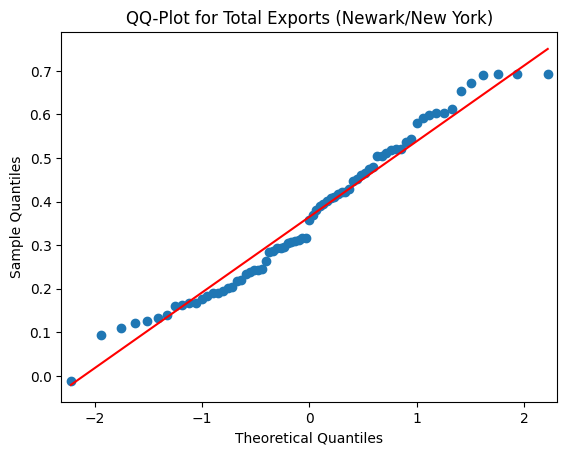

In [25]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Filter the dataframe for 'Newark/New York'
newark_data = standardized_data[standardized_data['Hub Portuario_name'] == 'Newark/New York']

# List of columns to generate QQ-plots for
columns_to_plot = ['Empty Exports', 'Loaded Exports', 'Empty Imports', 'Loaded Imports',
                   'Total TEUs', 'Total Imports', 'Total Exports']

# Generate QQ-plots for each column
for column in columns_to_plot:
    sm.qqplot(newark_data[column], line='s')
    plt.title(f'QQ-Plot for {column} (Newark/New York)')
    plt.show()

QQ-Plots para Fort Lauderdale (sin filtrar):

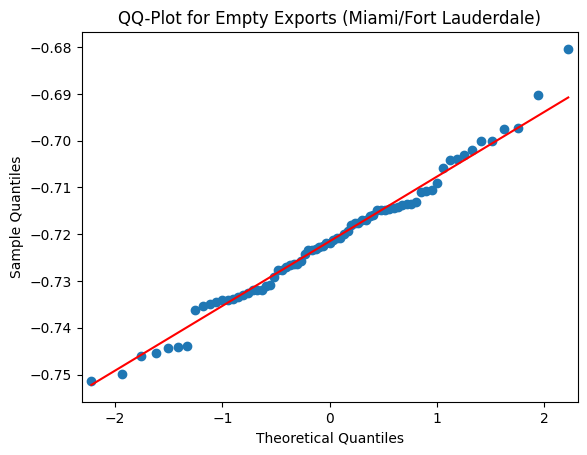

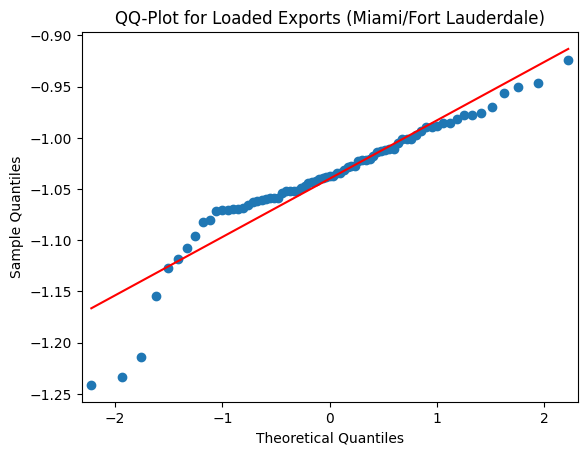

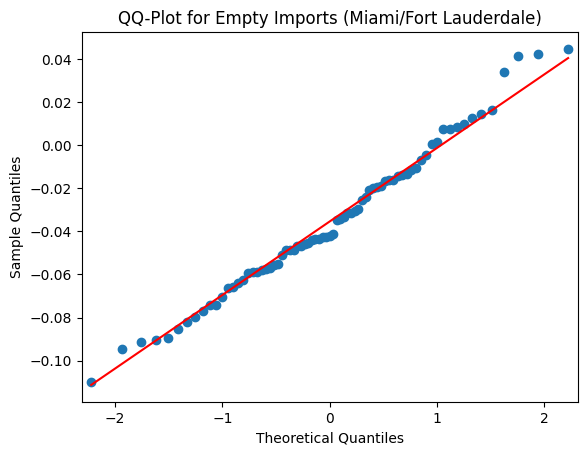

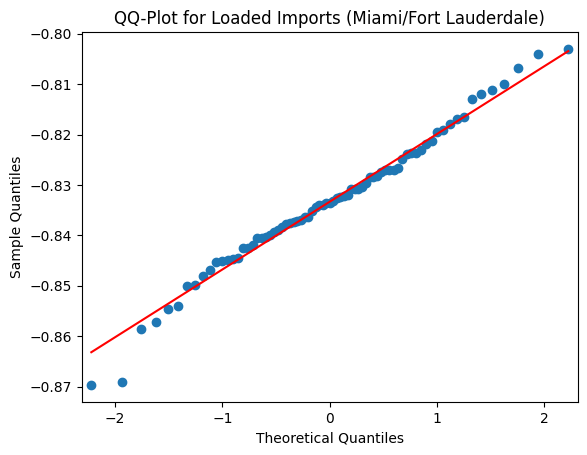

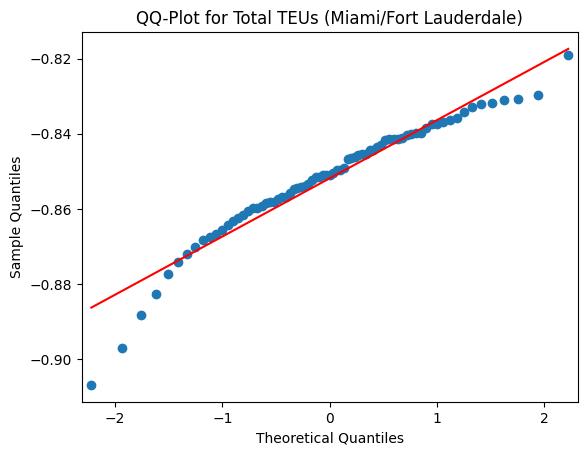

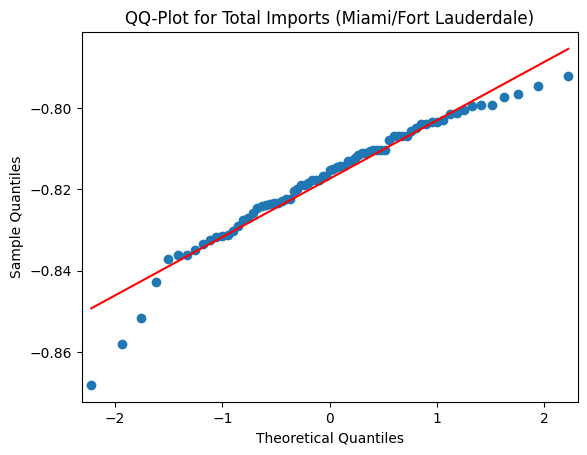

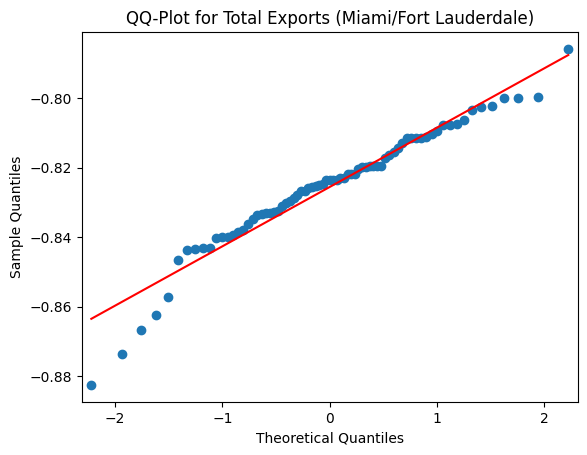

In [30]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Filter the dataframe for 'Newark/New York'
newark_data = standardized_data[standardized_data['Hub Portuario_name'] == 'Miami/Fort Lauderdale']

# List of columns to generate QQ-plots for
columns_to_plot = ['Empty Exports', 'Loaded Exports', 'Empty Imports', 'Loaded Imports',
                   'Total TEUs', 'Total Imports', 'Total Exports']

# Generate QQ-plots for each column
for column in columns_to_plot:
    sm.qqplot(newark_data[column], line='s')
    plt.title(f'QQ-Plot for {column} (Miami/Fort Lauderdale)')
    plt.show()

QQ-Plots para LA (sin filtrar):

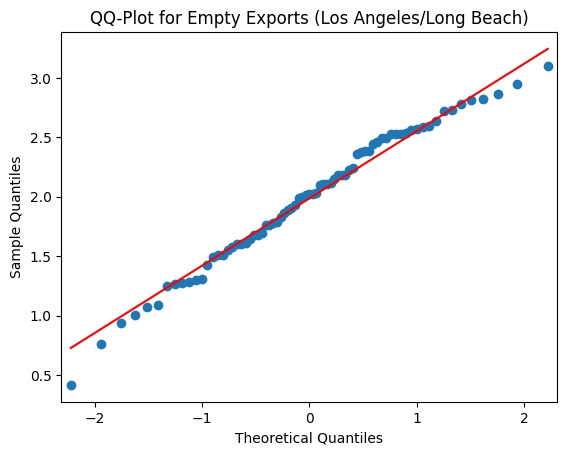

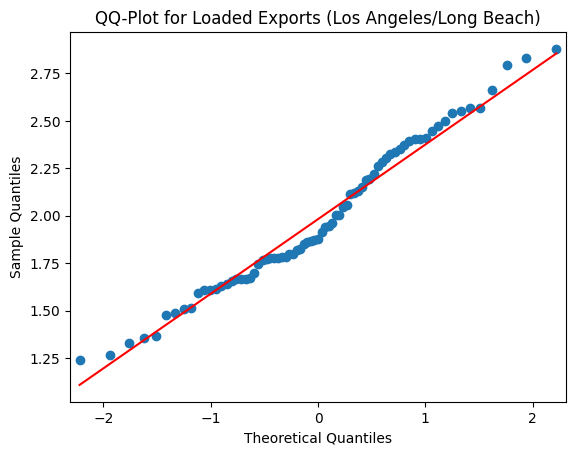

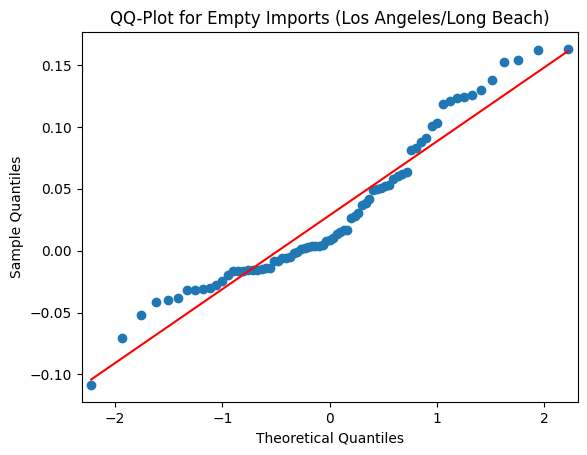

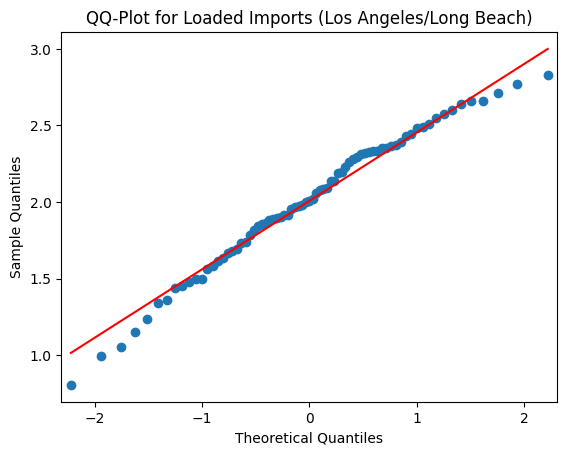

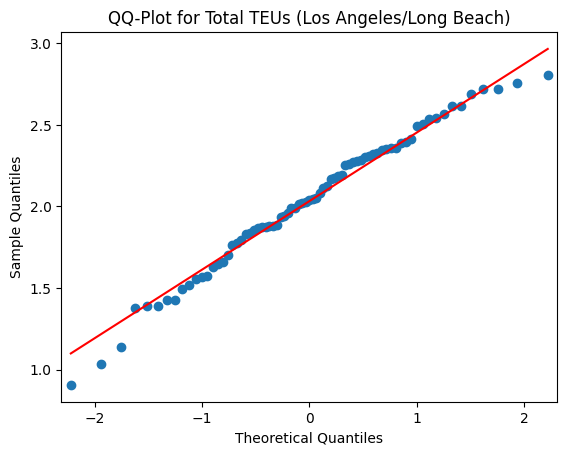

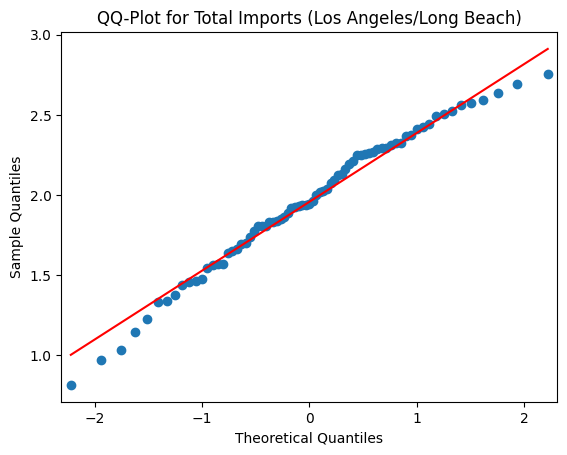

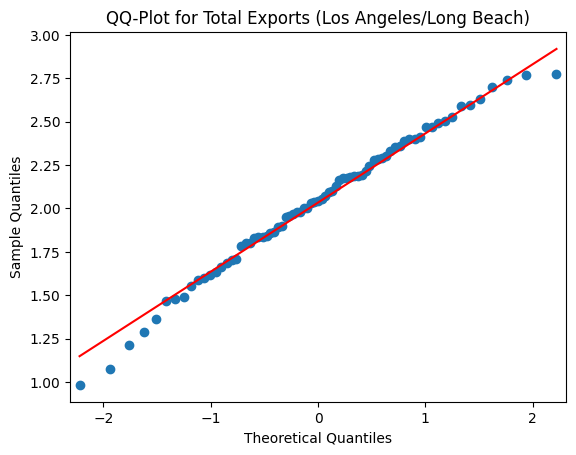

In [31]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Filter the dataframe for 'Newark/New York'
newark_data = standardized_data[standardized_data['Hub Portuario_name'] == 'Los Angeles/Long Beach']

# List of columns to generate QQ-plots for
columns_to_plot = ['Empty Exports', 'Loaded Exports', 'Empty Imports', 'Loaded Imports',
                   'Total TEUs', 'Total Imports', 'Total Exports']

# Generate QQ-plots for each column
for column in columns_to_plot:
    sm.qqplot(newark_data[column], line='s')
    plt.title(f'QQ-Plot for {column} (Los Angeles/Long Beach)')
    plt.show()

Distribuciones de predictores para Fort Lauderdale:

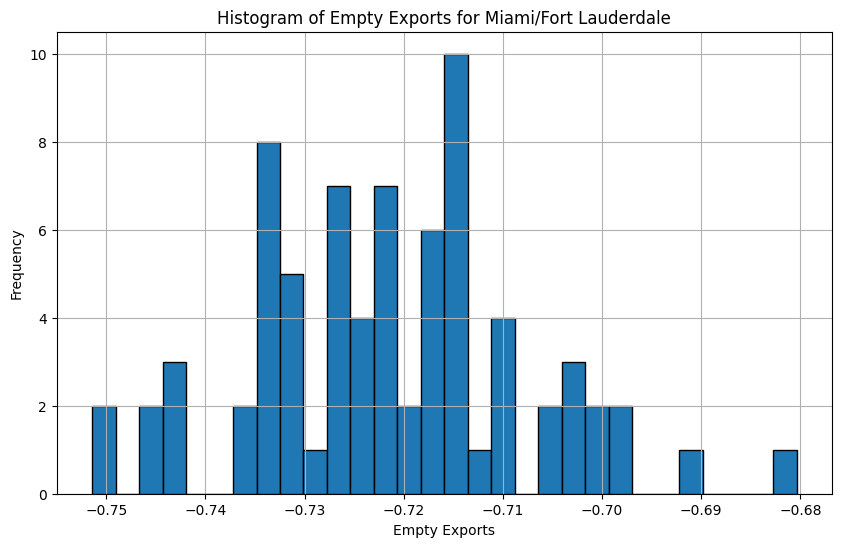

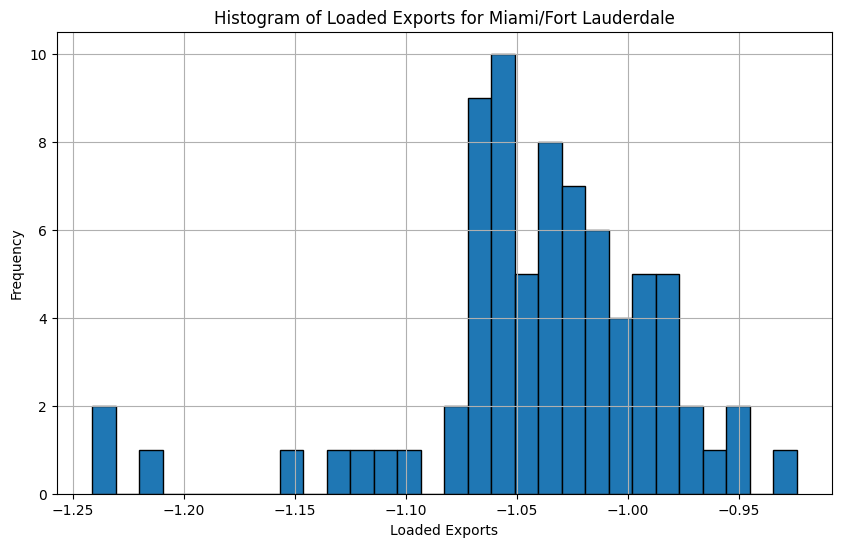

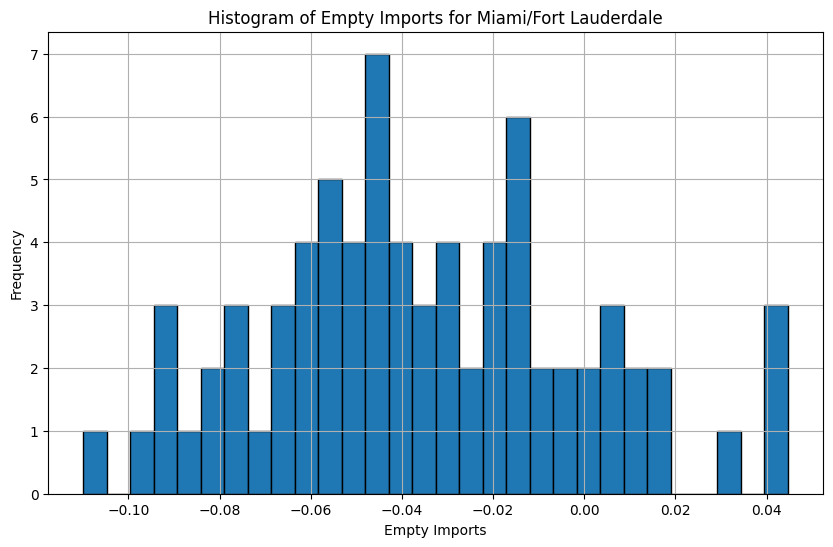

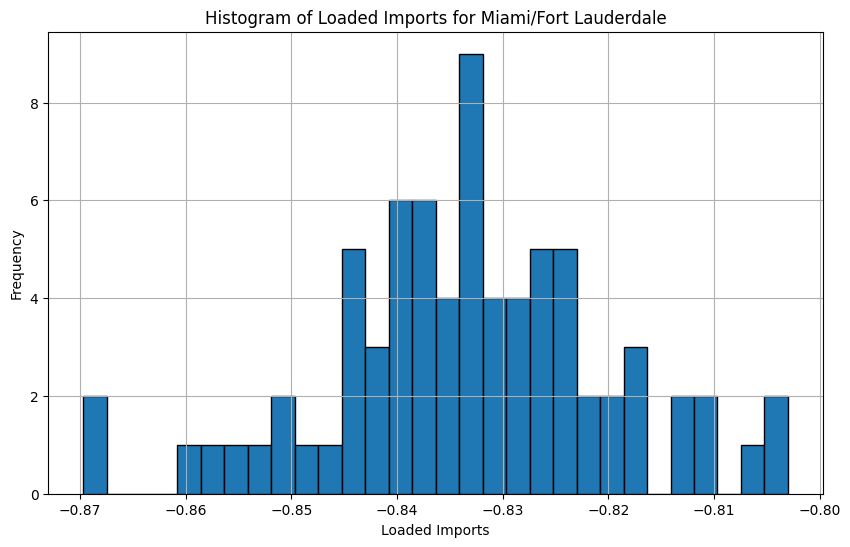

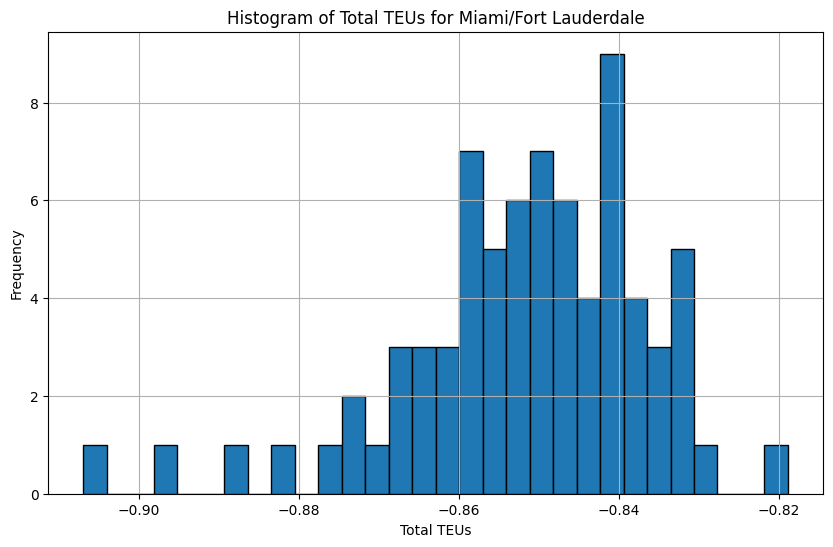

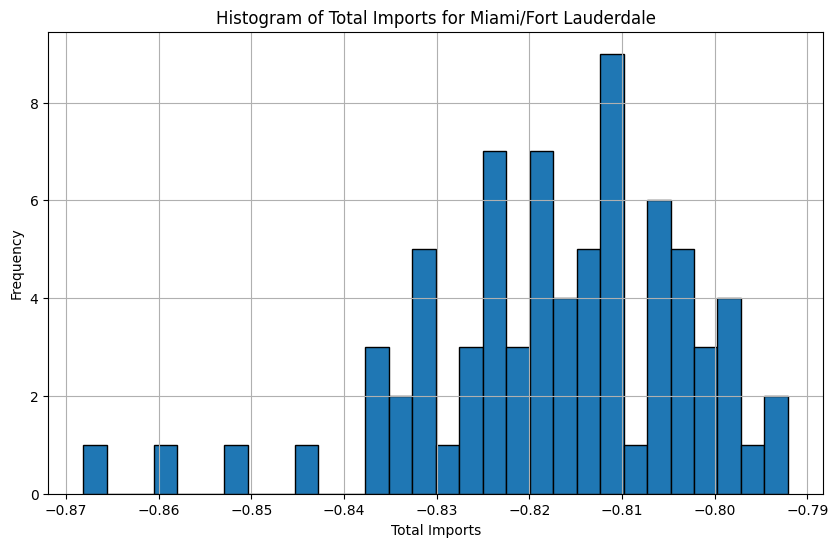

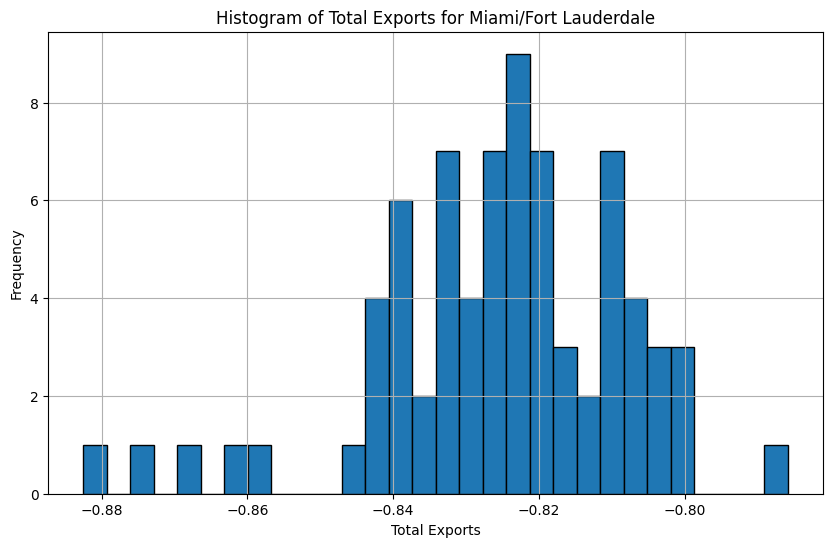

In [32]:
import matplotlib.pyplot as plt

# Filter the dataframe for 'Miami/Fort Lauderdale'
miami_data = standardized_data[standardized_data['Hub Portuario_name'] == 'Miami/Fort Lauderdale']

# Plot histograms for each variable in columns_to_plot
for column in columns_to_plot:
    plt.figure(figsize=(10, 6))
    plt.hist(miami_data[column], bins=30, edgecolor='black')
    plt.title(f'Histogram of {column} for Miami/Fort Lauderdale')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Distribuciones de predictores para Newark:

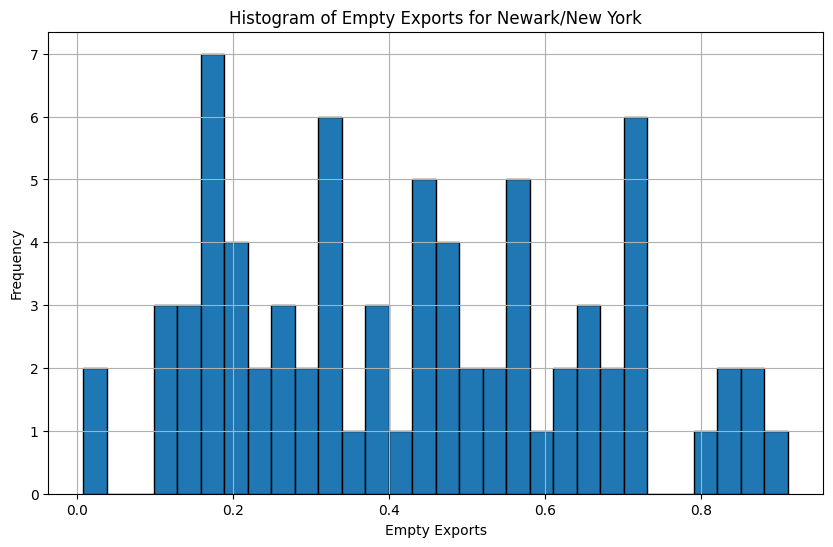

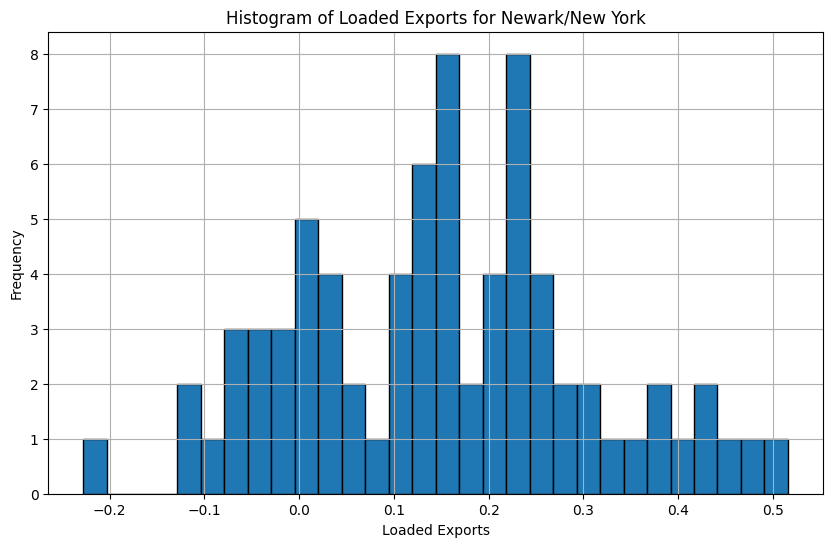

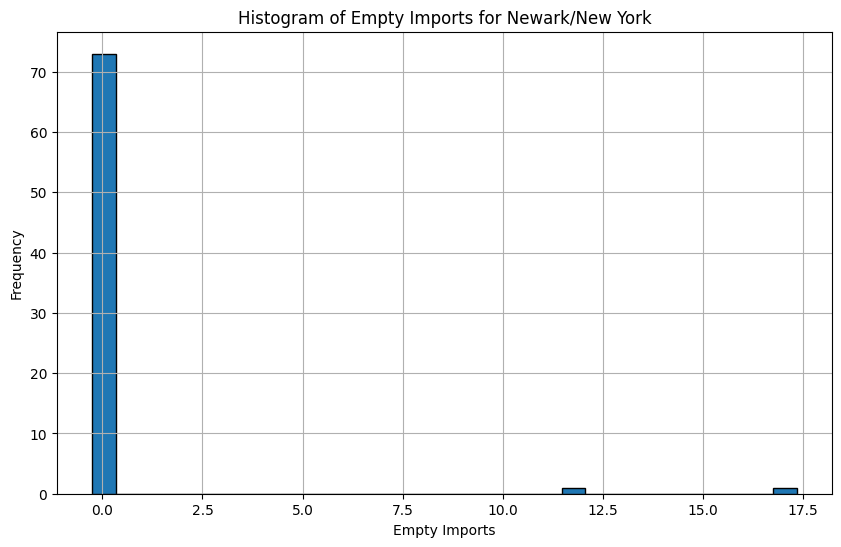

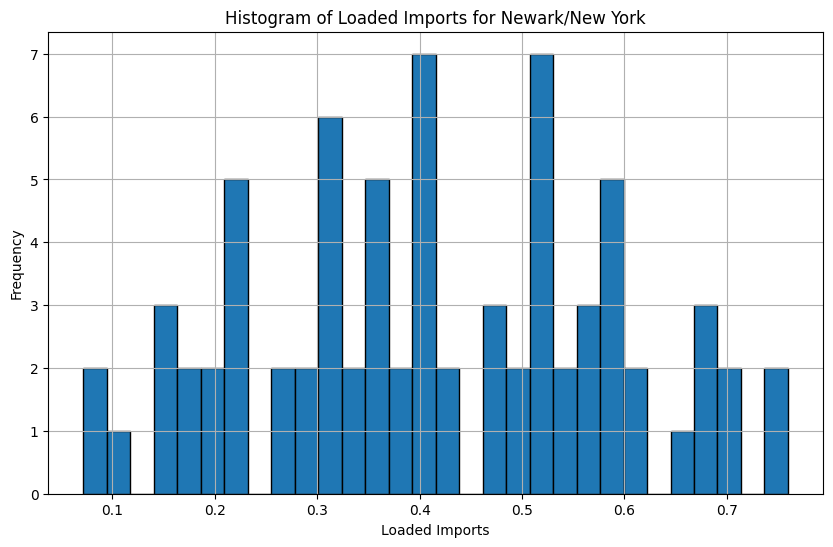

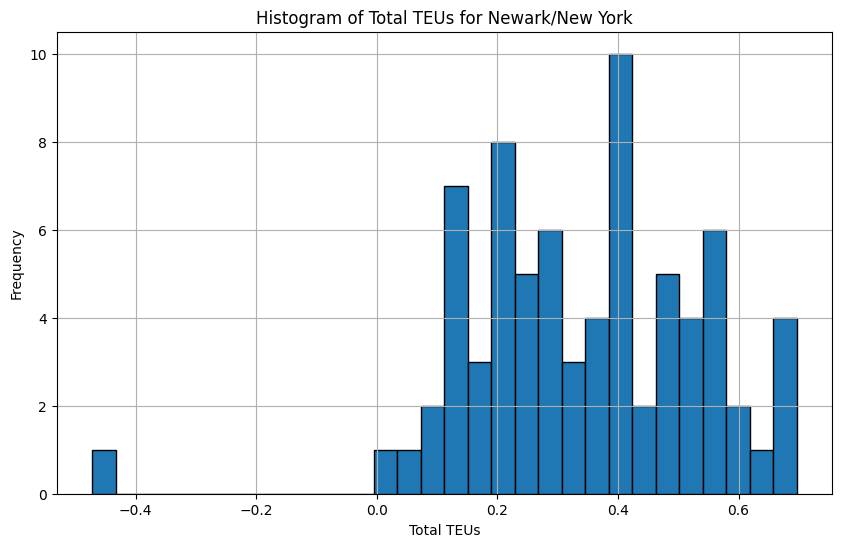

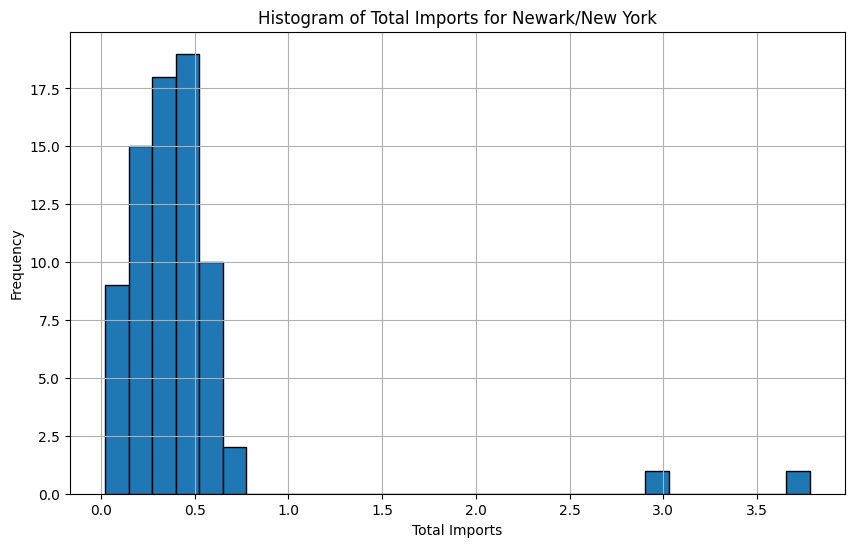

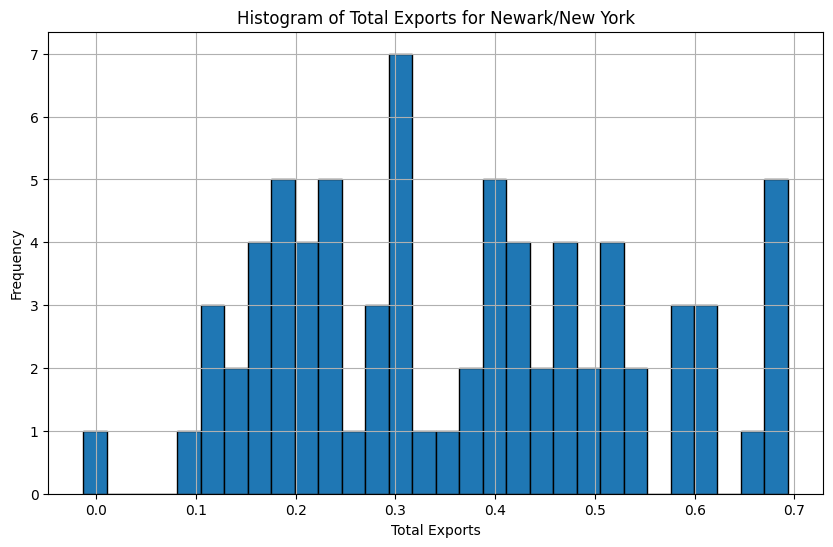

In [33]:
import matplotlib.pyplot as plt

# Filter the dataframe for 'Miami/Fort Lauderdale'
miami_data = standardized_data[standardized_data['Hub Portuario_name'] == 'Newark/New York']

# Plot histograms for each variable in columns_to_plot
for column in columns_to_plot:
    plt.figure(figsize=(10, 6))
    plt.hist(miami_data[column], bins=30, edgecolor='black')
    plt.title(f'Histogram of {column} for Newark/New York')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Distribuciones de predictores para LA:

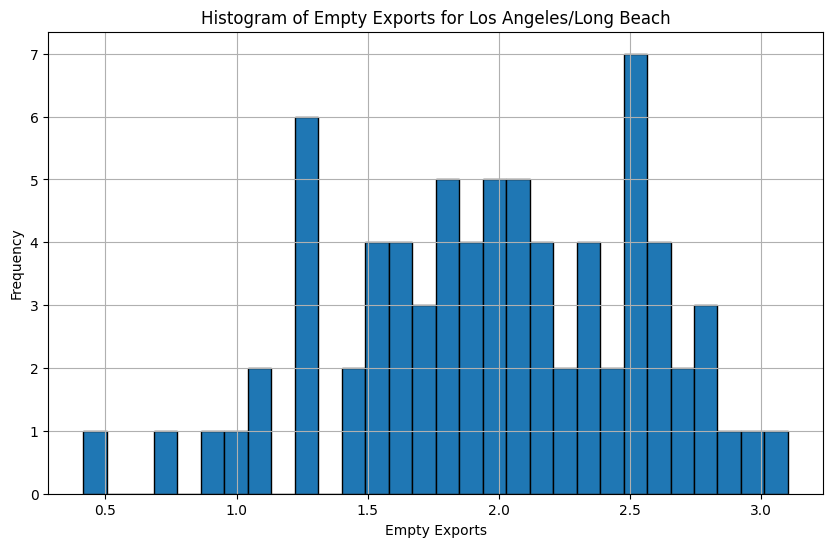

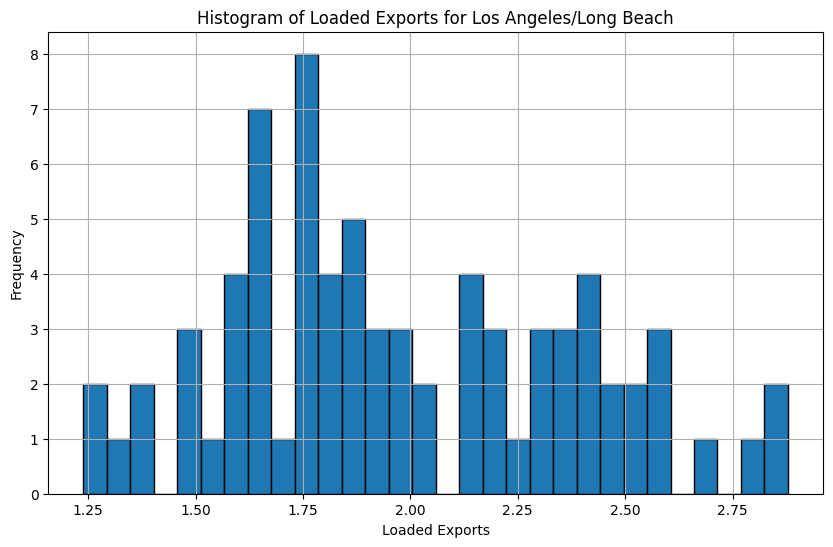

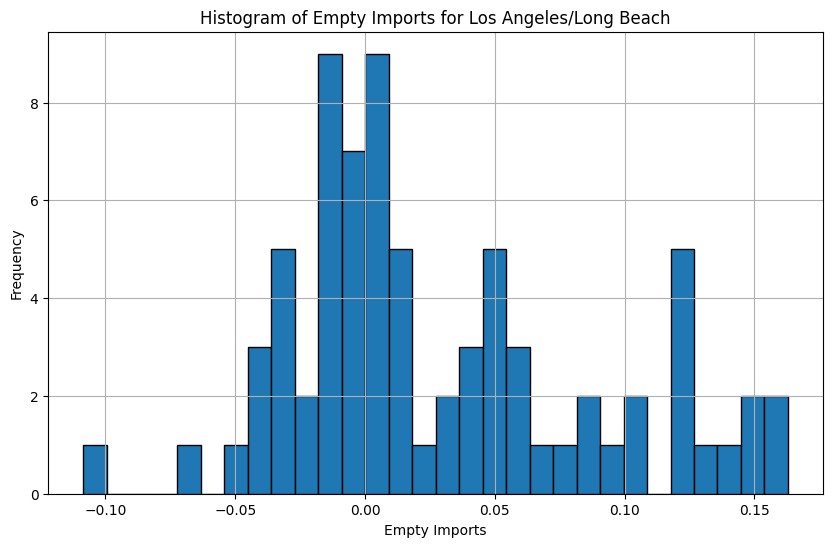

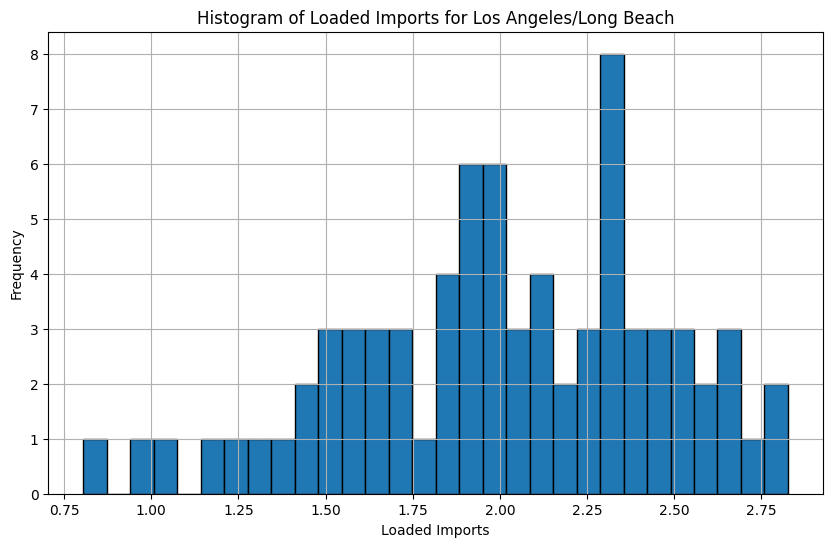

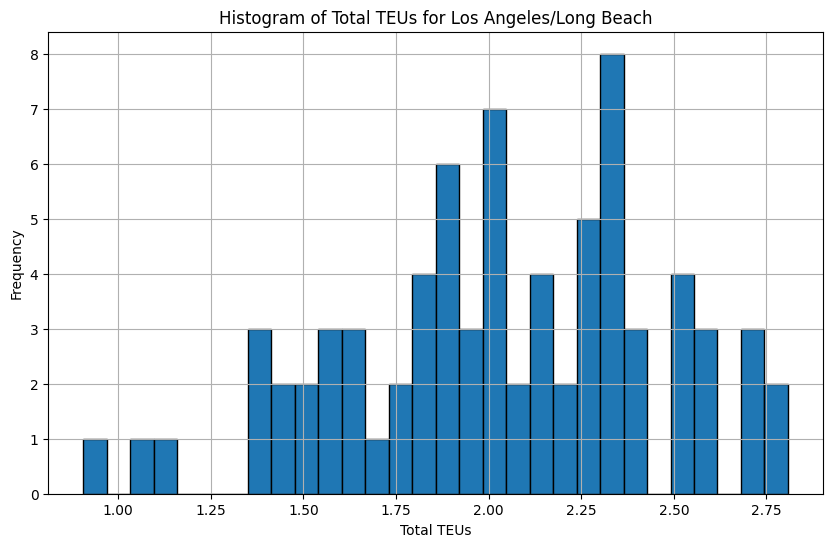

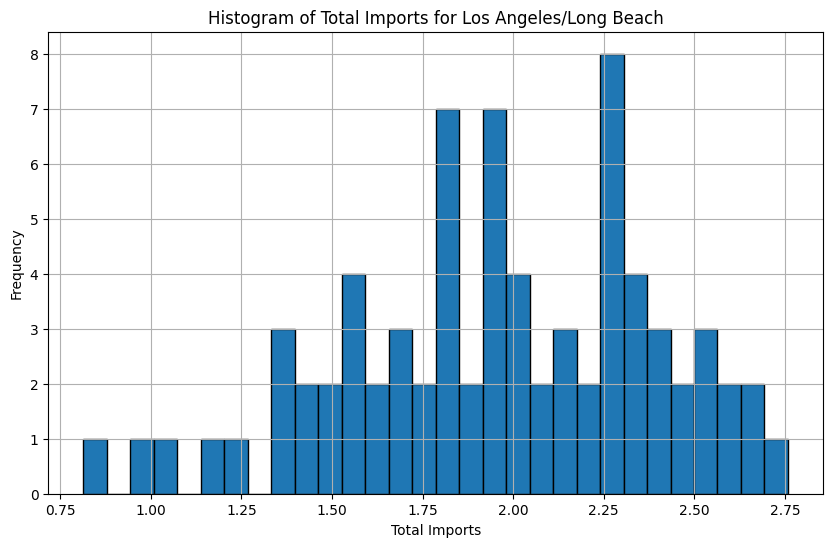

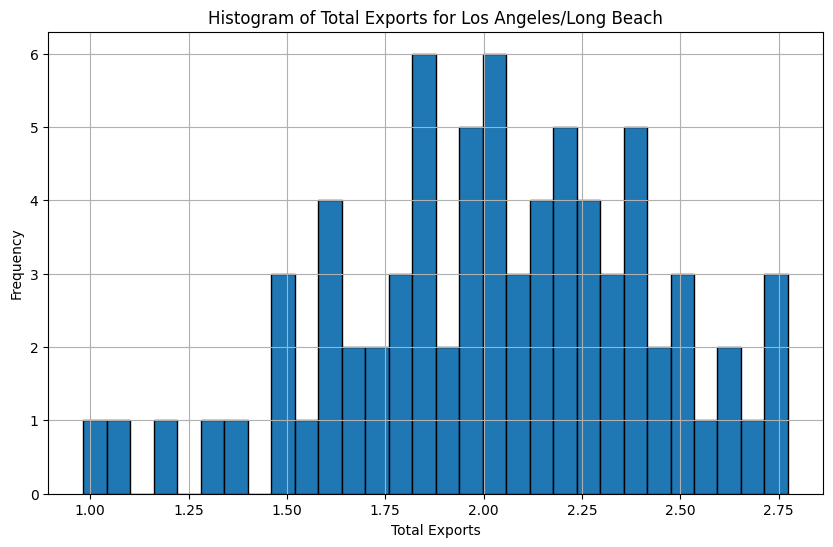

In [34]:
import matplotlib.pyplot as plt

# Filter the dataframe for 'Miami/Fort Lauderdale'
miami_data = standardized_data[standardized_data['Hub Portuario_name'] == 'Los Angeles/Long Beach']

# Plot histograms for each variable in columns_to_plot
for column in columns_to_plot:
    plt.figure(figsize=(10, 6))
    plt.hist(miami_data[column], bins=30, edgecolor='black')
    plt.title(f'Histogram of {column} for Los Angeles/Long Beach')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Tratamiento de Outliers:
- Boxplots

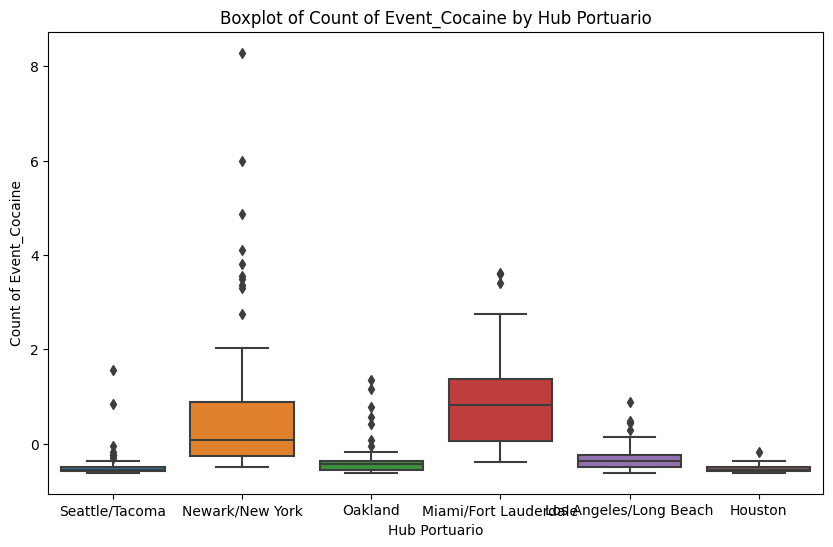

<Axes: title={'center': 'Boxplot of Count of Event_Cocaine by Hub Portuario'}, xlabel='Hub Portuario', ylabel='Count of Event_Cocaine'>

In [62]:
from plotnine import ggplot, aes, geom_boxplot, labs, theme_538
import seaborn as sns

# Create the boxplot
import matplotlib.pyplot as plt

# Create the boxplot
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x='Hub Portuario_name', y='Count of Event_Cocaine', data=standardized_data)
boxplot.set_title('Boxplot of Count of Event_Cocaine by Hub Portuario')
boxplot.set_xlabel('Hub Portuario')
boxplot.set_ylabel('Count of Event_Cocaine')
plt.show()

boxplot

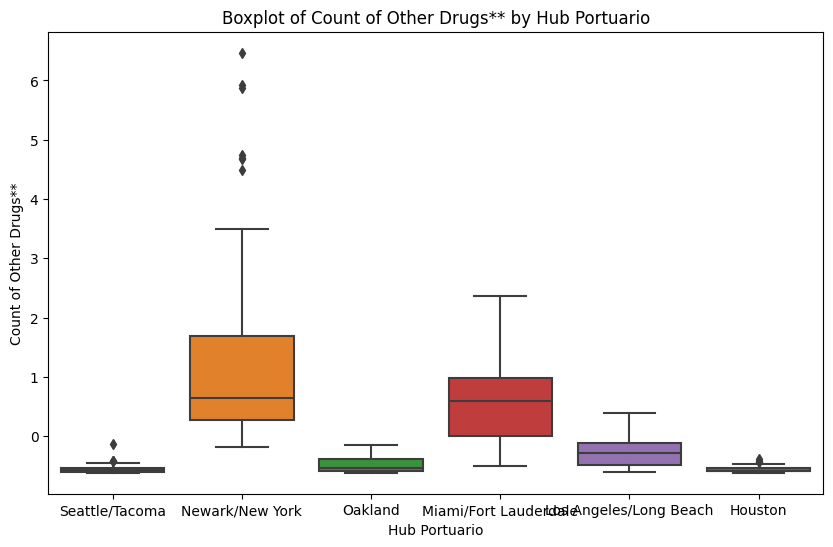

<Axes: title={'center': 'Boxplot of Count of Other Drugs** by Hub Portuario'}, xlabel='Hub Portuario', ylabel='Count of Other Drugs**'>

In [63]:
from plotnine import ggplot, aes, geom_boxplot, labs, theme_538
import seaborn as sns

# Create the boxplot
import matplotlib.pyplot as plt

# Create the boxplot
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x='Hub Portuario_name', y='Count of Event_Other Drugs**', data=standardized_data)
boxplot.set_title('Boxplot of Count of Other Drugs** by Hub Portuario')
boxplot.set_xlabel('Hub Portuario')
boxplot.set_ylabel('Count of Other Drugs**')
plt.show()

boxplot

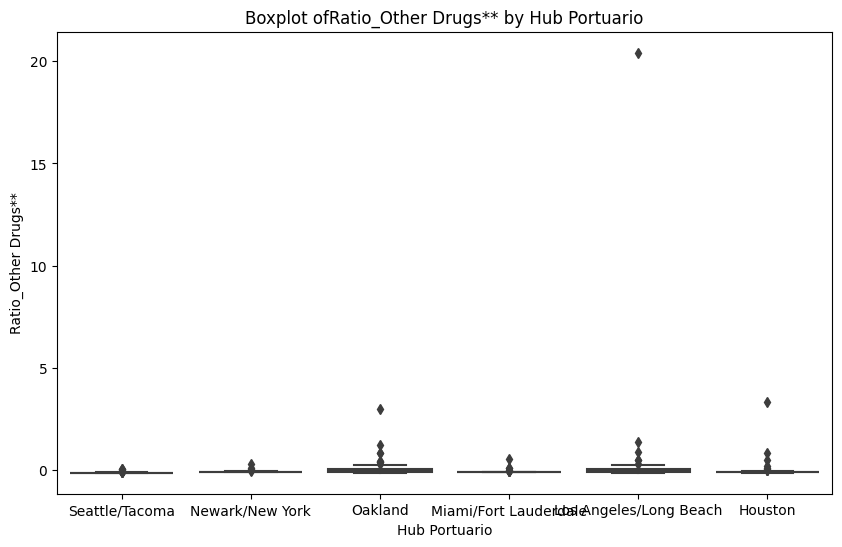

<Axes: title={'center': 'Boxplot ofRatio_Other Drugs** by Hub Portuario'}, xlabel='Hub Portuario', ylabel='Ratio_Other Drugs**'>

In [64]:
# Create the boxplot
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x='Hub Portuario_name', y='Ratio_Other Drugs**', data=standardized_data)
boxplot.set_title('Boxplot ofRatio_Other Drugs** by Hub Portuario')
boxplot.set_xlabel('Hub Portuario')
boxplot.set_ylabel('Ratio_Other Drugs**')
plt.show()

boxplot

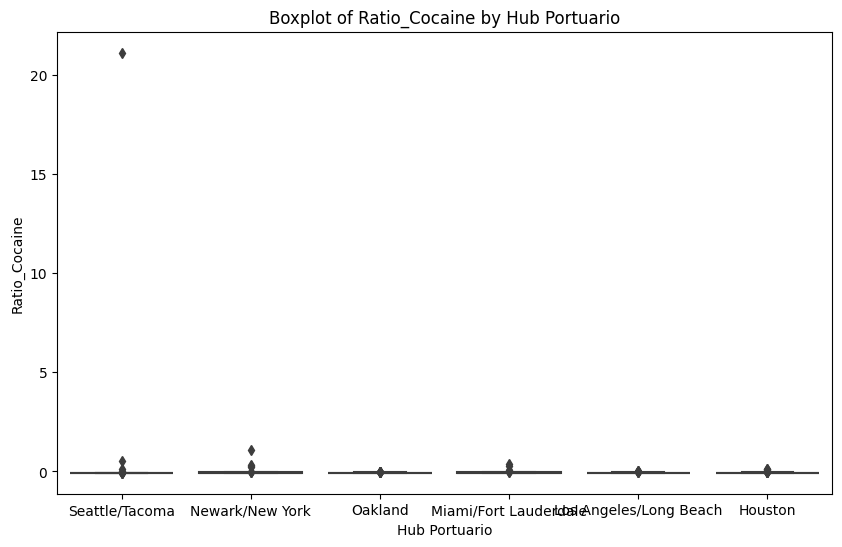

<Axes: title={'center': 'Boxplot of Ratio_Cocaine by Hub Portuario'}, xlabel='Hub Portuario', ylabel='Ratio_Cocaine'>

In [65]:
# Create the boxplot
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x='Hub Portuario_name', y='Ratio_Cocaine', data=standardized_data)
boxplot.set_title('Boxplot of Ratio_Cocaine by Hub Portuario')
boxplot.set_xlabel('Hub Portuario')
boxplot.set_ylabel('Ratio_Cocaine')
plt.show()

boxplot

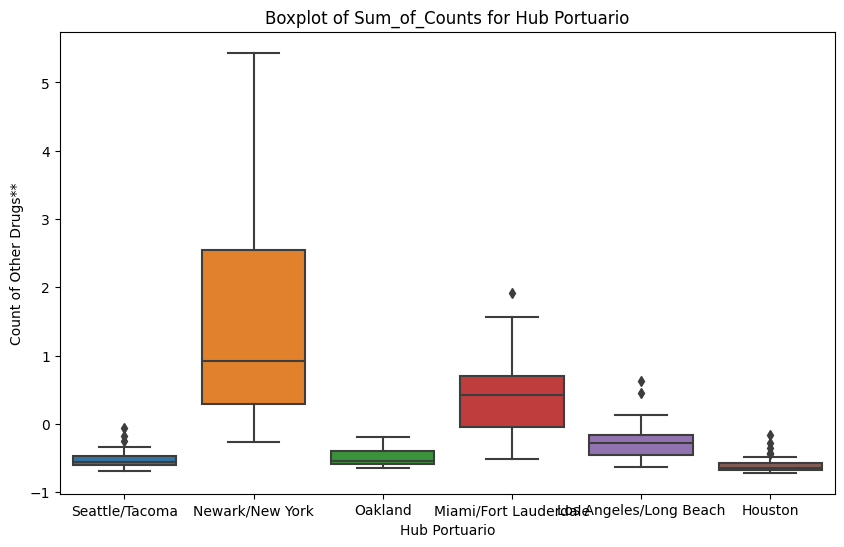

<Axes: title={'center': 'Boxplot of Sum_of_Counts for Hub Portuario'}, xlabel='Hub Portuario', ylabel='Count of Other Drugs**'>

In [68]:
# Create the boxplot
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x='Hub Portuario_name', y='Sum_of_Counts', data=standardized_data)
boxplot.set_title('Boxplot of Sum_of_Counts for Hub Portuario')
boxplot.set_xlabel('Hub Portuario')
boxplot.set_ylabel('Count of Other Drugs**')
plt.show()

boxplot

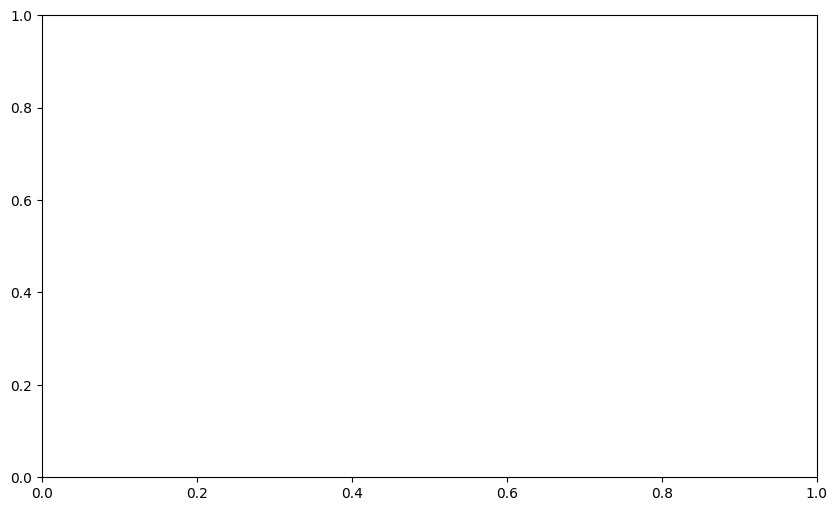

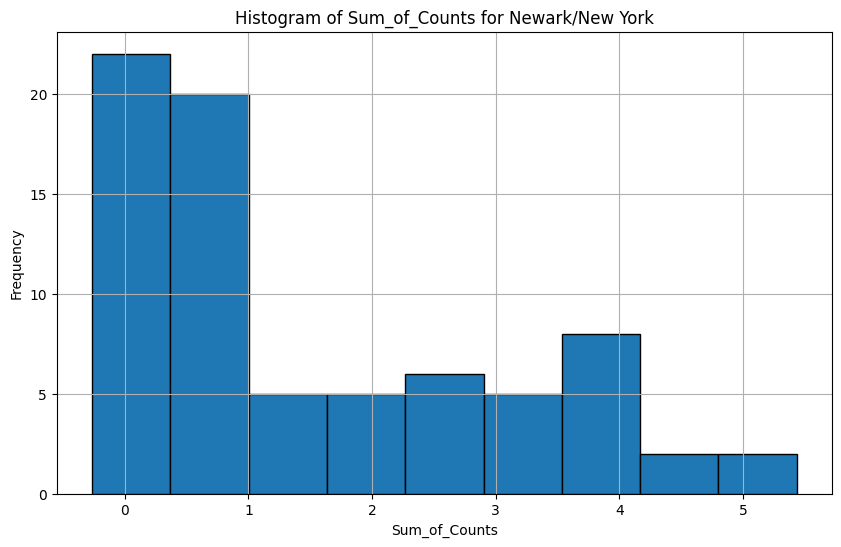

In [77]:
import numpy as np

import matplotlib.pyplot as plt

# Calculate the number of bins
bins = int(round(np.sqrt(len(ny_import_sorted))))

# Plot the histogram for 'Sum_of_Counts'
plt.figure(figsize=(10, 6))
plt.hist(ny_import_sorted['Sum_of_Counts'], bins=bins, edgecolor='black')
plt.title('Histogram of Sum_of_Counts for Newark/New York')
plt.xlabel('Sum_of_Counts')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Outliers:
- Generar nuevo dataframe a partir de standardized_data. Eliminar filas con abs(Ratio_*) > 5

In [36]:
# List of columns to check for outliers
ratio_columns = [col for col in standardized_data.columns if col.startswith('Ratio_')]

# Filter the dataframe to remove rows with abs(Ratio_*) > 5
filtered_data = standardized_data[~standardized_data[ratio_columns].abs().gt(5).any(axis=1)]

### Outliers para Newark
Outliers para Nueva York:

In [40]:
ny_import_sorted = standardized_data[standardized_data['Hub Portuario_name'] == 'Newark/New York'].sort_values(by='Total Imports', ascending=False)

In [ ]:
ny_import_sorted

,Date,Empty Exports,Loaded Exports,Empty Imports,Loaded Imports,Total TEUs,Total Imports,Total Exports,latitude,longitude,...,Ratio_Heroin,Ratio_Ketamine,Ratio_Khat (Catha Edulis),Ratio_Lsd,Ratio_Marijuana,Ratio_Methamphetamine,Ratio_Other Drugs**,Hub Portuario,Hub Portuario_name,Top_2
28,2019-02,0.163579,0.163064,17.346244,0.192706,0.143187,3.781933,0.167499,0.673502,1.387485,...,1.587266,-0.076712,-0.170493,-0.174954,-0.359733,-0.256335,-0.119472,3.0,Newark/New York,True
245,2022-02,0.670949,0.018828,11.881139,0.538833,0.490811,2.985866,0.511149,0.673502,1.387485,...,-0.013092,0.111017,1.632640,-0.176541,-0.162387,-0.255695,-0.126111,3.0,Newark/New York,True
251,2022-03,0.829068,0.251782,-0.250707,0.759688,0.696289,0.686498,0.693442,0.673502,1.387485,...,0.497570,0.353346,0.058637,-0.175150,-0.242912,-0.248621,-0.122240,3.0,Newark/New York,False
267,2022-06,0.878408,0.110120,-0.245621,0.751337,0.691966,0.679434,0.692326,0.673502,1.387485,...,-0.115189,0.093062,0.016299,-0.176715,-0.310075,-0.262862,-0.088728,3.0,Newark/New York,False
276,2022-08,0.856881,0.098296,-0.243997,0.704875,0.658485,0.634608,0.672889,0.673502,1.387485,...,-0.112441,0.061339,0.090300,-0.177751,0.626208,-0.255685,-0.062171,3.0,Newark/New York,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,2020-04,0.173824,-0.078626,-0.252312,0.148682,0.092677,0.092240,0.109830,0.673502,1.387485,...,-0.099123,-0.098524,0.266212,-0.174539,-0.365398,-0.262367,-0.121748,3.0,Newark/New York,False
31,2019-03,0.138825,0.414304,-0.252078,0.144480,0.142952,0.088203,0.216810,0.673502,1.387485,...,0.050603,-0.014191,-0.249226,-0.174478,-0.355218,-0.260069,-0.127149,3.0,Newark/New York,False
105,2020-03,0.030349,0.515854,-0.242428,0.100376,0.094477,0.047332,0.162470,0.673502,1.387485,...,-0.114741,-0.088010,1.555479,-0.174821,0.010187,-0.259303,-0.095614,3.0,Newark/New York,False
117,2020-05,0.161331,-0.106491,-0.257453,0.079200,0.047700,0.023635,0.092867,0.673502,1.387485,...,-0.113344,-0.068557,0.252340,-0.176064,-0.327282,-0.261175,-0.117895,3.0,Newark/New York,False


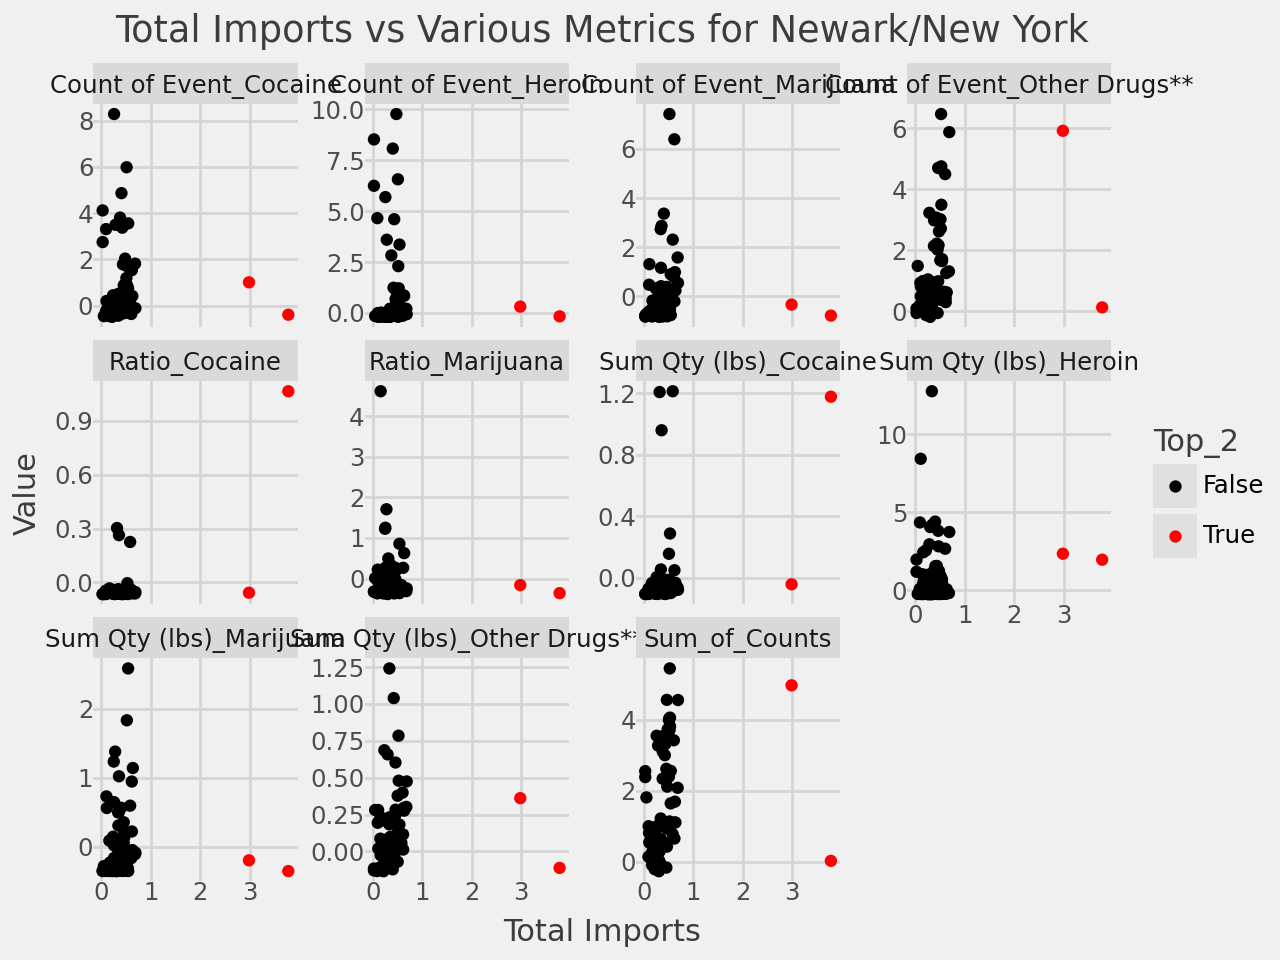

In [48]:
from plotnine import ggplot, aes, geom_point, facet_wrap, labs, theme_538

# List of variables to plot against 'Total Imports'
variables_to_plot = [
    'Count of Event_Cocaine','Count of Event_Heroin','Count of Event_Marijuana',
    'Count of Event_Other Drugs**', 'Sum Qty (lbs)_Cocaine','Sum Qty (lbs)_Heroin',
    'Sum Qty (lbs)_Marijuana','Sum Qty (lbs)_Other Drugs**', 'Sum_of_Counts', 'Ratio_Cocaine',
    'Ratio_Marijuana']

# Identify the top 2 points with the highest value in 'Total Imports'
ny_import_sorted['Top_2'] = ny_import_sorted['Total Imports'].rank(method='first', ascending=False) <= 2

# Melt the dataframe to long format
ny_import_sorted_melted = ny_import_sorted.melt(id_vars=['Total Imports', 'Top_2'], value_vars=variables_to_plot, var_name='Variable', value_name='Value')

# Create the plot
plot = (ggplot(ny_import_sorted_melted, aes(x='Total Imports', y='Value', color='Top_2'))
    + geom_point()
    + facet_wrap('~ Variable', scales='free_y')
    + labs(title='Total Imports vs Various Metrics for Newark/New York',
           x='Total Imports',
           y='Value')
    + theme_538()
    + scale_color_manual(values={True: 'red', False: 'black'})
)

plot

In [ ]:
# Filter the dataframe for 'Newark/New York'
newark_data = filtered_data[filtered_data['Hub Portuario_name'] == 'Newark/New York']

# Drop out values greater than 10 for columns with numeric data types
ny_import_sorted['Top_2'] = ny_import_sorted['Total Imports'].rank(method='first', ascending=False) <= 2
numeric_columns = newark_data.select_dtypes(include='number').columns
newark_data_filtered = newark_data[ny_import_sorted['Top_2'] == False]

/tmp/ipykernel_14399/231544204.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


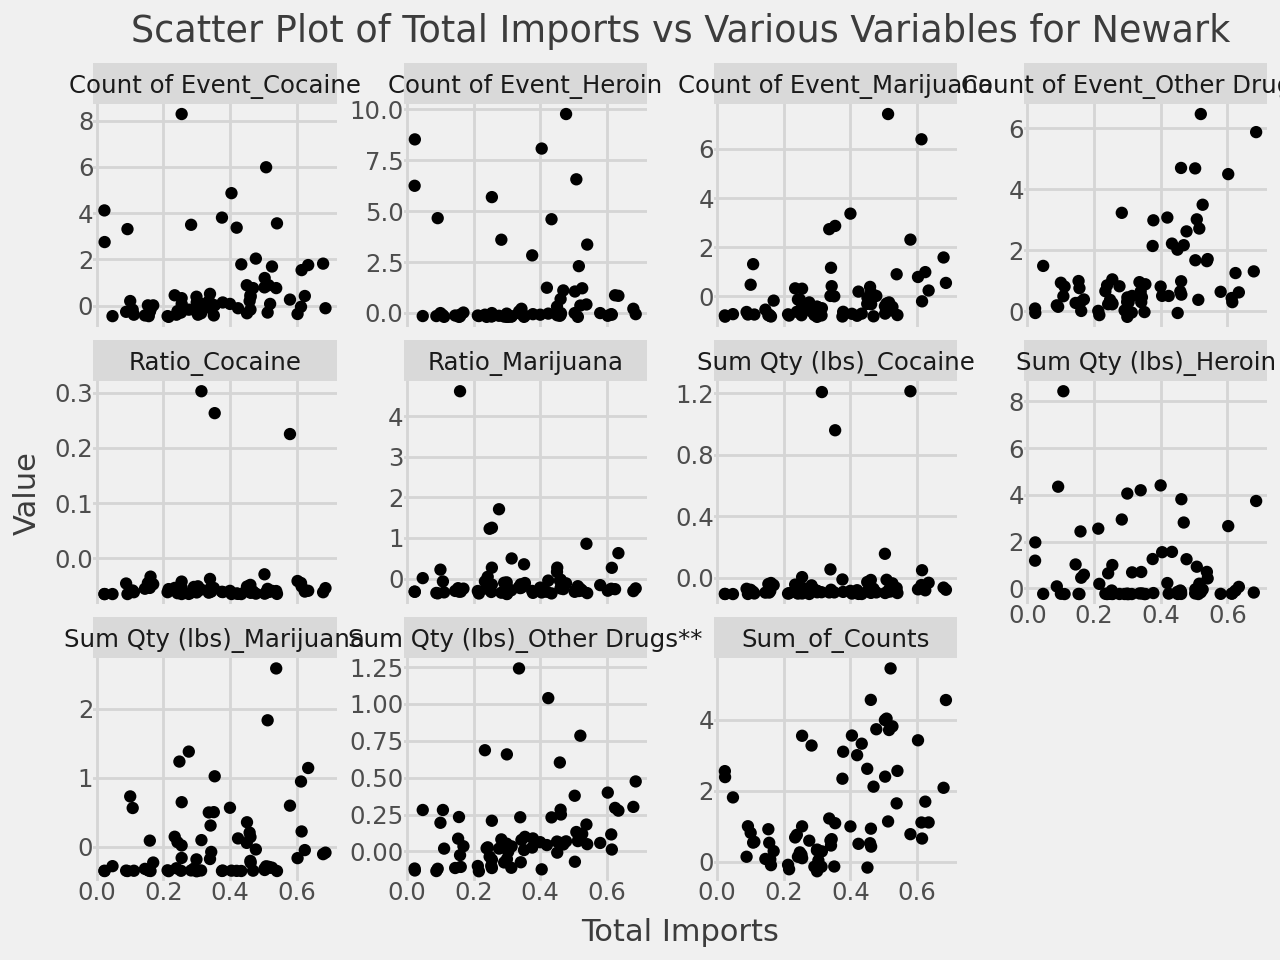

In [60]:
from plotnine import ggplot, aes, geom_point, labs, theme_538, facet_wrap

# Melt the dataframe to long format for plotting
newark_data_filtered_melted = newark_data_filtered.melt(id_vars=['Total Imports'], value_vars=variables_to_plot, var_name='Variable', value_name='Value')

# Create the scatter plot with faceting
plot = (ggplot(newark_data_filtered_melted, aes(x='Total Imports', y='Value'))
    + geom_point()
    + labs(title='Scatter Plot of Total Imports vs Various Variables for Newark',
           x='Total Imports',
           y='Value')
    + theme_538()
    + facet_wrap('~ Variable', scales='free_y')
)

plot

QQ-Plots para Newark (Filtrados)

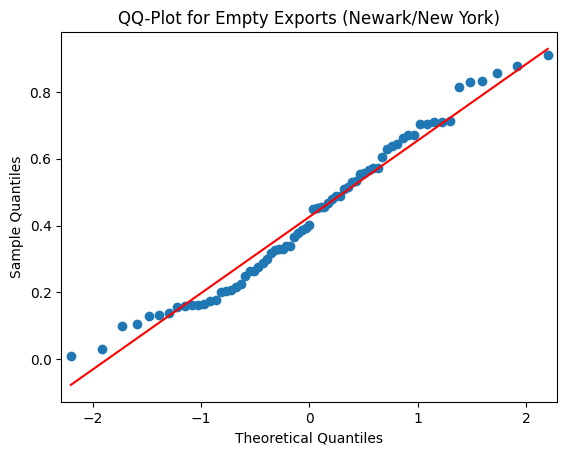

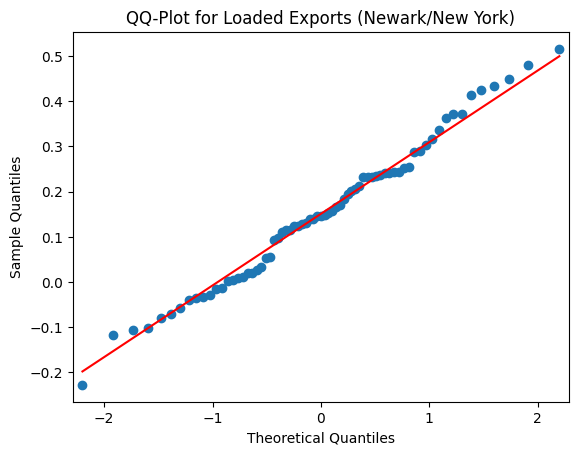

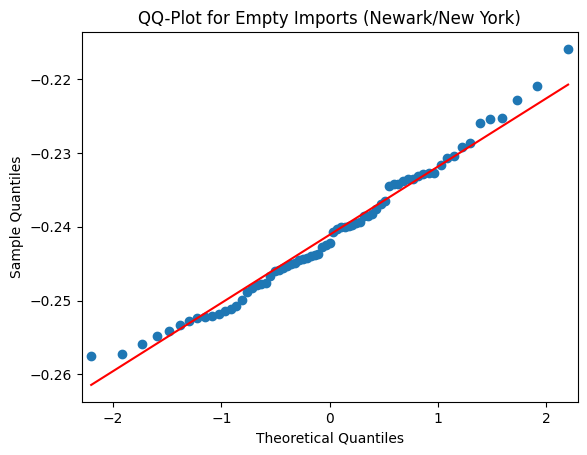

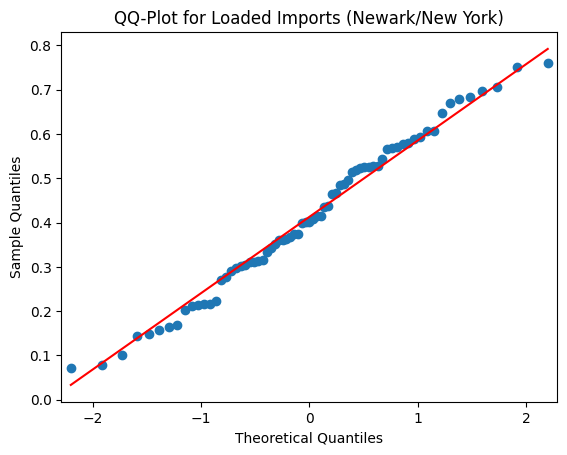

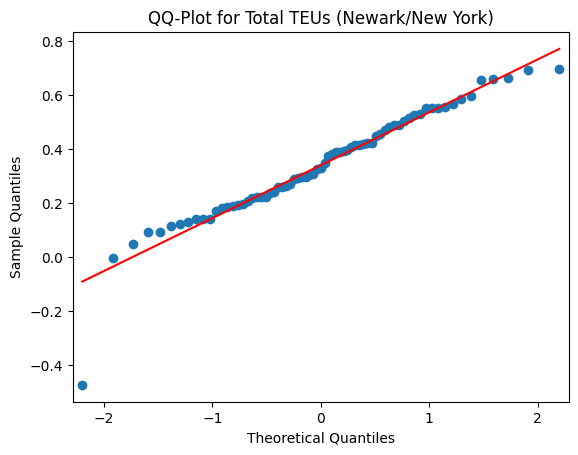

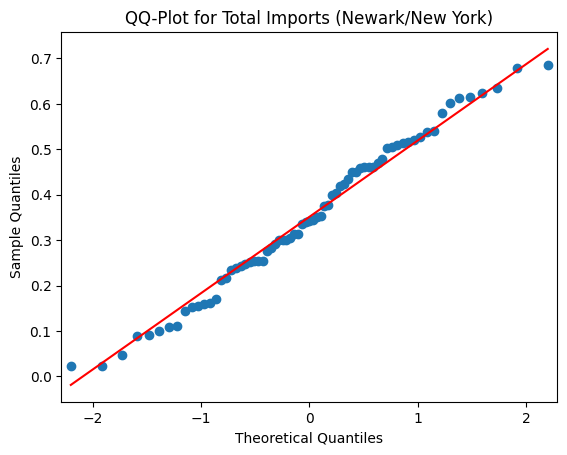

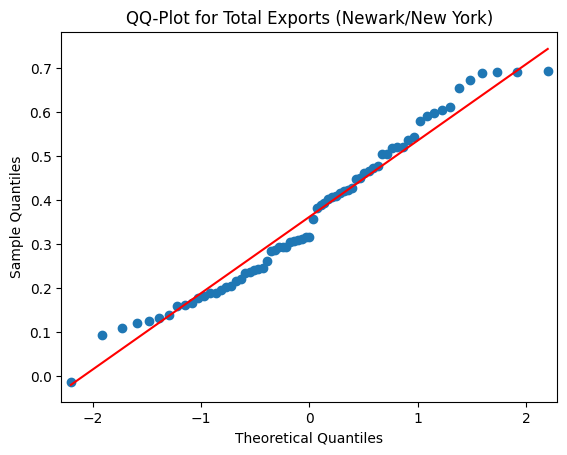

In [87]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# List of columns to generate QQ-plots for
columns_to_plot = ['Empty Exports', 'Loaded Exports', 'Empty Imports', 'Loaded Imports',
                   'Total TEUs', 'Total Imports', 'Total Exports']

# Generate QQ-plots for each column
for column in columns_to_plot:
    sm.qqplot(newark_data_filtered[column], line='s')
    plt.title(f'QQ-Plot for {column} (Newark/New York)')
    plt.show()

### Outliers para Miami

Outliers para Miami:

In [ ]:
# Filter the dataframe for 'Miami/Fort Lauderdale'
everglades_data = filtered_data[filtered_data['Hub Portuario_name'] == 'Miami/Fort Lauderdale']

In [ ]:
# Filter the dataframe for 'Miami/Fort Lauderdale'

# Create the plot
plot = (ggplot(everglades_data, aes(x='Empty Imports', y='Count of Event_Cocaine'))
    + geom_point()
    + labs(title='Empty Imports vs Count of Event_Cocaine for Miami/Fort Lauderdale',
           x='Empty Imports',
           y='Count of Event_Cocaine')
    + theme_538())

plot

In [ ]:
everglades_data.to_csv('../sources/everglades_data.csv', index=False)
newark_data.to_csv('../sources/newark_data.csv', index=False)

### Visualización tras el tratamiento de Outliers
Revisar outliers, funciones de Sum vs Count y ratios vs contenedores

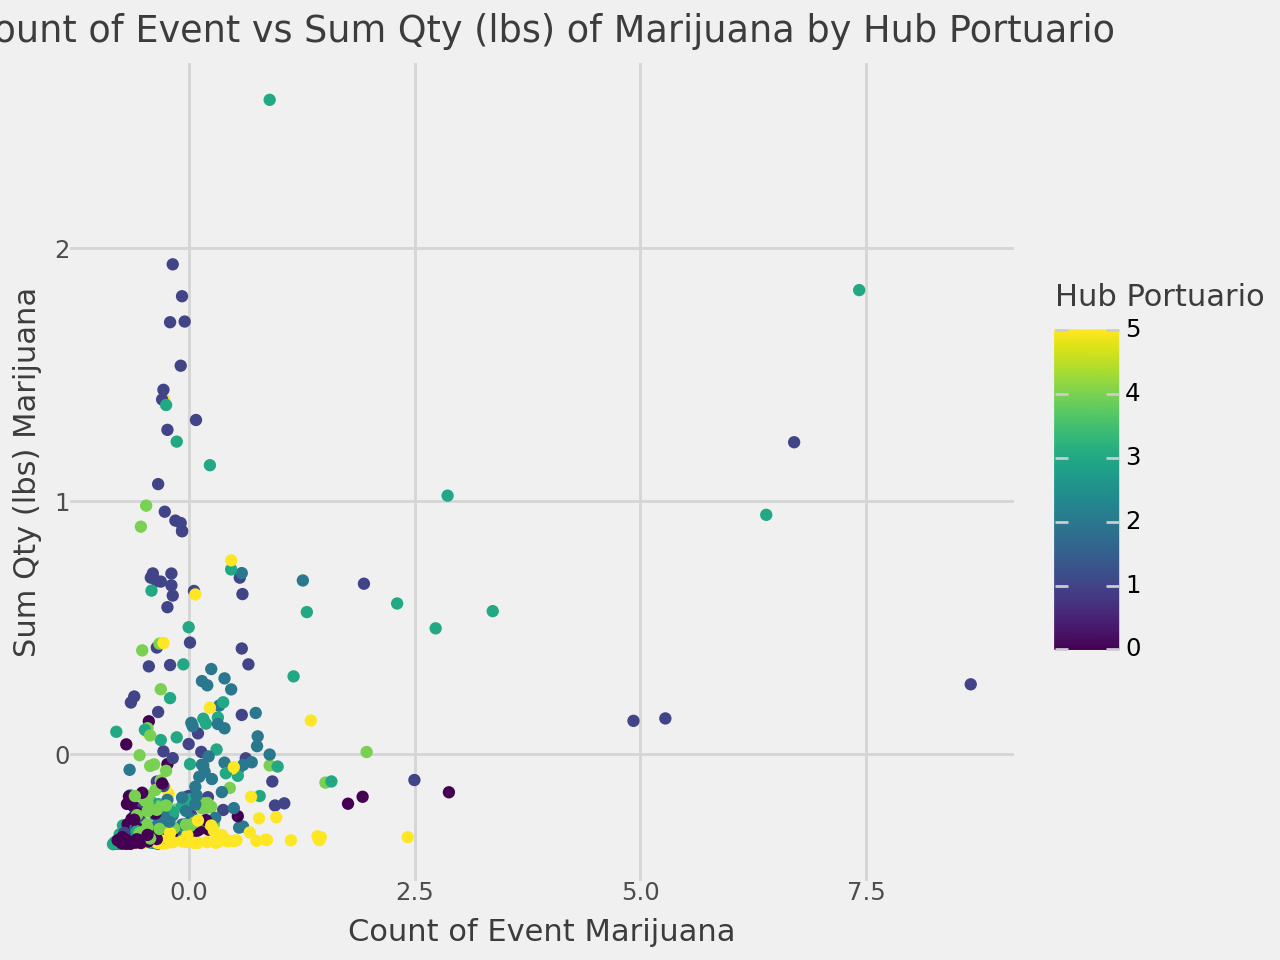

In [91]:
# Filter the dataframe for 'Count of Event_Cocaine' and 'Sum Qty (lbs)_Cocaine' variables
# Create the plot
plot = (ggplot(filtered_data, aes(x='Count of Event_Marijuana', y='Sum Qty (lbs)_Marijuana', color='Hub Portuario'))
    + geom_point()
    + labs(title='Count of Event vs Sum Qty (lbs) of Marijuana by Hub Portuario',
           x='Count of Event Marijuana',
           y='Sum Qty (lbs) Marijuana')
    + theme_538()
    )

plot

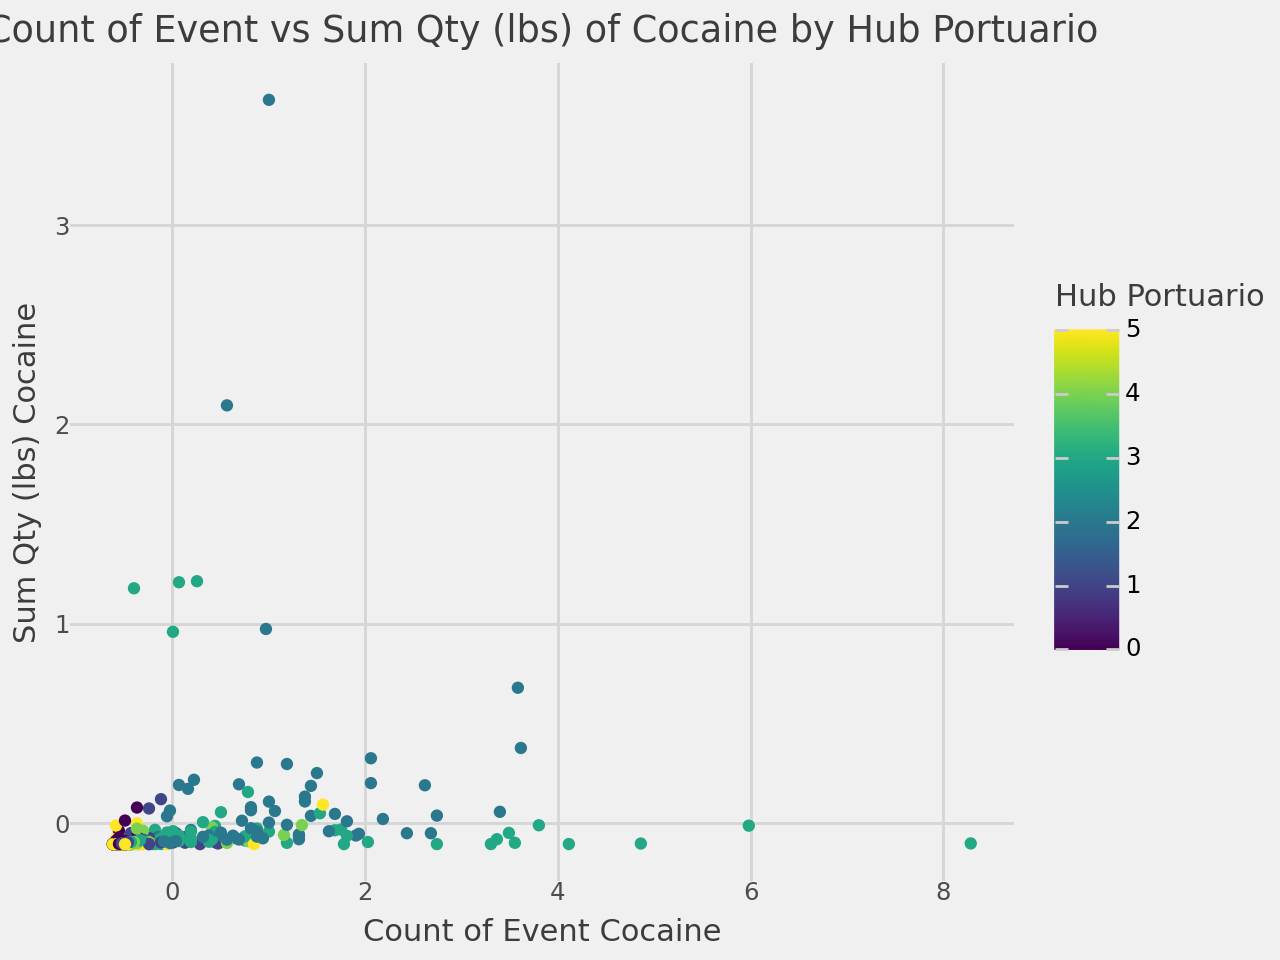

In [92]:
# Filter the dataframe for 'Count of Event_Cocaine' and 'Sum Qty (lbs)_Cocaine' variables
# Create the plot
plot = (ggplot(filtered_data, aes(x='Count of Event_Cocaine', y='Sum Qty (lbs)_Cocaine', color='Hub Portuario'))
    + geom_point()
    + labs(title='Count of Event vs Sum Qty (lbs) of Cocaine by Hub Portuario',
           x='Count of Event Cocaine',
           y='Sum Qty (lbs) Cocaine')
    + theme_538()
    )

plot

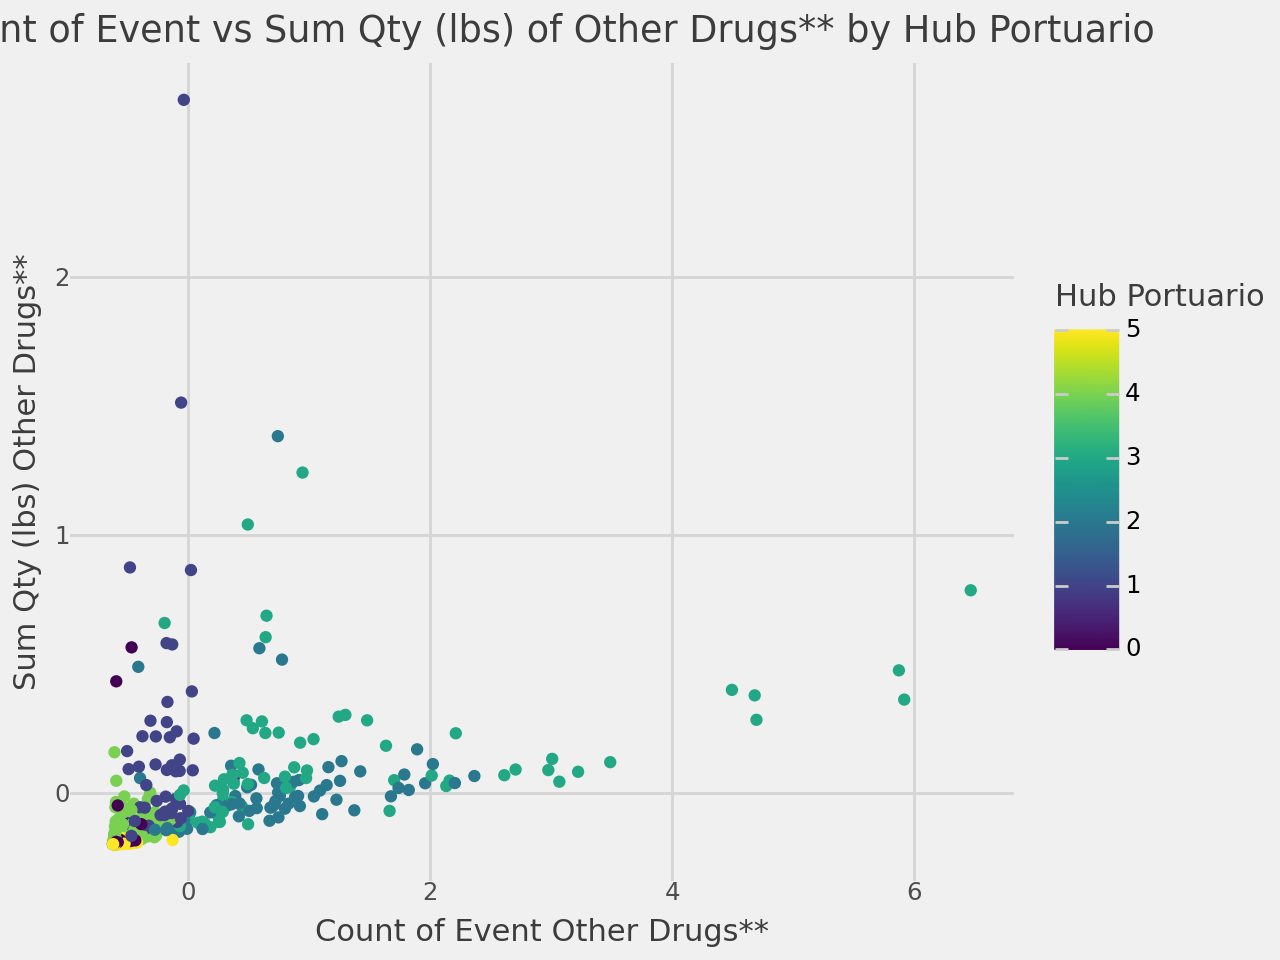

In [93]:
# Filter the dataframe for 'Count of Event_Cocaine' and 'Sum Qty (lbs)_Cocaine' variables
# Create the plot
plot = (ggplot(filtered_data, aes(x='Count of Event_Other Drugs**', y='Sum Qty (lbs)_Other Drugs**', color='Hub Portuario'))
    + geom_point()
    + labs(title='Count of Event vs Sum Qty (lbs) of Other Drugs** by Hub Portuario',
           x='Count of Event Other Drugs**',
           y='Sum Qty (lbs) Other Drugs**')
    + theme_538()
    )

plot

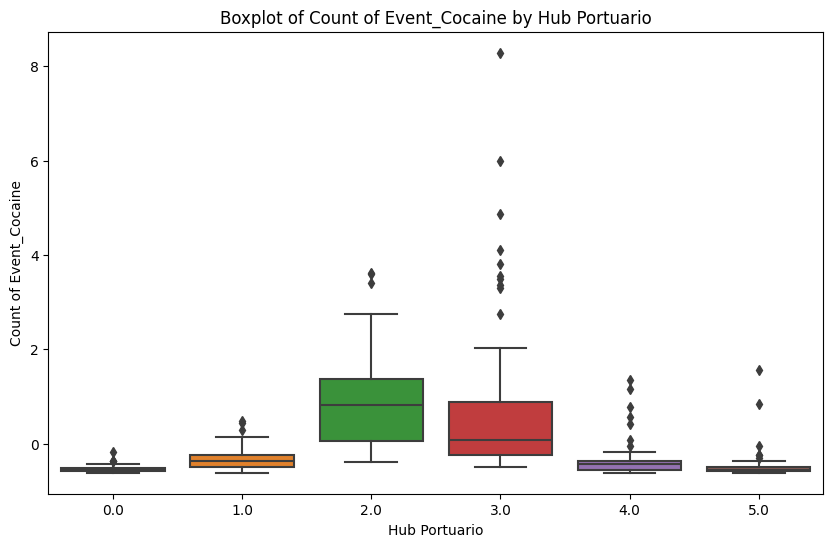

<Axes: title={'center': 'Boxplot of Count of Event_Cocaine by Hub Portuario'}, xlabel='Hub Portuario', ylabel='Count of Event_Cocaine'>

In [94]:
# Create the boxplot
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x='Hub Portuario', y='Count of Event_Cocaine', data=filtered_data)
boxplot.set_title('Boxplot of Count of Event_Cocaine by Hub Portuario')
boxplot.set_xlabel('Hub Portuario')
boxplot.set_ylabel('Count of Event_Cocaine')
plt.show()

boxplot

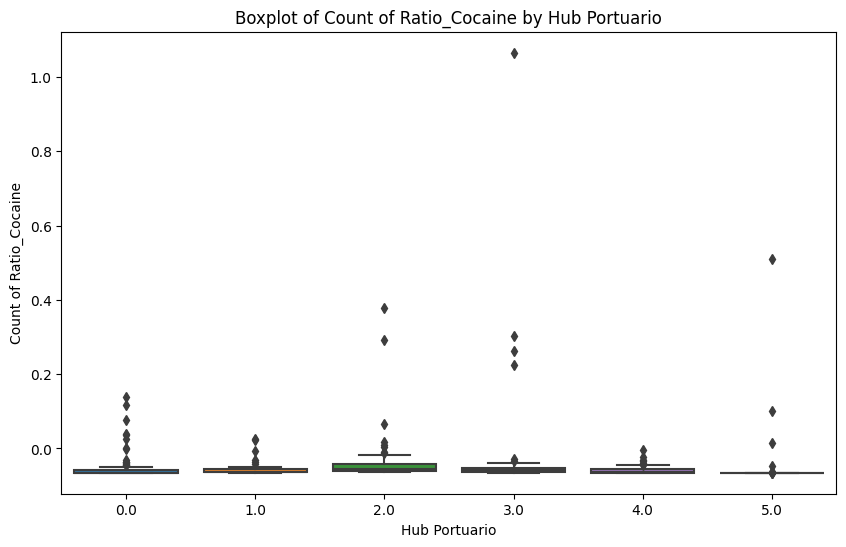

<Axes: title={'center': 'Boxplot of Count of Ratio_Cocaine by Hub Portuario'}, xlabel='Hub Portuario', ylabel='Count of Ratio_Cocaine'>

In [95]:
# Create the boxplot
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x='Hub Portuario', y='Ratio_Cocaine', data=filtered_data)
boxplot.set_title('Boxplot of Count of Ratio_Cocaine by Hub Portuario')
boxplot.set_xlabel('Hub Portuario')
boxplot.set_ylabel('Count of Ratio_Cocaine')
plt.show()

boxplot

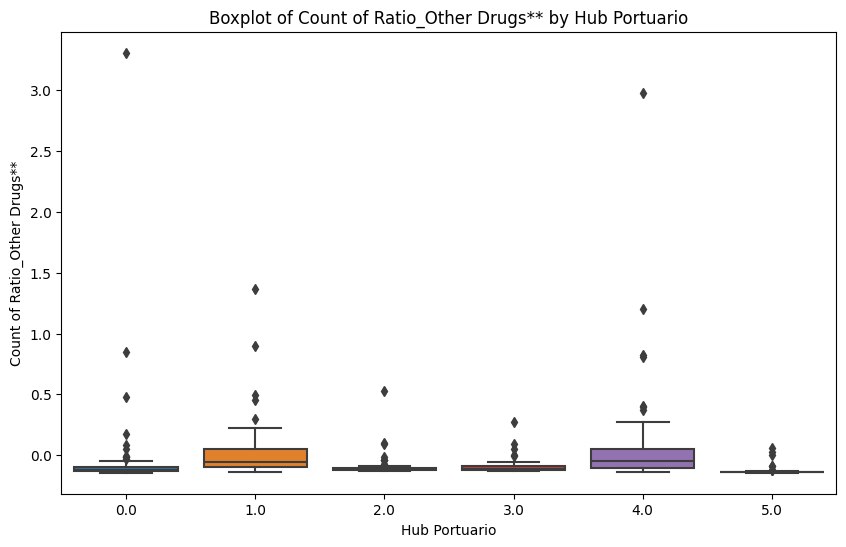

<Axes: title={'center': 'Boxplot of Count of Ratio_Other Drugs** by Hub Portuario'}, xlabel='Hub Portuario', ylabel='Count of Ratio_Other Drugs**'>

In [96]:
# Create the boxplot
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x='Hub Portuario', y='Ratio_Other Drugs**', data=filtered_data)
boxplot.set_title('Boxplot of Count of Ratio_Other Drugs** by Hub Portuario')
boxplot.set_xlabel('Hub Portuario')
boxplot.set_ylabel('Count of Ratio_Other Drugs**')
plt.show()

boxplot

In [ ]:
# Create the plot
plot = (ggplot(filtered_data, aes(x='Total Imports', y='Ratio_Cocaine', color='Hub Portuario'))
    + geom_point()
    + labs(title='Ratio of Cocaine to Total Imports by Hub Portuario',
           x='Total Imports',
           y='Ratio of Cocaine')
    + theme_538()
    )

plot

Dado que me interesa relacionar TEUs con Incautaciones, para filtered data, recuperar graficas de series temporales:

- Indices de filtered_data en combined_data.
- Visualizacion con filtered_data
- Containers vs Ratio_*

In [ ]:
# Filter the dataframe for 'Miami/Fort Lauderdale'
miami_data = filtered_data[filtered_data['Hub Portuario'] == 2.0]

# Define the variables to scale and plot
variables_to_plot = [
    'Loaded Imports', #'Empty Imports', #'Total TEUs', 'Total Imports', 'Total Exports', # 'Empty Exports', 'Loaded Exports', 
    'Count of Event_Other Drugs**', #'Sum Qty (lbs)_Cocaine'
]

# Apply MinMaxScaler to the specified columns
scaler = MinMaxScaler()
miami_data_scaled = miami_data.copy()
miami_data_scaled[variables_to_plot] = scaler.fit_transform(miami_data[variables_to_plot])

# Melt the dataframe to long format
miami_data_melted = miami_data_scaled.melt(id_vars=['Date'], value_vars=variables_to_plot, var_name='Variable', value_name='Value')

# Create the plot
plot = (ggplot(miami_data_melted, aes(x='Date', y='Value', color='Variable', group='Variable'))
    + geom_line()
    + labs(title='Scaled Metrics Over Time\nfor Miami/Fort Lauderdale',
           x='Date',
           y='Scaled Value')
    + theme_538()
    + scale_x_datetime(date_breaks='6 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1)))

plot

### Transformacion Logaritmica
Para 'Sum of Counts' en datos del puerto de Newark

In [ ]:
newark_data_filtered[newark_data_filtered['Sum_of_Counts'] < 0].loc[:,['Sum_of_Counts']]

,Sum_of_Counts


In [104]:
newark_data_filtered['Sum_of_Counts'] += 0.27

In [106]:
import numpy as np

# Create a new dataframe by copying the existing one
newark_data_transformed = newark_data_filtered.copy()

# Apply the logarithmic transformation to the 'Sum_of_Counts' variable
newark_data_transformed['Sum_of_Counts'] = np.log(newark_data_transformed['Sum_of_Counts'])

# Display the first few rows of the new dataframe
newark_data_transformed.head()

,Date,Empty Exports,Loaded Exports,Empty Imports,Loaded Imports,Total TEUs,Total Imports,Total Exports,latitude,longitude,...,Ratio_Fentanyl,Ratio_Heroin,Ratio_Ketamine,Ratio_Khat (Catha Edulis),Ratio_Lsd,Ratio_Marijuana,Ratio_Methamphetamine,Ratio_Other Drugs**,Hub Portuario,Hub Portuario_name
1,2018-10,0.226634,0.425511,-0.252168,0.362197,0.289985,0.299816,0.286070,0.673502,1.387485,...,-0.067249,1.545080,-0.052201,-0.043216,-0.162152,-0.382631,-0.259260,0.275706,3.0,Newark/New York
9,2018-11,0.105361,0.194048,-0.238496,0.216942,0.140519,0.161455,0.131972,0.673502,1.387485,...,-0.044224,0.001596,-0.093232,-0.116475,-0.174826,-0.323334,-0.260977,-0.112556,3.0,Newark/New York
14,2018-12,0.161845,0.201760,-0.255829,0.276565,0.191474,0.215819,0.176661,0.673502,1.387485,...,-0.029467,0.106538,-0.093313,-0.249226,-0.165096,-0.368753,-0.260084,-0.116529,3.0,Newark/New York
20,2019-01,0.201291,0.140094,-0.257236,0.315067,0.217723,0.252953,0.189728,0.673502,1.387485,...,-0.078176,-0.001081,-0.040257,-0.249226,-0.170514,-0.331077,-0.258827,-0.119813,3.0,Newark/New York
31,2019-03,0.138825,0.414304,-0.252078,0.144480,0.142952,0.088203,0.216810,0.673502,1.387485,...,-0.080444,0.050603,-0.014191,-0.249226,-0.174478,-0.355218,-0.260069,-0.127149,3.0,Newark/New York


Representacion transformacion Sum of Counts

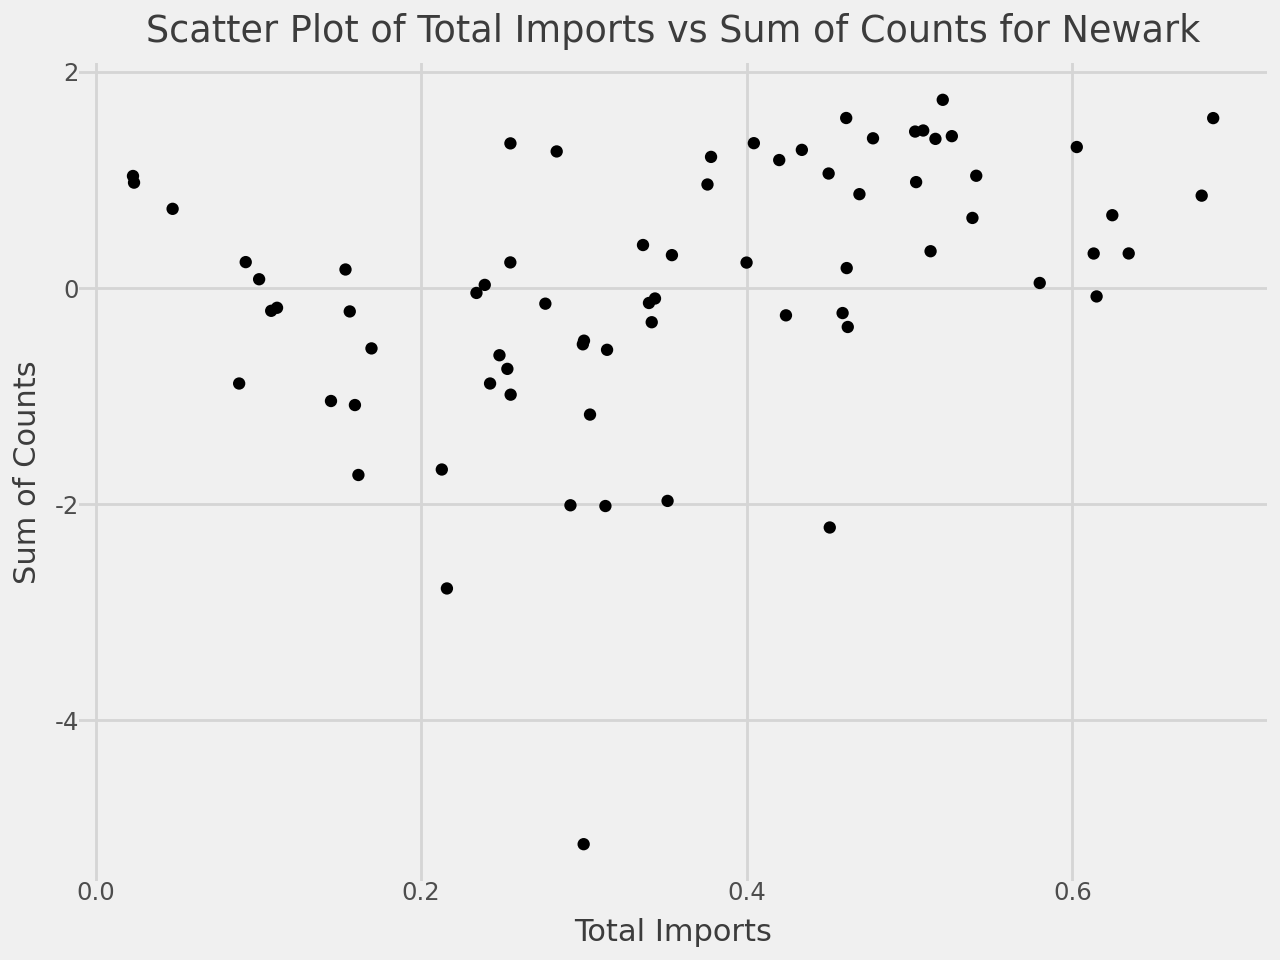

In [107]:
from plotnine import ggplot, aes, geom_point, labs, theme_538

# Create the scatter plot
plot = (ggplot(newark_data_transformed, aes(x='Total Imports', y='Sum_of_Counts'))
    + geom_point()
    + labs(title='Scatter Plot of Total Imports vs Sum of Counts for Newark',
           x='Total Imports',
           y='Sum of Counts')
    + theme_538()
)

plot

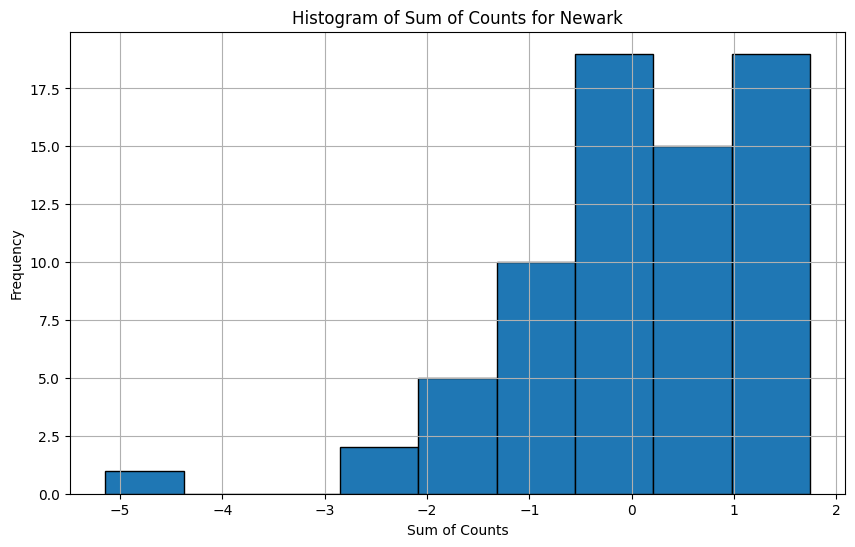

In [109]:
import matplotlib.pyplot as plt

# Plot the histogram for 'Sum_of_Counts'
plt.figure(figsize=(10, 6))
plt.hist(newark_data_transformed['Sum_of_Counts'], bins=9, edgecolor='black')
plt.title('Histogram of Sum of Counts for Newark')
plt.xlabel('Sum of Counts')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

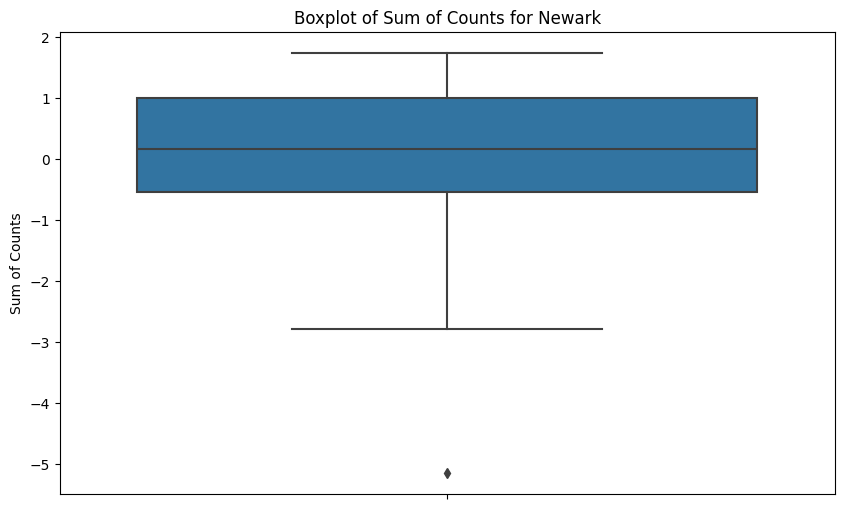

In [110]:
import seaborn as sns

import matplotlib.pyplot as plt

# Create the boxplot
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(y='Sum_of_Counts', data=newark_data_transformed)
boxplot.set_title('Boxplot of Sum of Counts for Newark')
boxplot.set_ylabel('Sum of Counts')
plt.show()

Eliminando ese nuevo outlier

In [113]:
newark_data_transformed['Sum_of_Counts'].sort_values()

1     -5.145184
14    -2.779252
437   -2.215308
63    -2.016666
59    -2.009761
         ...   
232    1.447797
203    1.457506
251    1.572199
223    1.573156
236    1.741406
Name: Sum_of_Counts, Length: 71, dtype: float64

In [ ]:
# Filter the dataframe for rows with 'Sum_of_Counts' > -5
newark_data_filtered_positive = newark_data_transformed[newark_data_transformed['Sum_of_Counts'] > -5]

,Date,Empty Exports,Loaded Exports,Empty Imports,Loaded Imports,Total TEUs,Total Imports,Total Exports,latitude,longitude,...,Ratio_Fentanyl,Ratio_Heroin,Ratio_Ketamine,Ratio_Khat (Catha Edulis),Ratio_Lsd,Ratio_Marijuana,Ratio_Methamphetamine,Ratio_Other Drugs**,Hub Portuario,Hub Portuario_name
9,2018-11,0.105361,0.194048,-0.238496,0.216942,0.140519,0.161455,0.131972,0.673502,1.387485,...,-0.044224,0.001596,-0.093232,-0.116475,-0.174826,-0.323334,-0.260977,-0.112556,3.0,Newark/New York
14,2018-12,0.161845,0.201760,-0.255829,0.276565,0.191474,0.215819,0.176661,0.673502,1.387485,...,-0.029467,0.106538,-0.093313,-0.249226,-0.165096,-0.368753,-0.260084,-0.116529,3.0,Newark/New York
20,2019-01,0.201291,0.140094,-0.257236,0.315067,0.217723,0.252953,0.189728,0.673502,1.387485,...,-0.078176,-0.001081,-0.040257,-0.249226,-0.170514,-0.331077,-0.258827,-0.119813,3.0,Newark/New York
31,2019-03,0.138825,0.414304,-0.252078,0.144480,0.142952,0.088203,0.216810,0.673502,1.387485,...,-0.080444,0.050603,-0.014191,-0.249226,-0.174478,-0.355218,-0.260069,-0.127149,3.0,Newark/New York
36,2019-04,0.159359,0.433479,-0.247605,0.201557,0.183231,0.144613,0.237485,0.673502,1.387485,...,-0.069414,0.273355,-0.029685,0.163711,-0.175825,-0.305254,-0.249411,-0.123698,3.0,Newark/New York


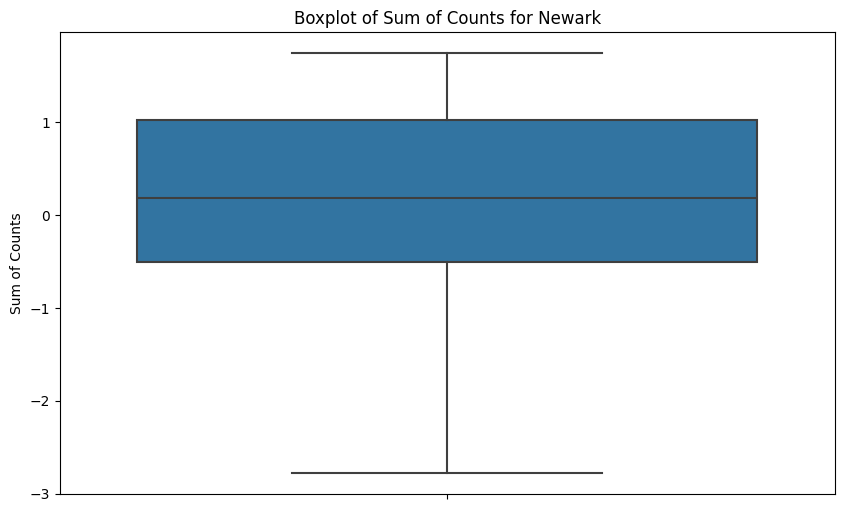

In [115]:
# Create the boxplot
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(y='Sum_of_Counts', data=newark_data_filtered_positive)
boxplot.set_title('Boxplot of Sum of Counts for Newark')
boxplot.set_ylabel('Sum of Counts')
plt.show()

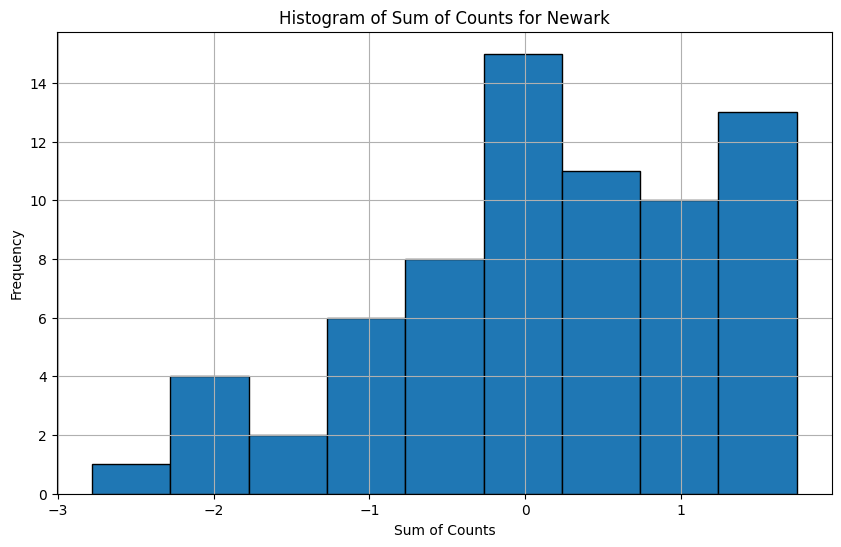

In [116]:
# Plot the histogram for 'Sum_of_Counts'
plt.figure(figsize=(10, 6))
plt.hist(newark_data_filtered_positive['Sum_of_Counts'], bins=9, edgecolor='black')
plt.title('Histogram of Sum of Counts for Newark')
plt.xlabel('Sum of Counts')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

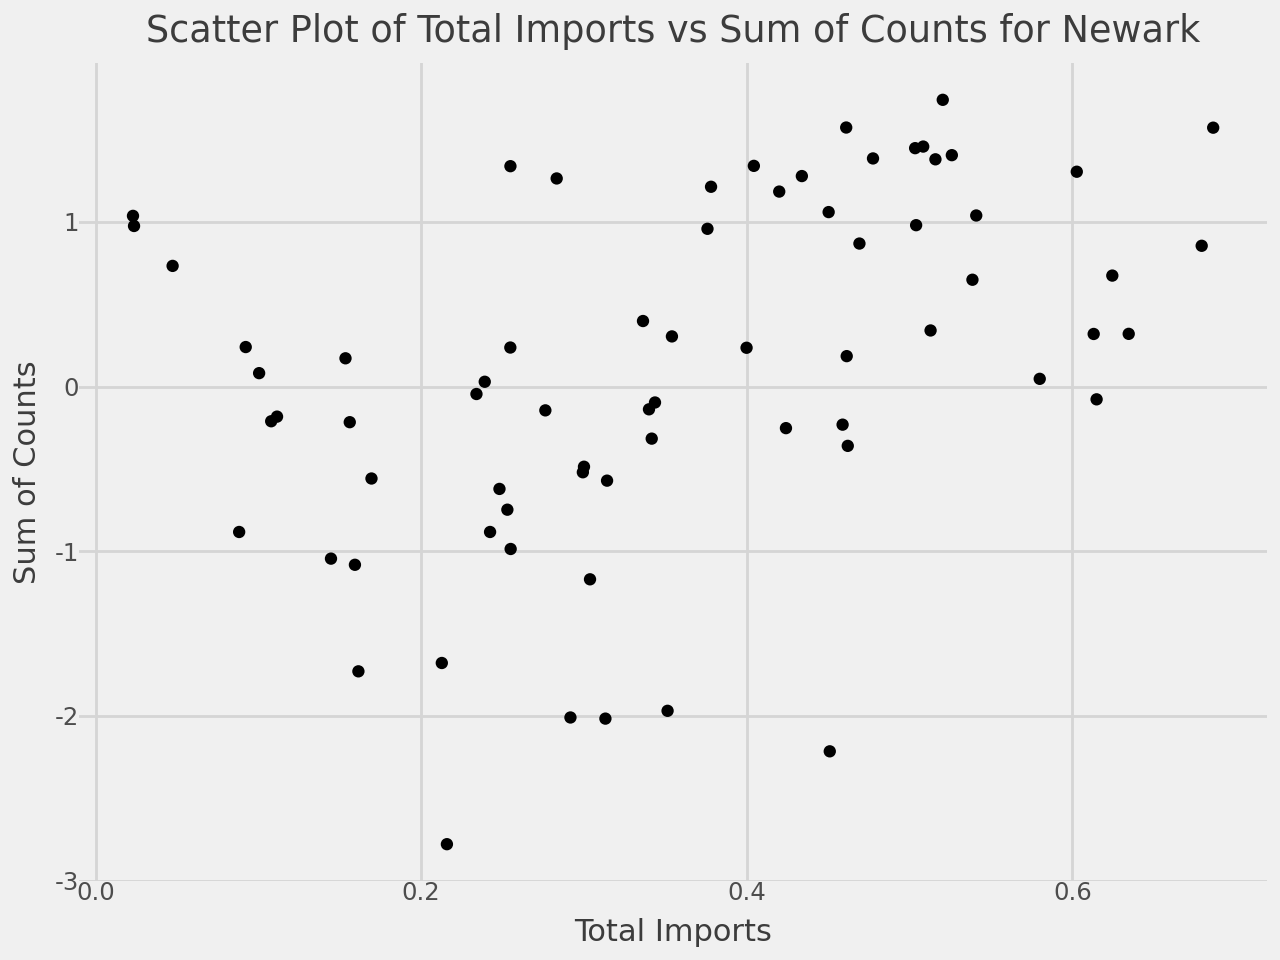

In [117]:
# Create the scatter plot
plot = (ggplot(newark_data_filtered_positive, aes(x='Total Imports', y='Sum_of_Counts'))
    + geom_point()
    + labs(title='Scatter Plot of Total Imports vs Sum of Counts for Newark',
           x='Total Imports',
           y='Sum of Counts')
    + theme_538()
)

plot

### Guardar puerto de Newark tras modificaciones
newark_data_filtered_positive

In [118]:
newark_data_filtered_positive.to_csv('../sources/newark_data_treated.csv')

## Modelo Machine Learning

### Estudiando el Modelo
- Qué target?
- Qué métrica de evaluación?

- Se descartan outliers? O se mantienen?
- Qué influencia tienen "deltas" altos y aislados? Vs datos constantes altos
- Sobre qué variables se toman: ratios_*?
- Importa más si crece o decrece? Tomar derivadas
- Cómo puntuar: penaliza más si containers bajan pero drogas suben
- La relación entre derivadas de variables (nos dan valores negativos o positivos).
- Cociente entre derivadas (cociente de signos). DEpende de cuál sube y cual baja:
    - Es peor si baja containers, pero suben incautaciones -> Aplicar arc tan*

- Existen puertos con constante trasiego y numeros constantes. Frente a otros con deltas altos (un ratio con media baja pero ocasiones puntuales con una incautacion de gran cantidad)

- El target es una metrica que depende del presente* de contenedores y de datos pasados (ponderados) de incautaciones.


Para tratar una serie temporal:
- Está ordenada en el tiempo. OK
- ¿Qué error? MAE, MAPE, MedAE, MedAPE, SMAPE
- Proceso estocástico
- El sistema es ergódico (*). E

### Guardar y cargar datos II

In [ ]:
# Create a copy of combined_data
combined_data_copy = combined_data.copy()

# Select rows with indices in filtered_data
filtered_combined_data = combined_data_copy.loc[filtered_data.index]

In [ ]:
# Guardar filter_combined_data y filtered_data
filtered_combined_data.to_csv('../sources/filtered_combined_data.csv', index=False)
filtered_data.to_csv('../sources/filtered_data.csv', index=False)

### Cargar datos II
Cargar datos:

In [ ]:
filtered_data = pd.read_csv('../sources/filtered_data.csv')
filtered_combined_data = pd.read_csv('../sources/filtered_combined_data.csv')

### Predictores

Predictores: derivadas de TEUs

In [ ]:
import numpy as np
from scipy import signal
from scipy.ndimage import gaussian_filter1d


In [ ]:
# Define the TEU columns to include
teu_columns = ['Empty Exports', 'Loaded Exports', 'Empty Imports', 'Loaded Imports', 'Total TEUs', 'Total Imports', 'Total Exports']

# Create the filtered_predictors dataframe by selecting the TEU columns and additional columns from filtered_data
filtered_predictors = filtered_data[['Hub Portuario', 'Date', 'latitude', 'longitude'] + teu_columns]
columns_to_differentiate = teu_columns

In [ ]:
# Define the TEU columns to include
teu_columns = ['Empty Exports', 'Loaded Exports', 'Empty Imports', 'Loaded Imports', 'Total TEUs', 'Total Imports', 'Total Exports']

# Create the filtered_predictors dataframe by selecting the TEU columns and additional columns from filtered_data
non_filtered_predictors = combined_data[['Hub Portuario', 'Date', 'latitude', 'longitude'] + teu_columns]

De momento, se seguirá trabajando con 'filtered_data' y, por lo tanto, 'filtered_predictors'

### Pruebas y Visualizaciones para Suavizados

In [ ]:
from scipy.misc import derivative

# Define a function to apply differentiation
def differentiate_column(column):
    return column.diff().fillna(0)

# Apply the differentiation function to the specified columns

for col in columns_to_differentiate:
    filtered_predictors[f'{col}_diff'] = differentiate_column(filtered_predictors[col])

# Display the updated dataframe
filtered_predictors.head()

# Filter the dataframe for 'Hub Portuario' == 2
miami_data = filtered_predictors[filtered_predictors['Hub Portuario'] == 2]

In [ ]:
from plotnine import ggplot, aes, geom_line, labs, theme_538, facet_wrap, scale_x_datetime, theme, element_text

# Melt the dataframe to long format
variables_to_plot = ['Loaded Imports', 'Loaded Imports_diff']
miami_data_melted = miami_data.melt(id_vars=['Date'], value_vars=variables_to_plot, var_name='Variable', value_name='Value')

# Create the plot
plot = (ggplot(miami_data_melted, aes(x='Date', y='Value', color='Variable', group='Variable'))
    + geom_line()
    + labs(title='Loaded Imports and Loaded Imports_diff\nOver Time for Miami/Fort Lauderdale',
           x='Date',
           y='Value')
    + theme_538()
    + facet_wrap('~ Variable', scales='free_y')
    + scale_x_datetime(date_breaks='12 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    )

plot

In [ ]:
# Define a function to apply differentiation
def differentiate_column(column):
    return column.diff().fillna(0)

# Apply the differentiation function to the specified columns
columns_to_differentiate = ['Empty Exports', 'Loaded Exports', 'Empty Imports', 'Loaded Imports', 'Total TEUs', 'Total Imports', 'Total Exports']
for col in columns_to_differentiate:
    non_filtered_predictors[f'{col}_diff'] = differentiate_column(non_filtered_predictors[col])

In [ ]:
from plotnine import ggplot, aes, geom_line, labs, theme_538, facet_wrap

# Filter the dataframe for 'Hub Portuario' == 2
miami_data = non_filtered_predictors[non_filtered_predictors['Hub Portuario'] == 'Miami/Fort Lauderdale']

# Melt the dataframe to long format
variables_to_plot = ['Loaded Imports', 'Loaded Imports_diff']
miami_data_melted = miami_data.melt(id_vars=['Date'], value_vars=variables_to_plot, var_name='Variable', value_name='Value')

# Create the plot
plot = (ggplot(miami_data_melted, aes(x='Date', y='Value', color='Variable', group='Variable'))
    + geom_line()
    + labs(title='Loaded Imports and Loaded Imports_diff Over Time for Miami/Fort Lauderdale',
           x='Date',
           y='Value')
    + theme_538()
    + facet_wrap('~ Variable', scales='free_y'))

plot

En ambos casos, la volatilidad de la variable original, más la implementación original de scipy.derivative da como resultado una función de diferencias que varía mucho. Para evitar ello, hace falta realizar un suavizado sobre la función original para intentar aproximar a la principal línea de tendencia de la curva (main trend line)

Looking at your graph, I see the issue with the derivative calculation. The "Loaded Imports_diff" line (in cyan) is showing high volatility that doesn't reflect the smoother underlying trend in the "Loaded Imports" data (in red).\
The problem is likely that you're using a simple difference method in scipy's derivative function, which calculates point-by-point differences. This makes the derivative very sensitive to noise in the original data.
Here's how you can get a smoother derivative:\

- Apply smoothing to the original data before taking the derivative
- Use a wider window size for the derivative calculation
- Apply smoothing to the derivative result itself

Here's some code that should help:

In [ ]:

# Assuming df is your dataframe with 'Date' and 'Loaded Imports' columns
# First, smooth the original data
filtered_predictors['Loaded_Imports_Smoothed'] = gaussian_filter1d(filtered_predictors['Loaded Imports'], sigma=3)

# Option 1: Calculate derivative with a wider window
def smooth_derivative(x, y, window=5):
    """Calculate a smoother derivative using a wider window"""
    n = len(y)
    result = np.zeros(n)
    
    half_window = window // 2
    for i in range(n):
        left = max(0, i - half_window)
        right = min(n - 1, i + half_window)
        if right > left:  # Ensure we have points for calculation
            slope, _ = np.polyfit(x[left:right+1], y[left:right+1], 1)
            result[i] = slope
    
    return result

# Convert dates to numeric for calculation
x_numeric = np.arange(len(filtered_predictors))
filtered_predictors['Loaded_Imports_diff_smooth'] = smooth_derivative(x_numeric, filtered_predictors['Loaded Imports'], window=15)


Visualizacion gráfica:

In [ ]:
from plotnine import ggplot, aes, geom_line, labs, theme_538, facet_wrap

# Filter the dataframe for 'Hub Portuario' == 2.0
miami_data = filtered_predictors[filtered_predictors['Hub Portuario'] == 2.0]

# Melt the dataframe to long format
variables_to_plot = ['Loaded Imports', 'Loaded_Imports_diff_smooth']
miami_data_melted = miami_data.melt(id_vars=['Date'], value_vars=variables_to_plot, var_name='Variable', value_name='Value')

# Create the plot
plot = (ggplot(miami_data_melted, aes(x='Date', y='Value', color='Variable', group='Variable'))
    + geom_line()
    + labs(title='Loaded Imports and Loaded_Imports_diff_smooth Over Time for Miami/Fort Lauderdale',
           x='Date',
           y='Value')
    + theme_538()
    + facet_wrap('~ Variable', scales='free_y'))

plot

Filtros en señal de entrada:

In [ ]:
# Probar con MA:
filtered_predictors['Loaded_Imports_MA'] = filtered_predictors['Loaded Imports'].rolling(window=6).mean()

# Apply for 'hub portuario' == 2
miami_data = filtered_predictors[filtered_predictors['Hub Portuario'] == 2.0]
miami_data['Loaded_Imports_MA'] = miami_data['Loaded Imports'].rolling(window=4).mean()

# Option 2: Use scipy's savgol_filter for differentiation and smoothing in one step
miami_data['Loaded_Imports_diff_savgol'] = signal.savgol_filter(miami_data['Loaded_Imports_MA'], window_length=4, polyorder=3, deriv=1)

# Option 3: Apply additional smoothing to the derivative
miami_data['Loaded_Imports_diff'] = np.gradient(miami_data['Loaded_Imports_MA'])
miami_data['Loaded_Imports_diff_smoothed'] = gaussian_filter1d(miami_data['Loaded_Imports_diff'], sigma=3)

In [ ]:
# Filter the dataframe for 'Hub Portuario' == 2.0
# miami_data = filtered_predictors[filtered_predictors['Hub Portuario'] == 2.0]

# Melt the dataframe to long format
variables_to_plot = ['Loaded_Imports_MA', 'Loaded_Imports_diff_smoothed']
miami_data_melted = miami_data.melt(id_vars=['Date'], value_vars=variables_to_plot, var_name='Variable', value_name='Value')

# Create the plot
plot = (ggplot(miami_data_melted, aes(x='Date', y='Value', color='Variable', group='Variable'))
    + geom_line()
    + labs(title='Loaded Imports and Loaded_Imports_diff_smoothed\nOver Time for Miami/Fort Lauderdale',
           x='Date',
           y='Value')
    + theme_538()
    + facet_wrap('~ Variable', scales='free_y')
    + scale_x_datetime(date_breaks='12 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    )

plot

In [ ]:
miami_data['Loaded_Imports_EWMA'] = miami_data['Loaded Imports'].ewm(span=4).mean()

In [ ]:
# Option 2: Use scipy's savgol_filter for differentiation and smoothing in one step
miami_data['Loaded_Imports_diff_emwa'] = signal.savgol_filter(miami_data['Loaded_Imports_EWMA'], window_length=4, polyorder=2, deriv=1)

# Option 3: Apply additional smoothing to the derivative
miami_data['Loaded_Imports_emwa_diff'] = np.gradient(miami_data['Loaded_Imports_EWMA'])
miami_data['Loaded_Imports_emwa_diff_smoothed'] = gaussian_filter1d(miami_data['Loaded_Imports_emwa_diff'], sigma=3)

In [ ]:
# Melt the dataframe to long format
variables_to_plot = ['Loaded_Imports_EWMA', 'Loaded_Imports_emwa_diff_smoothed']
miami_data_melted = miami_data.melt(id_vars=['Date'], value_vars=variables_to_plot, var_name='Variable', value_name='Value')

# Create the plot
plot = (ggplot(miami_data_melted, aes(x='Date', y='Value', color='Variable', group='Variable'))
    + geom_line()
    + labs(title='Loaded Imports and\Loaded_Imports_emwa_diff_smoothed\nOver Time for Miami/Fort Lauderdale',
           x='Date',
           y='Value')
    + theme_538()
    + facet_wrap('~ Variable', scales='free_y', )
    + scale_x_datetime(date_breaks='12 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    )

plot

In [ ]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
miami_data['Loaded_Imports_Lowess'] = lowess(miami_data['Loaded Imports'], np.arange(len(miami_data)), frac=0.1)[:, 1]

In [ ]:
# Option 2: Use scipy's savgol_filter for differentiation and smoothing in one step
miami_data['Loaded_Imports_diff_lowess'] = signal.savgol_filter(miami_data['Loaded_Imports_Lowess'], window_length=6, polyorder=2, deriv=1)

# Option 3: Apply additional smoothing to the derivative
miami_data['Loaded_Imports_lowess_diff'] = np.gradient(miami_data['Loaded_Imports_Lowess'])
miami_data['Loaded_Imports_diff_smoothed'] = gaussian_filter1d(miami_data['Loaded_Imports_lowess_diff'], sigma=3)

In [ ]:
# Melt the dataframe to long format
variables_to_plot = ['Loaded_Imports_Lowess', 'Loaded_Imports_diff_lowess']
miami_data_melted = miami_data.melt(id_vars=['Date'], value_vars=variables_to_plot, var_name='Variable', value_name='Value')

# Create the plot
plot = (ggplot(miami_data_melted, aes(x='Date', y='Value', color='Variable', group='Variable'))
    + geom_line()
    + labs(title='Loaded Imports and Loaded_Imports_diff_lowess\nOver Time for Miami/Fort Lauderdale',
           x='Date',
           y='Value')
    + theme_538()
    + facet_wrap('~ Variable', scales='free_y')
    + scale_x_datetime(date_breaks='12 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

plot

### Generar predictores por hub portuario para todas las variables de TEUs
Generar predictores con smooth_data and smooth_data_diff, per hub portuario

In [ ]:
# Generar predictors para el modelo, usando MA (ventana = 5), y para diff, savgol (M=5)

# 1. Separar por hub portuario
model_predictors = pd.DataFrame()
for puerto in filtered_predictors['Hub Portuario'].unique():
    puerto_data = filtered_predictors[filtered_predictors['Hub Portuario'] == puerto]
    
    # 2. Generar variables smoothed (MA, 5)
    for col in columns_to_differentiate:
        puerto_data[f'{col}_MA'] = puerto_data[col].rolling(window=5).mean()
    
    # 3. Aplicar derivada con savgol (M=5)
    for col in columns_to_differentiate:
        puerto_data[f'{col}_diff_savgol'] = signal.savgol_filter(puerto_data[f'{col}_MA'], window_length=5, polyorder=3, deriv=1)
    
    # 4. Añadir variables suavizadas y derivadas suavizadas al dataframe model_predictors
    model_predictors = pd.concat([model_predictors, puerto_data], ignore_index=True)

#### Missing Values después de Filtrado/Suavizado:
Procesar NaN generados por aplicar los filtros:

In [ ]:
# List of '_MA' columns
ma_columns = [col for col in model_predictors.columns if col.endswith('_MA')]

# Select rows with NaN values in the '_MA' columns
rows_with_nan = model_predictors[model_predictors[ma_columns].isna().any(axis=1)]

# Iterate over each 'Hub Portuario'
for hub in rows_with_nan['Hub Portuario'].unique():
    # Filter rows for the current 'Hub Portuario'
    hub_rows_with_nan = rows_with_nan[rows_with_nan['Hub Portuario'] == hub]
    
    # Iterate over each '_MA' column
    for ma_col in ma_columns:
        # Get the associated column name by removing '_MA'
        associated_col = ma_col.replace('_MA', '')
        
        # Calculate the mean of the associated column for the current 'Hub Portuario'
        mean_value = rows_with_nan[rows_with_nan['Hub Portuario'] == hub][associated_col].mean()
        
        # Impute NaN values in the '_MA' column with the mean value
        model_predictors.loc[hub_rows_with_nan.index, ma_col] = mean_value


In [ ]:
# List of '_diff_savgol' columns
diff_savgol_columns = [col for col in model_predictors.columns if col.endswith('_diff_savgol')]

# Select rows with NaN values in the 'diff' columns
rows_with_nan = model_predictors[model_predictors[diff_savgol_columns].isna().any(axis=1)]

# Iterate over each '_diff_savgol' column
for diff_col in diff_savgol_columns:
    # Get the associated '_MA' column name by replacing '_diff_savgol' with '_MA'
    ma_col = diff_col.replace('_diff_savgol', '_MA')
    
    # Calculate the mean of the differences of the '_MA' column using rows with NaN values
    mean_diff = rows_with_nan[ma_col].diff().mean()
    
    # Impute NaN values in the '_diff_savgol' column with the mean difference
    model_predictors[diff_col].fillna(mean_diff, inplace=True)

### Generación del target:
A partir de los predictores (derivadas de datos de TEUs suavizados) que adivinen el target (relacionado con la incautación de estupefacientes).

Para el target, me interesa: ratios sobre drogas, y lags sobre ratios. Al realizar suavizado (filtro de convolución, implícitamente la muestra actual depende de las anteriores, por lo que realmente no hace falta realizar el lag)

Se va a trabajar con datos procesados por StandardScaler()

In [ ]:
filtered_data.columns

- ¿Qué quiere decir 'Ratio'? Se refiere a la cantidad de droga incautada por redada (Count of Event).

    - Visto en las gráficas y tratados outliers: existen puertos con constantes redadas e incautaciones. En algunos casos, salen picos (deltas) que implican una redada con mucha droga incautada.

- ¿Qué busca el modelo?

    - Enfrentar rachas* vs deltas** del target obtenido a partir de las variables de incautaciones [me interesa el ratio presente y un numero indeterminado de lags de ratios] y tratarlo en función de la tendencia de los predictores.

- Entonces el target, ¿qué variable es?
    - Puntuación de = la derivada de (la suma de ratios ponderados por media movil (u otro modo de ponderacion + convolucion) de Count_of_Event para cada droga ).

\* **Racha**: el ratio no varía mucho entre meses consecutivos. Dado que se maneja datos con StandardScaler(), datos que se encuentran cercanos a la media de la función. \

\*\* **Delta**: de vez en cuando, en un mes aislado, hay un pico que se sale de lo esperado (datos en la cola de la distribución, pasó el filtro de outliers)\

\*\*\* **Derivada de Counts**: Counts está suavizado por el mismo filtro que los predictores, se aplica su derivada. 



### Diseño del target:
**Opción A**: Target: derivada ((Weighted sum of ratios x MA (Count_of_Event)[Drug Type])

De este target, tendrán más peso los ratios de drogas con mayor promedio temporal de incautaciones. Y sobre ello, se realiza la variación filtrada (Derivada y suavizado con savitzky-golan filter)

**Opción B**: Target: (Weighted sum of ratios x MA (Count_of_Event)[Drug Type])

In [ ]:
# Filter columns that start with 'Count of Event_' and 'Ratio_'
count_columns = [col for col in filtered_data.columns if col.startswith('Count of Event_')]
ratio_columns = [col for col in filtered_data.columns if col.startswith('Ratio_')]

# Create a new dataframe with the filtered columns
new_dataframe = filtered_data[['Hub Portuario', 'Date'] + count_columns + ratio_columns]

# Define the 'Count of Event_' columns
count_columns = [col for col in new_dataframe.columns if col.startswith('Count of Event_')]

# Apply rolling average with window length of 5 for each 'Hub Portuario'
for col in count_columns:
    new_dataframe[f'{col}_MA'] = new_dataframe.groupby('Hub Portuario')[col].transform(lambda x: x.rolling(window=5).mean())


Tratamiento MVs tras suavizado:

In [ ]:
# List of '_MA' columns
event_columns = [col for col in new_dataframe.columns if col.endswith('_MA')]

# Select rows with NaN values in the '_MA' columns
rows_with_nan = new_dataframe[new_dataframe[event_columns].isna().any(axis=1)]

# Iterate over each 'Hub Portuario'
for hub in rows_with_nan['Hub Portuario'].unique():
    # Filter rows for the current 'Hub Portuario'
    hub_rows_with_nan = rows_with_nan[rows_with_nan['Hub Portuario'] == hub]
    
    # Iterate over each '_MA' column
    for ma_col in event_columns:
        # Get the associated column name by removing '_MA'
        associated_col = ma_col.replace('_MA', '')
        
        # Calculate the mean of the associated column for the current 'Hub Portuario'
        mean_value = rows_with_nan[rows_with_nan['Hub Portuario'] == hub][associated_col].mean()
        
        # Impute NaN values in the '_MA' column with the mean value
        new_dataframe.loc[hub_rows_with_nan.index, ma_col] = mean_value


Weighted sum of ratios:
- ¿Sobre qué pondero? Sobre Count of Event suavizado.

In [ ]:
# Define the 'Count of Event_%_MA' columns and 'Ratio_' columns
count_ma_columns = [col for col in new_dataframe.columns if col.startswith('Count of Event_') and col.endswith('_MA')]
ratio_columns = [col for col in new_dataframe.columns if col.startswith('Ratio_')]

# Calculate the sum of products
new_dataframe['Sum_of_Products'] = (new_dataframe[count_ma_columns].values * new_dataframe[ratio_columns].values).sum(axis=1)


Aplicar la derivada a la columna 'Sum_of_Products'

In [ ]:
from scipy.signal import savgol_filter

# Apply savgol_filter for differentiation and smoothing in one step
new_dataframe['Sum_of_Products_diff'] = savgol_filter(new_dataframe['Sum_of_Products'], window_length=5, polyorder=2, deriv=1)

In [ ]:
model_target_complete = new_dataframe[['Hub Portuario','Date','Sum_of_Products']]
# Apply left join
model_data = pd.merge(model_predictors, model_target_complete, on=['Hub Portuario', 'Date'], how='left')
model_data.rename(columns={'Sum_of_Products_diff':'Target'}, inplace=True)

## Aplicación del Modelo de Machine Learning

In [ ]:
# Guardar a csv 'model_predictors' y 'model_target'
model_data.to_csv('../sources/model_data.csv', index=False)
# model_data_2.to_csv('../sources/model_data_2.csv', index=False)

In [ ]:
# Cargar csv del modelo:
model_data = pd.read_csv('../sources/model_data.csv')

### Modelo Puerto Único
Separar datos por 'Hub Portuario'. Se elimina la variable 'Hub Portuario' y coordenadas

In [ ]:
# Select all columns except 'Date'
model_data_no_date = model_data.loc[:, model_data.columns != 'Date']

# Display the first few rows of the new dataframe
model_data_no_date.head()

In [ ]:
# Filter the dataframe for 'Hub Portuario' == 2
hub_2_data = model_data[model_data['Hub Portuario'] == 2.0]

# # Generate date range
# date_range = pd.date_range(start='2018-10', end='2025-01', freq='M')

# # Convert to list of integers
# date_integers = list(range(len(date_range)))

# # Create a dictionary to map original dates to date integers
# date_mapping = dict(zip(date_range.strftime('%Y-%m'), date_integers))

# # Substitute the values in 'Date' column with corresponding 'date_integers' values
# model_data['Date'] = model_data['Date'].map(date_mapping)

# Calculate the variance of each column
variance = model_data_no_date.var()

# Drop columns with variance = 0
hub_2_data = model_data_no_date.loc[:, variance != 0]
hub_2_data['Date'] = model_data['Date']

In [ ]:
hub_2_data.head()

#### Matriz de correlaciones + Visualizaciones:

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

hub_2_no_date = hub_2_data.loc[:, hub_2_data.columns != 'Date']

# Calculate the correlation matrix
corr_matrix = hub_2_no_date.corr().abs()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix (Absolute Values) for hub_2_data')
plt.show()

In [ ]:
from plotnine import ggplot, aes, geom_line, labs, theme_538, facet_wrap, scale_x_datetime, theme, element_text

# Melt the dataframe to long format
variables_to_plot = ['Loaded Imports_MA', 'Loaded Imports_diff_savgol']
hub_2_data_melted = hub_2_data.melt(id_vars=['Date'], value_vars=variables_to_plot, var_name='Variable', value_name='Value')

# Create the plot
plot = (ggplot(hub_2_data_melted, aes(x='Date', y='Value', color='Variable', group='Variable'))
    + geom_line()
    + labs(title='Empty Exports and Loaded Exports Over Time for Hub 2',
           x='Date',
           y='Value')
    + theme_538()
    + facet_wrap('~ Variable', scales='free_y')
    + scale_x_datetime(date_breaks='12 months', date_labels='%b %Y')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    )

plot

#### Mejor Modelo
- Validación de hiperparámetros
- Generalización
- Métrica de evaluación

### Modelo N-Puertos
Se trabajan con las variables de coordenadas